# Goal of this notebook: extend the SpectralND class to barycentric rationals with learnable weights.

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Models

## SpectralND: polynomial interpolation

In [51]:
class SpectralInterpolationND(nn.Module):
    def __init__(self, Ns, bases, domains):
        """
        ND interpolation using spectral methods
        
        Args:
            Ns: List of number of points per direction
            bases: List of bases per direction, either 'fourier' or 'chebyshev'
            domains: List of tuples of (min, max) per direction
        """
        super().__init__()
        
        # Store domain information
        assert len(Ns) == len(bases) == len(domains)
        self.n_dim = len(Ns)
        
        self.Ns = Ns
        self.bases = bases
        self.domains = domains
        self.domain_lengths = [domain[1] - domain[0] for domain in domains]
        
        # Set up nodes and weight/frequencies for interpolation (as needed)
        self.nodes = [None for _ in range(self.n_dim)]
        self.nodes_standard = [None for _ in range(self.n_dim)]
        self._from_standard = [None for _ in range(self.n_dim)]
        self._to_standard = [None for _ in range(self.n_dim)]
        self.cheb_weights = [None for _ in range(self.n_dim)]
        self.k = [None for _ in range(self.n_dim)]
        
        for dim in range(self.n_dim):
            if self.bases[dim] == "chebyshev":
                i = torch.linspace(0, 1, self.Ns[dim])
                self.nodes_standard[dim] = torch.cos(torch.pi * i)
                # Compute barycentric weights for Chebyshev
                N = self.Ns[dim]
                weights = torch.ones(N)
                weights[0] *= 0.5
                weights[-1] *= 0.5
                weights[1::2] = -1
                self.cheb_weights[dim] = weights
                
                self.k[dim] = None
            else:
                self.nodes_standard[dim] = torch.linspace(0, 2*np.pi, self.Ns[dim]+1)[:-1]
                # Compute FFT frequencies
                self.k[dim] = torch.fft.fftfreq(self.Ns[dim]) * self.Ns[dim]
                self.cheb_weights[dim] = None
                
            # Set up domain mapping functions for this dimension
            domain = self.domains[dim]
            if self.bases[dim] == "chebyshev":
                self._to_standard[dim] = lambda x, d=dim: 2 * (x - self.domains[d][0]) / self.domain_lengths[d] - 1
                self._from_standard[dim] = lambda x, d=dim: self.domains[d][0] + (x + 1) * self.domain_lengths[d] / 2
            else:  # fourier
                self._to_standard[dim] = lambda x, d=dim: 2*np.pi * (x - self.domains[d][0]) / self.domain_lengths[d]
                self._from_standard[dim] = lambda x, d=dim: self.domains[d][0] + self.domain_lengths[d] * x / (2*np.pi)
            
            # Map standard nodes to physical domain
            self.nodes[dim] = self._from_standard[dim](self.nodes_standard[dim])
        
        # Set up diff matrices cache
        self._diff_matrices = [{} for _ in range(self.n_dim)]
        
        # Create mesh grid of nodes
        mesh_args = [self.nodes[d] for d in range(self.n_dim)]
        self.mesh = torch.meshgrid(*mesh_args, indexing='ij')
        
        # Learnable values at node points
        self.values = nn.Parameter(torch.zeros(self.Ns))
        
    def _compute_cheb_derivative_matrix(self, nodes, domain_length):
        """
        Compute the differentiation matrix for 1D Chebyshev points
        """
        N = len(nodes)
        D = torch.zeros((N, N), dtype=nodes.dtype, device=nodes.device)

        # Compute weights for endpoints
        c = torch.ones(N, dtype=nodes.dtype, device=nodes.device)
        c[0] = 2
        c[-1] = 2

        # Compute off-diagonal entries
        for i in range(N):
            for j in range(N):
                if i != j:
                    D[i,j] = c[i]/c[j] * (-1)**(i+j) / (nodes[i] - nodes[j])

        # Fill diagonal using negative sum trick
        D.diagonal().copy_(-torch.sum(D, dim=1))

        # Scale for domain transformation
        D = D * (2.0/domain_length)

        return D

    def _compute_fourier_derivative_matrix(self, nodes, domain_length):
        """
        Compute the differentiation matrix for 1D equispaced Fourier
        """
        N = len(nodes)
        D = torch.zeros((N, N), dtype=nodes.dtype, device=nodes.device)

        # Create index matrices
        i, j = torch.meshgrid(torch.arange(N, dtype=nodes.dtype, device=nodes.device), 
                            torch.arange(N, dtype=nodes.dtype, device=nodes.device), 
                            indexing='ij')

        # Compute off-diagonal elements using cotangent formula
        mask = i != j
        diff = (i[mask] - j[mask]) * (-1)**(i[mask] - j[mask])
        D[mask] = 0.5 * torch.tan(torch.pi * diff / N).reciprocal()

        # Diagonal elements are 0 for periodic functions
        D.diagonal().zero_()

        # Scale for domain transformation
        D = D * (2*np.pi/domain_length)

        return D
        
    def derivative_matrix(self, k):
        """
        Get mixed derivative matrix D^k where k is a tuple of derivative orders

        Args:
            k: List/tuple of length n_dim specifying derivative order in each dimension
               e.g., (2,0,1) means second derivative in x, none in y, first in z

        Returns:
            Matrix operator for the mixed derivative
        """
        assert len(k) == self.n_dim, f"Expected {self.n_dim} derivative orders, got {len(k)}"

        # Get 1D matrices for each dimension
        matrices = []
        for dim in range(self.n_dim):
            if k[dim] == 0:
                # Identity matrix for this dimension
                matrices.append(torch.eye(self.Ns[dim], 
                                       dtype=self.nodes_standard[dim].dtype,
                                       device=self.nodes_standard[dim].device))
            else:
                # Compute/get cached derivative matrix
                if k[dim] not in self._diff_matrices[dim]:
                    if 1 not in self._diff_matrices[dim]:
                        if self.bases[dim] == "chebyshev":
                            D = self._compute_cheb_derivative_matrix(self.nodes_standard[dim], self.domain_lengths[dim])
                        else:  # fourier
                            D = self._compute_fourier_derivative_matrix(self.nodes_standard[dim], self.domain_lengths[dim])
                        self._diff_matrices[dim][1] = D

                    # Compose for higher derivatives
                    Dk = self._diff_matrices[dim][1]
                    for _ in range(k[dim]-1):
                        Dk = Dk @ self._diff_matrices[dim][1]
                    self._diff_matrices[dim][k[dim]] = Dk

                matrices.append(self._diff_matrices[dim][k[dim]])

        # Compute Kronecker product
        D = matrices[0]
        for dim in range(1, self.n_dim):
            D = torch.kron(D, matrices[dim])

        return D
    
    def _cheb_interpolate_1d(self, x_eval, values, nodes_std, to_std, weights, eps=1e-14):
        """Helper for 1D Chebyshev interpolation along last axis

        Args:
            x_eval: shape (B1, B) - points to evaluate at
            values: shape (B2, B, N) - function values at nodes
            nodes_std: shape (N,) - standard Chebyshev nodes
            to_std: function - maps from physical to standard domain
            weights: shape (N,) - barycentric weights

        Returns:
            shape (B1, B2, B) - interpolated values
        """
        x_eval_standard = to_std(x_eval)  # (B1, B)

        # Reshape inputs for broadcasting:
        # x_eval: (B1, 1, B, 1)
        # values: (1, B2, B, N)
        # nodes: (1, 1, 1, N)
        # weights: (1, 1, 1, N)
        x_eval_expanded = x_eval_standard.unsqueeze(1).unsqueeze(-1)  # (B1, 1, B, 1)
        values_expanded = values.unsqueeze(0)  # (1, B2, B, N)
        nodes_expanded = nodes_std.reshape(1, 1, 1, -1)
        weights_expanded = weights.reshape(1, 1, 1, -1)

        # Compute distances - result is (B1, B2, B, N)
        d_x = x_eval_expanded - nodes_expanded

        small_diff = torch.abs(d_x) < eps
        small_diff_max = torch.max(small_diff, dim=-1, keepdim=True).values

        d_x = torch.where(
            small_diff_max,
            torch.zeros_like(d_x),
            1.0 / d_x
        )
        d_x[small_diff] = 1

        # Compute weighted sum along last axis
        f_eval_num = torch.sum(values_expanded * d_x * weights_expanded, dim=-1)  # (B1, B2, B)
        f_eval_denom = torch.sum(d_x * weights_expanded, dim=-1)  # (B1, B2, B)

        return f_eval_num / f_eval_denom

    def _fourier_interpolate_1d(self, x_eval, values, to_std, k):
        """Helper for 1D Fourier interpolation along last axis

        Args:
            x_eval: shape (B1, B) - points to evaluate at
            values: shape (B2, B, N) - function values at nodes
            to_std: function - maps from physical to standard domain
            k: shape (N,) - frequency modes

        Returns:
            shape (B1, B2, B) - interpolated values
        """
        N = values.shape[-1]
        x_eval_standard = to_std(x_eval)  # (B1, B)

        # Compute FFT along last axis
        coeffs = torch.fft.fft(values, dim=-1)  # (B2, B, N)

        # Reshape inputs for broadcasting:
        # x_eval: (B1, 1, B, 1)
        # coeffs: (1, B2, B, N)
        # k: (1, 1, 1, N)
        x_eval_expanded = x_eval_standard.unsqueeze(1).unsqueeze(-1)  # (B1, 1, B, 1)
        coeffs_expanded = coeffs.unsqueeze(0)  # (1, B2, B, N)
        k_expanded = k.reshape(1, 1, 1, -1)

        # Compute Fourier matrix - result is (B1, 1, B, N)
        x_matrix = x_eval_expanded * k_expanded
        fourier_matrix = torch.exp(1j * x_matrix)

        # Matrix multiply and sum along last axis - result is (B1, B2, B)
        result = torch.sum(fourier_matrix * coeffs_expanded, dim=-1)
        return torch.real(result) / N
    
    def interpolate_tensor(self, x_eval, values):
        """
        Interpolate values at an arbitrary tensor product
        
        Args:
            x_eval: List of tensors [(..., n_x1_eval), ..., (..., n_xndim_eval)] of length n_dim, each containing coordinates to evaluate at for each dimension
            values: Tensor of shape (*batch, *grid_dims) containing values to interpolate
            
        Returns:
            Tensor of shape (..., *batch) containing interpolated values
        """
        # Ensure input has correct shape
        assert x_
    
    def interpolate(self, x_eval, values):
        """
        Interpolate values at arbitrary points x_eval

        Args:
            x_eval: Tensor of shape (..., n_dim) containing coordinates to evaluate at
            values: Tensor of shape (*batch, *grid_dims) containing values to interpolate

        Returns:
            Tensor of shape (..., *batch) containing interpolated values
        """
        # Ensure input has correct shape
        assert x_eval.shape[-1] == self.n_dim, f"Expected {self.n_dim} coordinates, got {x_eval.shape[-1]}"

        # Store original batch shapes
        x_eval_batch_shape = x_eval.shape[:-1]  # (...) from (..., n_dim)
        x_eval_batch_shape_prod = int(torch.prod(torch.tensor(x_eval_batch_shape)).item())
        values_batch_shape = values.shape[:-self.n_dim]  # (*batch) from (*batch, *grid_dims)
        values_batch_shape_prod = int(torch.prod(torch.tensor(values_batch_shape)).item())

        # Reshape x_eval to (B1, B) = (prod(x_eval_batch_shape), n_dim)
        x_eval_reshaped = x_eval.reshape(-1, self.n_dim)

        # Reshape values to (B2, ...) = (prod(values_batch_shape), grid_dims)
        result = values.reshape(-1, *values.shape[-self.n_dim:])

        # Interpolate one dimension at a time
        for dim in range(self.n_dim):

            # Get current dimension's coordinates, with shape (prod(x_eval_batch_shape))
            coords = x_eval_reshaped[..., dim]
            if dim == 0:
                # If first dimension, reshape to (B1, B) = (prod(x_eval_batch_shape), 1)
                coords_reshaped = coords.unsqueeze(-1)
            else:
                # Else, reshape to (B1, B) = (1, prod(x_eval_batch_shape))
                coords_reshaped = coords.unsqueeze(0)

            # Move result's target dimension to the end of grid dimensions
            shape = result.shape
            grid_dims = shape[-self.n_dim+dim:] # This gets smaller every iter of the loop, so that the next dim to interpolate over is always grid_dims[0]
            grid_dims_minus_current = grid_dims[1:]
            batch_dims = shape[:-self.n_dim+dim]

            # Permute grid dimensions to put target dim last
            perm = list(range(len(shape)))
            grid_start = len(batch_dims)
            perm.append(perm.pop(grid_start))
            result = result.permute(perm)
            
            # If dim > 0, assume that the last batch dimension is the shared dimension, move it to second last
            if dim > 0:
                perm = list(range(len(result.shape)))
                x_eval_dim = len(batch_dims)-1
                perm.insert(-1, perm.pop(x_eval_dim)) # Move last dim to second-to-last position
                result = result.permute(perm)

            if dim == 0:
                # If first dimension, reshape to (B2, B, N) = (prod(batch_dims + grid_dims[1:]), 1, grid_dims[0])
                result = result.reshape(-1, 1, grid_dims[0])
            else:
                # Else, result is already extended by B1 = prod(x_eval_batch_shape). Reshape to (B2, B, N) = (prod(batch_dims + grid_dims[:] - grid_dims[dim]), prod(x_eval_batch_shape), grid_dims[dim])
                result = result.reshape(-1, x_eval_batch_shape_prod, grid_dims[0])
    
            # Apply 1D interpolation
            if self.bases[dim] == "chebyshev":
                result = self._cheb_interpolate_1d(
                    coords_reshaped,
                    result,
                    self.nodes_standard[dim],
                    self._to_standard[dim],
                    self.cheb_weights[dim]
                )
            else:  # fourier
                result = self._fourier_interpolate_1d(
                    coords_reshaped,
                    result,
                    self._to_standard[dim],
                    self.k[dim]
                )

            # Result is now (B1, B2, B)
            # = (prod(x_eval_batch_shape), prod(batch_dims + grid_dims[1:]), 1) if dim == 0
            # = (1, prod(batch_dims + grid_dims[:] - grid_dims[dim]), prod(x_eval_batch_shape)) if dim > 0

            # Reshape result to restore batch dimensions
            # Then permute result to restore batch dimensions: (batch_dims, x_eval_batch_shape_prod, grid_dims_minus_current)
            if dim == 0:
                # (prod(x_eval_batch_shape), batch_dims, grid_dims[1:])
                result = result.reshape(-1, *batch_dims, *grid_dims_minus_current)
                x_eval_dim = 0
                target_pos = len(batch_dims)
            else:
                # (batch_dims, grid_dims-grid_dims[dim], prod(x_eval_batch_shape))
                result = result.reshape(*batch_dims[:-1], *grid_dims_minus_current, x_eval_batch_shape_prod)
                x_eval_dim = -1
                target_pos = len(batch_dims) - 1
                
            # Move x_eval batch dim after other batch dims
            perm = list(range(len(result.shape)))
            perm.insert(target_pos, perm.pop(x_eval_dim))
            result = result.permute(perm)

        return result
    
    def forward(self, x_eval):
        return self.interpolate(x_eval, self.values)
    
    def _derivative_interpolant(self, k):
        """
        Compute mixed derivative of interpolant

        Args:
            k: Tuple of length n_dim specifying derivative order in each dimension
               e.g., (2,0,1) means second derivative in x, none in y, first in z

        Returns:
            Tensor containing derivative values at grid points
        """
        # Handle the case where k is a single integer (apply to first dimension)
        if isinstance(k, int):
            k = (k,) + (0,)*(self.n_dim-1)

        assert len(k) == self.n_dim, f"Expected {self.n_dim} derivative orders, got {len(k)}"

        # If all derivatives are zero, return values
        if all(ki == 0 for ki in k):
            return self.values

        # Get mixed derivative matrix
        Dk = self.derivative_matrix(k)

        # Compute derivative values at nodes (differentiable w.r.t self.values)
        # Reshape values to a flat vector for matrix multiplication
        values_flat = self.values.reshape(-1)
        dk_nodes = Dk @ values_flat

        # Reshape back to grid shape
        dk_nodes = dk_nodes.reshape(*self.values.shape)

        return dk_nodes

    def derivative(self, x_eval, k):
        """
        Compute mixed derivative of interpolant at arbitrary evaluation points

        Args:
            x_eval: Tensor of shape (..., n_dim) containing coordinates to evaluate at
            k: Tuple of length n_dim specifying derivative order in each dimension
               e.g., (2,0,1) means second derivative in x, none in y, first in z

        Returns:
            Tensor of shape (...) containing derivative values at x_eval points
        """
        # Compute derivative values at grid points
        dk_nodes = self._derivative_interpolant(k)

        # Interpolate to evaluation points
        return self.interpolate(x_eval, dk_nodes)

## MLP

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

class SimpleMLP(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.Tanh(),  # Tanh activation since our function involves exp
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze(-1)

# Sanity check: interpolation
Let's start by interpolating a simple (non-periodic) function: $f(t, x) = \exp(t+x)$.

Maximum interpolation error: 5.33e-15


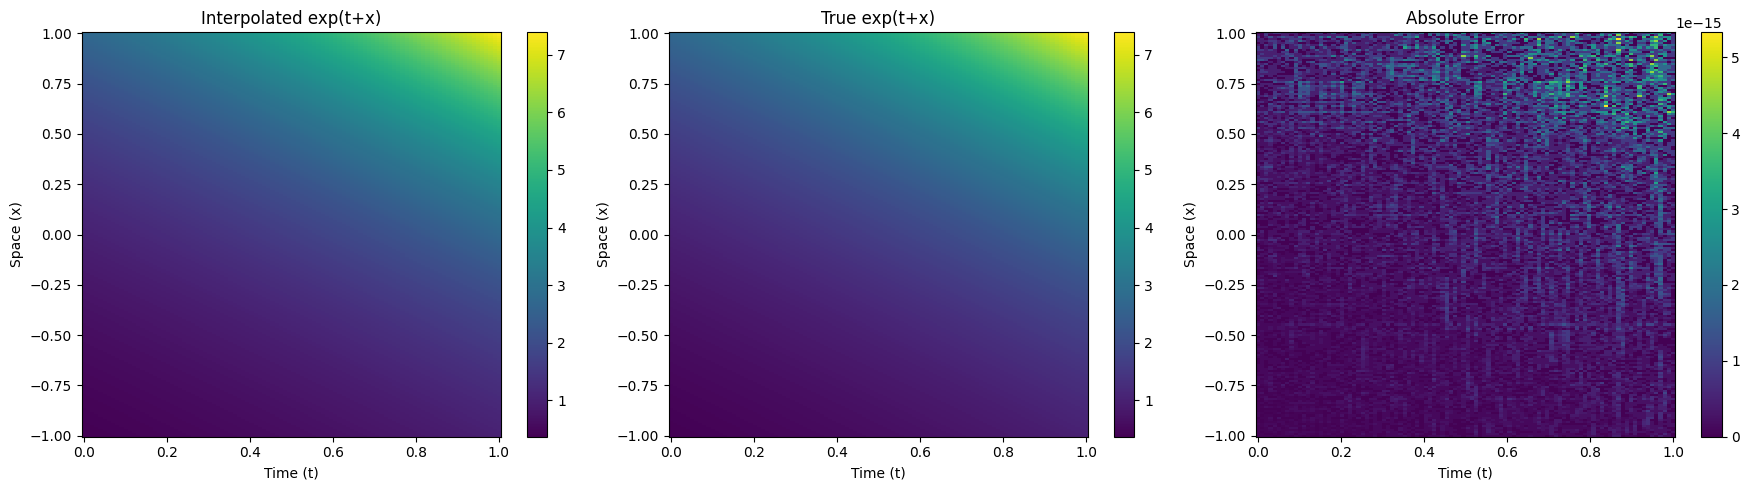

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

def test_spectral_interpolation():
    # Define domain
    t_domain = (0, 1)  # time from 0 to 1
    x_domain = (-1, 1) # space from -1 to 1
    
    # Number of points in each dimension for the interpolation
    Nt = 17  # time points
    Nx = 17  # space points
    
    # Create interpolator
    interpolator = SpectralInterpolationND(
        Ns=[Nt, Nx],  # number of points in each dimension
        bases=['chebyshev', 'chebyshev'],  # using Fourier basis for both dimensions
        domains=[t_domain, x_domain]  # domains for each dimension
    )
    
    # Create true solution at grid points
    t_grid, x_grid = interpolator.mesh
    true_values = torch.exp(t_grid + x_grid)
    
    # Set the interpolator's values to the true solution
    interpolator.values.data = true_values
    
    # Create evaluation points
    t_eval = torch.linspace(0, 1, 100)
    x_eval = torch.linspace(-1, 1, 200)
    T_eval, X_eval = torch.meshgrid(t_eval, x_eval, indexing='ij')
    points_eval = torch.stack([T_eval.flatten(), X_eval.flatten()], dim=-1)
    
    # Evaluate interpolation
    u_interp = interpolator(points_eval)
    u_interp = u_interp.reshape(T_eval.shape).detach()
    
    # Compute true solution at evaluation points
    u_true = torch.exp(T_eval + X_eval)
    
    # Compute error
    error = torch.abs(u_interp - u_true)
    max_error = torch.max(error).item()
    print(f"Maximum interpolation error: {max_error:.2e}")
    
    # Create plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot interpolated solution
    c1 = ax1.pcolormesh(T_eval.numpy(), X_eval.numpy(), u_interp.numpy(), 
                        shading='auto', cmap='viridis')
    ax1.set_xlabel('Time (t)')
    ax1.set_ylabel('Space (x)')
    ax1.set_title('Interpolated exp(t+x)')
    plt.colorbar(c1, ax=ax1)
    
    # Plot true solution
    c2 = ax2.pcolormesh(T_eval.numpy(), X_eval.numpy(), u_true.numpy(), 
                        shading='auto', cmap='viridis')
    ax2.set_xlabel('Time (t)')
    ax2.set_ylabel('Space (x)')
    ax2.set_title('True exp(t+x)')
    plt.colorbar(c2, ax=ax2)
    
    # Plot error
    c3 = ax3.pcolormesh(T_eval.numpy(), X_eval.numpy(), error.numpy(), 
                        shading='auto', cmap='viridis')
    ax3.set_xlabel('Time (t)')
    ax3.set_ylabel('Space (x)')
    ax3.set_title('Absolute Error')
    plt.colorbar(c3, ax=ax3)
    
    plt.tight_layout()
    return fig

# Run the test
if __name__ == "__main__":
    fig = test_spectral_interpolation()
    plt.show()

Now let's run gradient descent.

  0%|          | 116/100000 [00:01<19:35, 84.95it/s]

Epoch [100/100000], Loss: 8.066e-01


  0%|          | 215/100000 [00:02<18:48, 88.39it/s]

Epoch [200/100000], Loss: 3.888e-01


  0%|          | 307/100000 [00:03<18:49, 88.24it/s]

Epoch [300/100000], Loss: 2.403e-01


  0%|          | 413/100000 [00:04<18:20, 90.53it/s]

Epoch [400/100000], Loss: 1.667e-01


  1%|          | 515/100000 [00:05<17:08, 96.77it/s]

Epoch [500/100000], Loss: 1.230e-01


  1%|          | 616/100000 [00:06<17:57, 92.25it/s]

Epoch [600/100000], Loss: 9.424e-02


  1%|          | 715/100000 [00:07<19:05, 86.69it/s]

Epoch [700/100000], Loss: 7.409e-02


  1%|          | 818/100000 [00:08<18:12, 90.81it/s]

Epoch [800/100000], Loss: 5.942e-02


  1%|          | 918/100000 [00:10<17:51, 92.50it/s]

Epoch [900/100000], Loss: 4.845e-02


  1%|          | 1019/100000 [00:11<16:48, 98.19it/s]

Epoch [1000/100000], Loss: 4.008e-02


  1%|          | 1115/100000 [00:12<16:48, 98.08it/s] 

Epoch [1100/100000], Loss: 3.357e-02


  1%|          | 1215/100000 [00:13<17:32, 93.88it/s]

Epoch [1200/100000], Loss: 2.845e-02


  1%|▏         | 1315/100000 [00:14<17:37, 93.35it/s]

Epoch [1300/100000], Loss: 2.436e-02


  1%|▏         | 1415/100000 [00:15<17:34, 93.49it/s]

Epoch [1400/100000], Loss: 2.106e-02


  2%|▏         | 1515/100000 [00:16<17:27, 94.01it/s]

Epoch [1500/100000], Loss: 1.837e-02


  2%|▏         | 1618/100000 [00:17<16:43, 98.06it/s]

Epoch [1600/100000], Loss: 1.615e-02


  2%|▏         | 1712/100000 [00:18<19:12, 85.25it/s] 

Epoch [1700/100000], Loss: 1.430e-02


  2%|▏         | 1812/100000 [00:19<18:48, 86.99it/s]

Epoch [1800/100000], Loss: 1.276e-02


  2%|▏         | 1911/100000 [00:20<18:23, 88.91it/s]

Epoch [1900/100000], Loss: 1.145e-02


  2%|▏         | 2011/100000 [00:21<18:24, 88.69it/s]

Epoch [2000/100000], Loss: 1.033e-02


  2%|▏         | 2114/100000 [00:22<17:14, 94.60it/s] 

Epoch [2100/100000], Loss: 9.365e-03


  2%|▏         | 2215/100000 [00:23<18:12, 89.51it/s]

Epoch [2200/100000], Loss: 8.533e-03


  2%|▏         | 2309/100000 [00:25<18:11, 89.47it/s]

Epoch [2300/100000], Loss: 7.808e-03


  2%|▏         | 2412/100000 [00:26<18:17, 88.92it/s]

Epoch [2400/100000], Loss: 7.172e-03


  3%|▎         | 2511/100000 [00:27<18:09, 89.47it/s]

Epoch [2500/100000], Loss: 6.612e-03


  3%|▎         | 2610/100000 [00:28<16:40, 97.34it/s]

Epoch [2600/100000], Loss: 6.114e-03


  3%|▎         | 2719/100000 [00:29<16:06, 100.66it/s]

Epoch [2700/100000], Loss: 5.671e-03


  3%|▎         | 2810/100000 [00:30<18:08, 89.25it/s] 

Epoch [2800/100000], Loss: 5.274e-03


  3%|▎         | 2918/100000 [00:31<17:56, 90.22it/s]

Epoch [2900/100000], Loss: 4.917e-03


  3%|▎         | 3013/100000 [00:32<18:04, 89.44it/s]

Epoch [3000/100000], Loss: 4.595e-03


  3%|▎         | 3113/100000 [00:33<22:53, 70.53it/s]

Epoch [3100/100000], Loss: 4.302e-03


  3%|▎         | 3209/100000 [00:35<21:57, 73.49it/s]

Epoch [3200/100000], Loss: 4.036e-03


  3%|▎         | 3313/100000 [00:36<24:14, 66.48it/s]

Epoch [3300/100000], Loss: 3.793e-03


  3%|▎         | 3413/100000 [00:38<24:03, 66.91it/s]

Epoch [3400/100000], Loss: 3.570e-03


  4%|▎         | 3512/100000 [00:39<24:05, 66.77it/s]

Epoch [3500/100000], Loss: 3.366e-03


  4%|▎         | 3614/100000 [00:41<21:23, 75.11it/s]

Epoch [3600/100000], Loss: 3.177e-03


  4%|▎         | 3710/100000 [00:42<22:46, 70.45it/s]

Epoch [3700/100000], Loss: 3.003e-03


  4%|▍         | 3813/100000 [00:44<23:00, 69.69it/s]

Epoch [3800/100000], Loss: 2.842e-03


  4%|▍         | 3909/100000 [00:45<23:00, 69.62it/s]

Epoch [3900/100000], Loss: 2.692e-03


  4%|▍         | 4011/100000 [00:46<21:52, 73.11it/s]

Epoch [4000/100000], Loss: 2.552e-03


  4%|▍         | 4113/100000 [00:48<23:23, 68.32it/s]

Epoch [4100/100000], Loss: 2.422e-03


  4%|▍         | 4207/100000 [00:49<22:58, 69.49it/s]

Epoch [4200/100000], Loss: 2.301e-03


  4%|▍         | 4310/100000 [00:51<22:36, 70.54it/s]

Epoch [4300/100000], Loss: 2.187e-03


  4%|▍         | 4414/100000 [00:52<21:02, 75.69it/s]

Epoch [4400/100000], Loss: 2.081e-03


  5%|▍         | 4510/100000 [00:53<22:09, 71.80it/s]

Epoch [4500/100000], Loss: 1.981e-03


  5%|▍         | 4614/100000 [00:55<22:10, 71.67it/s]

Epoch [4600/100000], Loss: 1.887e-03


  5%|▍         | 4710/100000 [00:56<22:18, 71.18it/s]

Epoch [4700/100000], Loss: 1.798e-03


  5%|▍         | 4815/100000 [00:58<21:04, 75.28it/s]

Epoch [4800/100000], Loss: 1.715e-03


  5%|▍         | 4911/100000 [00:59<22:46, 69.59it/s]

Epoch [4900/100000], Loss: 1.636e-03


  5%|▌         | 5010/100000 [01:00<23:21, 67.76it/s]

Epoch [5000/100000], Loss: 1.562e-03


  5%|▌         | 5108/100000 [01:02<23:02, 68.65it/s]

Epoch [5100/100000], Loss: 1.491e-03


  5%|▌         | 5211/100000 [01:03<21:18, 74.12it/s]

Epoch [5200/100000], Loss: 1.425e-03


  5%|▌         | 5307/100000 [01:05<22:43, 69.45it/s]

Epoch [5300/100000], Loss: 1.362e-03


  5%|▌         | 5413/100000 [01:06<23:27, 67.20it/s]

Epoch [5400/100000], Loss: 1.302e-03


  6%|▌         | 5512/100000 [01:08<23:16, 67.64it/s]

Epoch [5500/100000], Loss: 1.245e-03


  6%|▌         | 5614/100000 [01:09<21:09, 74.35it/s]

Epoch [5600/100000], Loss: 1.191e-03


  6%|▌         | 5710/100000 [01:10<21:50, 71.96it/s]

Epoch [5700/100000], Loss: 1.140e-03


  6%|▌         | 5814/100000 [01:12<21:59, 71.37it/s]

Epoch [5800/100000], Loss: 1.091e-03


  6%|▌         | 5910/100000 [01:13<22:13, 70.57it/s]

Epoch [5900/100000], Loss: 1.045e-03


  6%|▌         | 6014/100000 [01:15<21:15, 73.71it/s]

Epoch [6000/100000], Loss: 1.001e-03


  6%|▌         | 6110/100000 [01:16<21:27, 72.92it/s]

Epoch [6100/100000], Loss: 9.585e-04


  6%|▌         | 6211/100000 [01:17<22:23, 69.82it/s]

Epoch [6200/100000], Loss: 9.184e-04


  6%|▋         | 6313/100000 [01:19<23:13, 67.22it/s]

Epoch [6300/100000], Loss: 8.801e-04


  6%|▋         | 6413/100000 [01:20<22:42, 68.67it/s]

Epoch [6400/100000], Loss: 8.435e-04


  7%|▋         | 6508/100000 [01:22<20:38, 75.47it/s]

Epoch [6500/100000], Loss: 8.086e-04


  7%|▋         | 6612/100000 [01:23<22:31, 69.11it/s]

Epoch [6600/100000], Loss: 7.753e-04


  7%|▋         | 6712/100000 [01:24<22:26, 69.29it/s]

Epoch [6700/100000], Loss: 7.435e-04


  7%|▋         | 6810/100000 [01:26<22:26, 69.22it/s]

Epoch [6800/100000], Loss: 7.130e-04


  7%|▋         | 6912/100000 [01:27<20:31, 75.59it/s]

Epoch [6900/100000], Loss: 6.840e-04


  7%|▋         | 7012/100000 [01:29<22:20, 69.39it/s]

Epoch [7000/100000], Loss: 6.561e-04


  7%|▋         | 7113/100000 [01:30<22:23, 69.15it/s]

Epoch [7100/100000], Loss: 6.295e-04


  7%|▋         | 7213/100000 [01:32<22:24, 68.99it/s]

Epoch [7200/100000], Loss: 6.041e-04


  7%|▋         | 7314/100000 [01:33<20:43, 74.53it/s]

Epoch [7300/100000], Loss: 5.797e-04


  7%|▋         | 7413/100000 [01:34<22:38, 68.16it/s]

Epoch [7400/100000], Loss: 5.564e-04


  8%|▊         | 7513/100000 [01:36<22:20, 69.01it/s]

Epoch [7500/100000], Loss: 5.340e-04


  8%|▊         | 7609/100000 [01:37<22:14, 69.24it/s]

Epoch [7600/100000], Loss: 5.126e-04


  8%|▊         | 7712/100000 [01:39<20:18, 75.71it/s]

Epoch [7700/100000], Loss: 4.921e-04


  8%|▊         | 7808/100000 [01:40<21:33, 71.30it/s]

Epoch [7800/100000], Loss: 4.725e-04


  8%|▊         | 7907/100000 [01:41<22:24, 68.50it/s]

Epoch [7900/100000], Loss: 4.537e-04


  8%|▊         | 8013/100000 [01:43<22:03, 69.52it/s]

Epoch [8000/100000], Loss: 4.356e-04


  8%|▊         | 8108/100000 [01:44<20:34, 74.42it/s]

Epoch [8100/100000], Loss: 4.183e-04


  8%|▊         | 8208/100000 [01:46<22:01, 69.46it/s]

Epoch [8200/100000], Loss: 4.017e-04


  8%|▊         | 8308/100000 [01:47<21:55, 69.71it/s]

Epoch [8300/100000], Loss: 3.858e-04


  8%|▊         | 8409/100000 [01:48<22:00, 69.36it/s]

Epoch [8400/100000], Loss: 3.706e-04


  9%|▊         | 8510/100000 [01:50<20:32, 74.23it/s]

Epoch [8500/100000], Loss: 3.560e-04


  9%|▊         | 8614/100000 [01:51<21:35, 70.53it/s]

Epoch [8600/100000], Loss: 3.419e-04


  9%|▊         | 8709/100000 [01:53<22:25, 67.87it/s]

Epoch [8700/100000], Loss: 3.285e-04


  9%|▉         | 8809/100000 [01:54<21:46, 69.79it/s]

Epoch [8800/100000], Loss: 3.155e-04


  9%|▉         | 8908/100000 [01:55<20:03, 75.67it/s]

Epoch [8900/100000], Loss: 3.031e-04


  9%|▉         | 9012/100000 [01:57<21:31, 70.45it/s]

Epoch [9000/100000], Loss: 2.912e-04


  9%|▉         | 9108/100000 [01:58<21:27, 70.61it/s]

Epoch [9100/100000], Loss: 2.798e-04


  9%|▉         | 9212/100000 [02:00<21:11, 71.40it/s]

Epoch [9200/100000], Loss: 2.688e-04


  9%|▉         | 9308/100000 [02:01<19:56, 75.82it/s]

Epoch [9300/100000], Loss: 2.583e-04


  9%|▉         | 9412/100000 [02:02<21:16, 70.97it/s]

Epoch [9400/100000], Loss: 2.482e-04


 10%|▉         | 9508/100000 [02:04<21:30, 70.13it/s]

Epoch [9500/100000], Loss: 2.385e-04


 10%|▉         | 9610/100000 [02:05<21:22, 70.46it/s]

Epoch [9600/100000], Loss: 2.292e-04


 10%|▉         | 9714/100000 [02:07<19:55, 75.54it/s]

Epoch [9700/100000], Loss: 2.202e-04


 10%|▉         | 9808/100000 [02:08<23:03, 65.19it/s]

Epoch [9800/100000], Loss: 2.116e-04


 10%|▉         | 9913/100000 [02:10<23:31, 63.84it/s]

Epoch [9900/100000], Loss: 2.034e-04


 10%|█         | 10012/100000 [02:11<21:58, 68.23it/s]

Epoch [10000/100000], Loss: 1.955e-04


 10%|█         | 10108/100000 [02:13<19:57, 75.09it/s]

Epoch [10100/100000], Loss: 1.878e-04


 10%|█         | 10211/100000 [02:14<21:45, 68.76it/s]

Epoch [10200/100000], Loss: 1.805e-04


 10%|█         | 10310/100000 [02:15<22:01, 67.86it/s]

Epoch [10300/100000], Loss: 1.735e-04


 10%|█         | 10409/100000 [02:17<22:04, 67.66it/s]

Epoch [10400/100000], Loss: 1.668e-04


 11%|█         | 10513/100000 [02:18<19:57, 74.70it/s]

Epoch [10500/100000], Loss: 1.603e-04


 11%|█         | 10609/100000 [02:20<21:35, 69.00it/s]

Epoch [10600/100000], Loss: 1.541e-04


 11%|█         | 10708/100000 [02:21<21:34, 68.98it/s]

Epoch [10700/100000], Loss: 1.481e-04


 11%|█         | 10812/100000 [02:23<21:25, 69.37it/s]

Epoch [10800/100000], Loss: 1.423e-04


 11%|█         | 10908/100000 [02:24<20:23, 72.79it/s]

Epoch [10900/100000], Loss: 1.368e-04


 11%|█         | 11012/100000 [02:25<20:45, 71.45it/s]

Epoch [11000/100000], Loss: 1.315e-04


 11%|█         | 11107/100000 [02:27<21:32, 68.76it/s]

Epoch [11100/100000], Loss: 1.264e-04


 11%|█         | 11211/100000 [02:28<20:41, 71.54it/s]

Epoch [11200/100000], Loss: 1.215e-04


 11%|█▏        | 11315/100000 [02:30<20:00, 73.89it/s]

Epoch [11300/100000], Loss: 1.168e-04


 11%|█▏        | 11411/100000 [02:31<19:19, 76.42it/s]

Epoch [11400/100000], Loss: 1.123e-04


 12%|█▏        | 11507/100000 [02:32<20:58, 70.30it/s]

Epoch [11500/100000], Loss: 1.079e-04


 12%|█▏        | 11611/100000 [02:34<20:56, 70.37it/s]

Epoch [11600/100000], Loss: 1.037e-04


 12%|█▏        | 11713/100000 [02:35<21:18, 69.05it/s]

Epoch [11700/100000], Loss: 9.972e-05


 12%|█▏        | 11808/100000 [02:37<19:21, 75.91it/s]

Epoch [11800/100000], Loss: 9.586e-05


 12%|█▏        | 11912/100000 [02:38<20:31, 71.52it/s]

Epoch [11900/100000], Loss: 9.215e-05


 12%|█▏        | 12008/100000 [02:39<20:38, 71.07it/s]

Epoch [12000/100000], Loss: 8.858e-05


 12%|█▏        | 12112/100000 [02:41<20:49, 70.35it/s]

Epoch [12100/100000], Loss: 8.516e-05


 12%|█▏        | 12208/100000 [02:42<19:43, 74.18it/s]

Epoch [12200/100000], Loss: 8.186e-05


 12%|█▏        | 12310/100000 [02:44<21:01, 69.49it/s]

Epoch [12300/100000], Loss: 7.870e-05


 12%|█▏        | 12410/100000 [02:45<20:19, 71.82it/s]

Epoch [12400/100000], Loss: 7.566e-05


 13%|█▎        | 12514/100000 [02:46<20:17, 71.85it/s]

Epoch [12500/100000], Loss: 7.273e-05


 13%|█▎        | 12610/100000 [02:48<19:28, 74.80it/s]

Epoch [12600/100000], Loss: 6.992e-05


 13%|█▎        | 12714/100000 [02:49<20:43, 70.18it/s]

Epoch [12700/100000], Loss: 6.722e-05


 13%|█▎        | 12810/100000 [02:50<20:26, 71.10it/s]

Epoch [12800/100000], Loss: 6.462e-05


 13%|█▎        | 12914/100000 [02:52<20:27, 70.95it/s]

Epoch [12900/100000], Loss: 6.213e-05


 13%|█▎        | 13010/100000 [02:53<19:03, 76.10it/s]

Epoch [13000/100000], Loss: 5.973e-05


 13%|█▎        | 13112/100000 [02:55<21:01, 68.85it/s]

Epoch [13100/100000], Loss: 5.742e-05


 13%|█▎        | 13210/100000 [02:56<21:45, 66.50it/s]

Epoch [13200/100000], Loss: 5.520e-05


 13%|█▎        | 13309/100000 [02:58<21:25, 67.46it/s]

Epoch [13300/100000], Loss: 5.307e-05


 13%|█▎        | 13411/100000 [02:59<19:50, 72.70it/s]

Epoch [13400/100000], Loss: 5.102e-05


 14%|█▎        | 13507/100000 [03:00<20:39, 69.79it/s]

Epoch [13500/100000], Loss: 4.905e-05


 14%|█▎        | 13607/100000 [03:02<21:39, 66.49it/s]

Epoch [13600/100000], Loss: 4.716e-05


 14%|█▎        | 13712/100000 [03:04<21:44, 66.13it/s]

Epoch [13700/100000], Loss: 4.534e-05


 14%|█▍        | 13811/100000 [03:05<20:30, 70.05it/s]

Epoch [13800/100000], Loss: 4.359e-05


 14%|█▍        | 13907/100000 [03:06<19:12, 74.69it/s]

Epoch [13900/100000], Loss: 4.191e-05


 14%|█▍        | 14009/100000 [03:08<20:36, 69.53it/s]

Epoch [14000/100000], Loss: 4.029e-05


 14%|█▍        | 14111/100000 [03:09<20:55, 68.43it/s]

Epoch [14100/100000], Loss: 3.874e-05


 14%|█▍        | 14213/100000 [03:11<20:47, 68.79it/s]

Epoch [14200/100000], Loss: 3.724e-05


 14%|█▍        | 14308/100000 [03:12<18:54, 75.56it/s]

Epoch [14300/100000], Loss: 3.581e-05


 14%|█▍        | 14408/100000 [03:13<20:43, 68.85it/s]

Epoch [14400/100000], Loss: 3.443e-05


 15%|█▍        | 14506/100000 [03:15<20:56, 68.02it/s]

Epoch [14500/100000], Loss: 3.310e-05


 15%|█▍        | 14614/100000 [03:16<20:13, 70.39it/s]

Epoch [14600/100000], Loss: 3.182e-05


 15%|█▍        | 14710/100000 [03:18<19:16, 73.77it/s]

Epoch [14700/100000], Loss: 3.060e-05


 15%|█▍        | 14813/100000 [03:19<20:15, 70.11it/s]

Epoch [14800/100000], Loss: 2.942e-05


 15%|█▍        | 14907/100000 [03:20<20:33, 69.00it/s]

Epoch [14900/100000], Loss: 2.828e-05


 15%|█▌        | 15007/100000 [03:22<20:29, 69.14it/s]

Epoch [15000/100000], Loss: 2.719e-05


 15%|█▌        | 15112/100000 [03:23<19:00, 74.46it/s]

Epoch [15100/100000], Loss: 2.614e-05


 15%|█▌        | 15213/100000 [03:25<21:00, 67.25it/s]

Epoch [15200/100000], Loss: 2.513e-05


 15%|█▌        | 15312/100000 [03:26<20:49, 67.78it/s]

Epoch [15300/100000], Loss: 2.417e-05


 15%|█▌        | 15413/100000 [03:28<20:44, 67.94it/s]

Epoch [15400/100000], Loss: 2.323e-05


 16%|█▌        | 15512/100000 [03:29<19:22, 72.71it/s]

Epoch [15500/100000], Loss: 2.234e-05


 16%|█▌        | 15608/100000 [03:30<20:15, 69.43it/s]

Epoch [15600/100000], Loss: 2.148e-05


 16%|█▌        | 15711/100000 [03:32<20:08, 69.73it/s]

Epoch [15700/100000], Loss: 2.065e-05


 16%|█▌        | 15813/100000 [03:33<20:11, 69.46it/s]

Epoch [15800/100000], Loss: 1.985e-05


 16%|█▌        | 15913/100000 [03:35<19:05, 73.39it/s]

Epoch [15900/100000], Loss: 1.909e-05


 16%|█▌        | 16009/100000 [03:36<19:25, 72.07it/s]

Epoch [16000/100000], Loss: 1.835e-05


 16%|█▌        | 16113/100000 [03:38<19:58, 69.97it/s]

Epoch [16100/100000], Loss: 1.765e-05


 16%|█▌        | 16207/100000 [03:39<19:55, 70.10it/s]

Epoch [16200/100000], Loss: 1.697e-05


 16%|█▋        | 16313/100000 [03:40<18:51, 73.94it/s]

Epoch [16300/100000], Loss: 1.631e-05


 16%|█▋        | 16409/100000 [03:42<19:46, 70.46it/s]

Epoch [16400/100000], Loss: 1.568e-05


 17%|█▋        | 16511/100000 [03:43<20:12, 68.86it/s]

Epoch [16500/100000], Loss: 1.508e-05


 17%|█▋        | 16611/100000 [03:45<20:24, 68.09it/s]

Epoch [16600/100000], Loss: 1.450e-05


 17%|█▋        | 16710/100000 [03:46<19:34, 70.95it/s]

Epoch [16700/100000], Loss: 1.394e-05


 17%|█▋        | 16814/100000 [03:47<18:56, 73.22it/s]

Epoch [16800/100000], Loss: 1.340e-05


 17%|█▋        | 16907/100000 [03:49<20:38, 67.10it/s]

Epoch [16900/100000], Loss: 1.289e-05


 17%|█▋        | 17011/100000 [03:50<19:44, 70.04it/s]

Epoch [17000/100000], Loss: 1.239e-05


 17%|█▋        | 17113/100000 [03:52<19:39, 70.24it/s]

Epoch [17100/100000], Loss: 1.191e-05


 17%|█▋        | 17209/100000 [03:53<18:12, 75.79it/s]

Epoch [17200/100000], Loss: 1.145e-05


 17%|█▋        | 17311/100000 [03:55<19:34, 70.39it/s]

Epoch [17300/100000], Loss: 1.101e-05


 17%|█▋        | 17413/100000 [03:56<19:58, 68.93it/s]

Epoch [17400/100000], Loss: 1.059e-05


 18%|█▊        | 17509/100000 [03:57<19:37, 70.06it/s]

Epoch [17500/100000], Loss: 1.018e-05


 18%|█▊        | 17613/100000 [03:59<18:11, 75.47it/s]

Epoch [17600/100000], Loss: 9.787e-06


 18%|█▊        | 17711/100000 [04:00<19:49, 69.17it/s]

Epoch [17700/100000], Loss: 9.410e-06


 18%|█▊        | 17810/100000 [04:02<20:24, 67.11it/s]

Epoch [17800/100000], Loss: 9.048e-06


 18%|█▊        | 17908/100000 [04:03<20:10, 67.80it/s]

Epoch [17900/100000], Loss: 8.699e-06


 18%|█▊        | 18008/100000 [04:04<18:24, 74.22it/s]

Epoch [18000/100000], Loss: 8.364e-06


 18%|█▊        | 18113/100000 [04:06<20:03, 68.06it/s]

Epoch [18100/100000], Loss: 8.042e-06


 18%|█▊        | 18212/100000 [04:07<19:57, 68.29it/s]

Epoch [18200/100000], Loss: 7.732e-06


 18%|█▊        | 18312/100000 [04:09<19:58, 68.16it/s]

Epoch [18300/100000], Loss: 7.434e-06


 18%|█▊        | 18411/100000 [04:10<18:27, 73.69it/s]

Epoch [18400/100000], Loss: 7.148e-06


 19%|█▊        | 18512/100000 [04:12<20:11, 67.24it/s]

Epoch [18500/100000], Loss: 6.872e-06


 19%|█▊        | 18612/100000 [04:13<19:55, 68.10it/s]

Epoch [18600/100000], Loss: 6.608e-06


 19%|█▊        | 18713/100000 [04:15<19:58, 67.83it/s]

Epoch [18700/100000], Loss: 6.353e-06


 19%|█▉        | 18811/100000 [04:16<17:59, 75.22it/s]

Epoch [18800/100000], Loss: 6.108e-06


 19%|█▉        | 18909/100000 [04:18<20:19, 66.49it/s]

Epoch [18900/100000], Loss: 5.873e-06


 19%|█▉        | 19008/100000 [04:19<20:11, 66.83it/s]

Epoch [19000/100000], Loss: 5.647e-06


 19%|█▉        | 19107/100000 [04:20<19:44, 68.28it/s]

Epoch [19100/100000], Loss: 5.429e-06


 19%|█▉        | 19207/100000 [04:22<18:53, 71.29it/s]

Epoch [19200/100000], Loss: 5.220e-06


 19%|█▉        | 19308/100000 [04:23<19:33, 68.78it/s]

Epoch [19300/100000], Loss: 5.019e-06


 19%|█▉        | 19408/100000 [04:25<19:52, 67.60it/s]

Epoch [19400/100000], Loss: 4.826e-06


 20%|█▉        | 19507/100000 [04:26<19:37, 68.37it/s]

Epoch [19500/100000], Loss: 4.640e-06


 20%|█▉        | 19608/100000 [04:28<18:26, 72.66it/s]

Epoch [19600/100000], Loss: 4.461e-06


 20%|█▉        | 19711/100000 [04:29<19:12, 69.69it/s]

Epoch [19700/100000], Loss: 4.289e-06


 20%|█▉        | 19813/100000 [04:31<19:18, 69.22it/s]

Epoch [19800/100000], Loss: 4.124e-06


 20%|█▉        | 19908/100000 [04:32<19:03, 70.02it/s]

Epoch [19900/100000], Loss: 3.965e-06


 20%|██        | 20009/100000 [04:33<18:59, 70.21it/s]

Epoch [20000/100000], Loss: 3.813e-06


 20%|██        | 20108/100000 [04:35<19:29, 68.30it/s]

Epoch [20100/100000], Loss: 3.666e-06


 20%|██        | 20208/100000 [04:36<19:18, 68.86it/s]

Epoch [20200/100000], Loss: 3.525e-06


 20%|██        | 20308/100000 [04:38<21:39, 61.34it/s]

Epoch [20300/100000], Loss: 3.389e-06


 20%|██        | 20411/100000 [04:39<17:43, 74.85it/s]

Epoch [20400/100000], Loss: 3.258e-06


 21%|██        | 20511/100000 [04:41<18:52, 70.21it/s]

Epoch [20500/100000], Loss: 3.133e-06


 21%|██        | 20607/100000 [04:42<19:07, 69.16it/s]

Epoch [20600/100000], Loss: 3.012e-06


 21%|██        | 20714/100000 [04:44<18:45, 70.44it/s]

Epoch [20700/100000], Loss: 2.896e-06


 21%|██        | 20810/100000 [04:45<19:14, 68.61it/s]

Epoch [20800/100000], Loss: 2.785e-06


 21%|██        | 20908/100000 [04:46<19:28, 67.68it/s]

Epoch [20900/100000], Loss: 2.677e-06


 21%|██        | 21013/100000 [04:48<19:19, 68.14it/s]

Epoch [21000/100000], Loss: 2.574e-06


 21%|██        | 21111/100000 [04:49<20:05, 65.44it/s]

Epoch [21100/100000], Loss: 2.475e-06


 21%|██        | 21214/100000 [04:51<16:58, 77.33it/s]

Epoch [21200/100000], Loss: 2.380e-06


 21%|██▏       | 21310/100000 [04:52<18:27, 71.02it/s]

Epoch [21300/100000], Loss: 2.288e-06


 21%|██▏       | 21414/100000 [04:53<18:16, 71.69it/s]

Epoch [21400/100000], Loss: 2.200e-06


 22%|██▏       | 21510/100000 [04:55<18:24, 71.06it/s]

Epoch [21500/100000], Loss: 2.115e-06


 22%|██▏       | 21606/100000 [04:56<18:57, 68.89it/s]

Epoch [21600/100000], Loss: 2.034e-06


 22%|██▏       | 21709/100000 [04:58<18:38, 69.97it/s]

Epoch [21700/100000], Loss: 1.955e-06


 22%|██▏       | 21813/100000 [04:59<18:50, 69.14it/s]

Epoch [21800/100000], Loss: 1.880e-06


 22%|██▏       | 21907/100000 [05:00<18:53, 68.88it/s]

Epoch [21900/100000], Loss: 1.808e-06


 22%|██▏       | 22008/100000 [05:02<17:34, 73.96it/s]

Epoch [22000/100000], Loss: 1.738e-06


 22%|██▏       | 22108/100000 [05:03<18:40, 69.52it/s]

Epoch [22100/100000], Loss: 1.671e-06


 22%|██▏       | 22211/100000 [05:05<18:46, 69.06it/s]

Epoch [22200/100000], Loss: 1.607e-06


 22%|██▏       | 22310/100000 [05:06<18:51, 68.65it/s]

Epoch [22300/100000], Loss: 1.545e-06


 22%|██▏       | 22402/100000 [05:07<17:53, 72.30it/s]

Epoch [22400/100000], Loss: 1.485e-06


 23%|██▎       | 22507/100000 [05:09<18:44, 68.88it/s]

Epoch [22500/100000], Loss: 1.428e-06


 23%|██▎       | 22608/100000 [05:11<19:17, 66.86it/s]

Epoch [22600/100000], Loss: 1.373e-06


 23%|██▎       | 22713/100000 [05:12<19:08, 67.30it/s]

Epoch [22700/100000], Loss: 1.320e-06


 23%|██▎       | 22811/100000 [05:13<17:29, 73.58it/s]

Epoch [22800/100000], Loss: 1.269e-06


 23%|██▎       | 22907/100000 [05:15<18:15, 70.34it/s]

Epoch [22900/100000], Loss: 1.221e-06


 23%|██▎       | 23011/100000 [05:16<18:00, 71.22it/s]

Epoch [23000/100000], Loss: 1.174e-06


 23%|██▎       | 23107/100000 [05:18<18:03, 70.98it/s]

Epoch [23100/100000], Loss: 1.128e-06


 23%|██▎       | 23211/100000 [05:19<16:27, 77.75it/s]

Epoch [23200/100000], Loss: 1.085e-06


 23%|██▎       | 23312/100000 [05:20<17:02, 75.02it/s]

Epoch [23300/100000], Loss: 1.043e-06


 23%|██▎       | 23409/100000 [05:22<17:18, 73.77it/s]

Epoch [23400/100000], Loss: 1.003e-06


 24%|██▎       | 23507/100000 [05:23<19:03, 66.87it/s]

Epoch [23500/100000], Loss: 9.643e-07


 24%|██▎       | 23609/100000 [05:25<17:58, 70.80it/s]

Epoch [23600/100000], Loss: 9.272e-07


 24%|██▎       | 23712/100000 [05:26<18:24, 69.09it/s]

Epoch [23700/100000], Loss: 8.915e-07


 24%|██▍       | 23810/100000 [05:27<18:01, 70.43it/s]

Epoch [23800/100000], Loss: 8.572e-07


 24%|██▍       | 23909/100000 [05:29<19:11, 66.07it/s]

Epoch [23900/100000], Loss: 8.241e-07


 24%|██▍       | 24012/100000 [05:30<17:08, 73.87it/s]

Epoch [24000/100000], Loss: 7.924e-07


 24%|██▍       | 24108/100000 [05:32<17:46, 71.16it/s]

Epoch [24100/100000], Loss: 7.619e-07


 24%|██▍       | 24207/100000 [05:33<17:54, 70.51it/s]

Epoch [24200/100000], Loss: 7.325e-07


 24%|██▍       | 24311/100000 [05:35<18:34, 67.91it/s]

Epoch [24300/100000], Loss: 7.043e-07


 24%|██▍       | 24414/100000 [05:36<16:52, 74.64it/s]

Epoch [24400/100000], Loss: 6.772e-07


 25%|██▍       | 24510/100000 [05:37<17:35, 71.49it/s]

Epoch [24500/100000], Loss: 6.511e-07


 25%|██▍       | 24613/100000 [05:39<17:59, 69.80it/s]

Epoch [24600/100000], Loss: 6.260e-07


 25%|██▍       | 24709/100000 [05:40<17:41, 70.96it/s]

Epoch [24700/100000], Loss: 6.019e-07


 25%|██▍       | 24813/100000 [05:42<16:48, 74.58it/s]

Epoch [24800/100000], Loss: 5.788e-07


 25%|██▍       | 24909/100000 [05:43<17:17, 72.34it/s]

Epoch [24900/100000], Loss: 5.565e-07


 25%|██▌       | 25010/100000 [05:44<18:03, 69.22it/s]

Epoch [25000/100000], Loss: 5.350e-07


 25%|██▌       | 25110/100000 [05:46<17:31, 71.21it/s]

Epoch [25100/100000], Loss: 5.144e-07


 25%|██▌       | 25214/100000 [05:47<17:16, 72.17it/s]

Epoch [25200/100000], Loss: 4.946e-07


 25%|██▌       | 25310/100000 [05:49<16:42, 74.50it/s]

Epoch [25300/100000], Loss: 4.756e-07


 25%|██▌       | 25413/100000 [05:50<18:16, 68.04it/s]

Epoch [25400/100000], Loss: 4.573e-07


 26%|██▌       | 25513/100000 [05:52<18:01, 68.86it/s]

Epoch [25500/100000], Loss: 4.396e-07


 26%|██▌       | 25608/100000 [05:53<17:21, 71.42it/s]

Epoch [25600/100000], Loss: 4.227e-07


 26%|██▌       | 25712/100000 [05:54<16:46, 73.84it/s]

Epoch [25700/100000], Loss: 4.064e-07


 26%|██▌       | 25808/100000 [05:56<17:06, 72.27it/s]

Epoch [25800/100000], Loss: 3.908e-07


 26%|██▌       | 25908/100000 [05:57<17:54, 68.95it/s]

Epoch [25900/100000], Loss: 3.757e-07


 26%|██▌       | 26012/100000 [05:59<16:59, 72.56it/s]

Epoch [26000/100000], Loss: 3.613e-07


 26%|██▌       | 26108/100000 [06:00<16:43, 73.67it/s]

Epoch [26100/100000], Loss: 3.473e-07


 26%|██▌       | 26213/100000 [06:01<17:52, 68.82it/s]

Epoch [26200/100000], Loss: 3.340e-07


 26%|██▋       | 26307/100000 [06:03<17:51, 68.80it/s]

Epoch [26300/100000], Loss: 3.211e-07


 26%|██▋       | 26412/100000 [06:04<16:30, 74.31it/s]

Epoch [26400/100000], Loss: 3.087e-07


 27%|██▋       | 26508/100000 [06:06<17:20, 70.63it/s]

Epoch [26500/100000], Loss: 2.969e-07


 27%|██▋       | 26611/100000 [06:07<17:48, 68.70it/s]

Epoch [26600/100000], Loss: 2.854e-07


 27%|██▋       | 26713/100000 [06:08<17:35, 69.47it/s]

Epoch [26700/100000], Loss: 2.744e-07


 27%|██▋       | 26814/100000 [06:10<16:02, 76.07it/s]

Epoch [26800/100000], Loss: 2.639e-07


 27%|██▋       | 26910/100000 [06:11<17:14, 70.65it/s]

Epoch [26900/100000], Loss: 2.537e-07


 27%|██▋       | 27009/100000 [06:13<17:25, 69.83it/s]

Epoch [27000/100000], Loss: 2.439e-07


 27%|██▋       | 27108/100000 [06:14<17:48, 68.20it/s]

Epoch [27100/100000], Loss: 2.345e-07


 27%|██▋       | 27211/100000 [06:15<16:24, 73.95it/s]

Epoch [27200/100000], Loss: 2.255e-07


 27%|██▋       | 27306/100000 [06:17<17:35, 68.87it/s]

Epoch [27300/100000], Loss: 2.168e-07


 27%|██▋       | 27408/100000 [06:18<17:41, 68.41it/s]

Epoch [27400/100000], Loss: 2.085e-07


 28%|██▊       | 27508/100000 [06:20<17:46, 67.99it/s]

Epoch [27500/100000], Loss: 2.004e-07


 28%|██▊       | 27611/100000 [06:21<16:32, 72.97it/s]

Epoch [27600/100000], Loss: 1.927e-07


 28%|██▊       | 27711/100000 [06:23<17:26, 69.05it/s]

Epoch [27700/100000], Loss: 1.853e-07


 28%|██▊       | 27811/100000 [06:24<17:26, 68.95it/s]

Epoch [27800/100000], Loss: 1.782e-07


 28%|██▊       | 27910/100000 [06:25<17:32, 68.52it/s]

Epoch [27900/100000], Loss: 1.713e-07


 28%|██▊       | 28010/100000 [06:27<16:27, 72.90it/s]

Epoch [28000/100000], Loss: 1.647e-07


 28%|██▊       | 28114/100000 [06:28<16:50, 71.15it/s]

Epoch [28100/100000], Loss: 1.584e-07


 28%|██▊       | 28210/100000 [06:30<16:42, 71.60it/s]

Epoch [28200/100000], Loss: 1.523e-07


 28%|██▊       | 28306/100000 [06:31<16:49, 71.01it/s]

Epoch [28300/100000], Loss: 1.464e-07


 28%|██▊       | 28410/100000 [06:32<16:07, 74.03it/s]

Epoch [28400/100000], Loss: 1.408e-07


 29%|██▊       | 28514/100000 [06:34<16:57, 70.28it/s]

Epoch [28500/100000], Loss: 1.353e-07


 29%|██▊       | 28610/100000 [06:35<16:57, 70.16it/s]

Epoch [28600/100000], Loss: 1.301e-07


 29%|██▊       | 28714/100000 [06:37<16:34, 71.68it/s]

Epoch [28700/100000], Loss: 1.251e-07


 29%|██▉       | 28810/100000 [06:38<15:59, 74.22it/s]

Epoch [28800/100000], Loss: 1.203e-07


 29%|██▉       | 28914/100000 [06:39<16:33, 71.53it/s]

Epoch [28900/100000], Loss: 1.157e-07


 29%|██▉       | 29011/100000 [06:41<17:21, 68.18it/s]

Epoch [29000/100000], Loss: 1.112e-07


 29%|██▉       | 29112/100000 [06:42<16:50, 70.13it/s]

Epoch [29100/100000], Loss: 1.069e-07


 29%|██▉       | 29208/100000 [06:44<16:00, 73.69it/s]

Epoch [29200/100000], Loss: 1.028e-07


 29%|██▉       | 29312/100000 [06:45<16:36, 70.91it/s]

Epoch [29300/100000], Loss: 9.885e-08


 29%|██▉       | 29408/100000 [06:46<16:44, 70.27it/s]

Epoch [29400/100000], Loss: 9.504e-08


 30%|██▉       | 29512/100000 [06:48<16:31, 71.13it/s]

Epoch [29500/100000], Loss: 9.138e-08


 30%|██▉       | 29608/100000 [06:49<15:42, 74.69it/s]

Epoch [29600/100000], Loss: 8.786e-08


 30%|██▉       | 29712/100000 [06:51<16:39, 70.34it/s]

Epoch [29700/100000], Loss: 8.448e-08


 30%|██▉       | 29808/100000 [06:52<16:37, 70.35it/s]

Epoch [29800/100000], Loss: 8.123e-08


 30%|██▉       | 29910/100000 [06:53<17:10, 68.00it/s]

Epoch [29900/100000], Loss: 7.810e-08


 30%|███       | 30011/100000 [06:55<15:48, 73.82it/s]

Epoch [30000/100000], Loss: 7.509e-08


 30%|███       | 30107/100000 [06:56<16:38, 69.98it/s]

Epoch [30100/100000], Loss: 7.220e-08


 30%|███       | 30213/100000 [06:58<17:13, 67.54it/s]

Epoch [30200/100000], Loss: 6.942e-08


 30%|███       | 30312/100000 [06:59<17:15, 67.28it/s]

Epoch [30300/100000], Loss: 6.674e-08


 30%|███       | 30412/100000 [07:01<16:05, 72.04it/s]

Epoch [30400/100000], Loss: 6.417e-08


 31%|███       | 30508/100000 [07:02<16:17, 71.07it/s]

Epoch [30500/100000], Loss: 6.170e-08


 31%|███       | 30609/100000 [07:04<17:25, 66.40it/s]

Epoch [30600/100000], Loss: 5.933e-08


 31%|███       | 30708/100000 [07:05<17:16, 66.85it/s]

Epoch [30700/100000], Loss: 5.704e-08


 31%|███       | 30814/100000 [07:07<16:46, 68.76it/s]

Epoch [30800/100000], Loss: 5.484e-08


 31%|███       | 30910/100000 [07:08<15:52, 72.54it/s]

Epoch [30900/100000], Loss: 5.273e-08


 31%|███       | 31010/100000 [07:09<17:29, 65.76it/s]

Epoch [31000/100000], Loss: 5.070e-08


 31%|███       | 31111/100000 [07:11<16:31, 69.47it/s]

Epoch [31100/100000], Loss: 4.875e-08


 31%|███       | 31210/100000 [07:12<16:43, 68.56it/s]

Epoch [31200/100000], Loss: 4.687e-08


 31%|███▏      | 31313/100000 [07:14<15:31, 73.77it/s]

Epoch [31300/100000], Loss: 4.507e-08


 31%|███▏      | 31408/100000 [07:15<16:17, 70.19it/s]

Epoch [31400/100000], Loss: 4.333e-08


 32%|███▏      | 31512/100000 [07:17<16:15, 70.23it/s]

Epoch [31500/100000], Loss: 4.166e-08


 32%|███▏      | 31611/100000 [07:18<17:10, 66.37it/s]

Epoch [31600/100000], Loss: 4.006e-08


 32%|███▏      | 31707/100000 [07:20<15:49, 71.92it/s]

Epoch [31700/100000], Loss: 3.851e-08


 32%|███▏      | 31807/100000 [07:21<16:44, 67.90it/s]

Epoch [31800/100000], Loss: 3.703e-08


 32%|███▏      | 31909/100000 [07:22<16:47, 67.55it/s]

Epoch [31900/100000], Loss: 3.561e-08


 32%|███▏      | 32008/100000 [07:24<17:03, 66.46it/s]

Epoch [32000/100000], Loss: 3.423e-08


 32%|███▏      | 32111/100000 [07:25<14:52, 76.11it/s]

Epoch [32100/100000], Loss: 3.292e-08


 32%|███▏      | 32207/100000 [07:27<16:35, 68.09it/s]

Epoch [32200/100000], Loss: 3.165e-08


 32%|███▏      | 32308/100000 [07:28<16:11, 69.69it/s]

Epoch [32300/100000], Loss: 3.043e-08


 32%|███▏      | 32408/100000 [07:30<17:15, 65.26it/s]

Epoch [32400/100000], Loss: 2.926e-08


 33%|███▎      | 32510/100000 [07:31<14:46, 76.14it/s]

Epoch [32500/100000], Loss: 2.813e-08


 33%|███▎      | 32613/100000 [07:33<16:59, 66.11it/s]

Epoch [32600/100000], Loss: 2.705e-08


 33%|███▎      | 32711/100000 [07:34<17:10, 65.29it/s]

Epoch [32700/100000], Loss: 2.601e-08


 33%|███▎      | 32809/100000 [07:36<17:08, 65.33it/s]

Epoch [32800/100000], Loss: 2.500e-08


 33%|███▎      | 32912/100000 [07:37<15:11, 73.61it/s]

Epoch [32900/100000], Loss: 2.404e-08


 33%|███▎      | 33007/100000 [07:38<16:29, 67.71it/s]

Epoch [33000/100000], Loss: 2.312e-08


 33%|███▎      | 33106/100000 [07:40<16:45, 66.55it/s]

Epoch [33100/100000], Loss: 2.223e-08


 33%|███▎      | 33214/100000 [07:42<15:53, 70.08it/s]

Epoch [33200/100000], Loss: 2.137e-08


 33%|███▎      | 33310/100000 [07:43<15:05, 73.68it/s]

Epoch [33300/100000], Loss: 2.055e-08


 33%|███▎      | 33410/100000 [07:44<15:45, 70.46it/s]

Epoch [33400/100000], Loss: 1.975e-08


 34%|███▎      | 33510/100000 [07:46<15:58, 69.36it/s]

Epoch [33500/100000], Loss: 1.899e-08


 34%|███▎      | 33615/100000 [07:47<15:02, 73.53it/s]

Epoch [33600/100000], Loss: 1.826e-08


 34%|███▎      | 33711/100000 [07:48<15:12, 72.68it/s]

Epoch [33700/100000], Loss: 1.756e-08


 34%|███▍      | 33808/100000 [07:50<16:01, 68.81it/s]

Epoch [33800/100000], Loss: 1.688e-08


 34%|███▍      | 33910/100000 [07:51<15:53, 69.33it/s]

Epoch [33900/100000], Loss: 1.623e-08


 34%|███▍      | 34010/100000 [07:53<15:01, 73.21it/s]

Epoch [34000/100000], Loss: 1.561e-08


 34%|███▍      | 34114/100000 [07:54<15:17, 71.82it/s]

Epoch [34100/100000], Loss: 1.501e-08


 34%|███▍      | 34210/100000 [07:56<15:35, 70.34it/s]

Epoch [34200/100000], Loss: 1.443e-08


 34%|███▍      | 34313/100000 [07:57<15:30, 70.59it/s]

Epoch [34300/100000], Loss: 1.387e-08


 34%|███▍      | 34415/100000 [07:58<14:40, 74.52it/s]

Epoch [34400/100000], Loss: 1.334e-08


 35%|███▍      | 34511/100000 [08:00<15:11, 71.84it/s]

Epoch [34500/100000], Loss: 1.283e-08


 35%|███▍      | 34607/100000 [08:01<15:30, 70.29it/s]

Epoch [34600/100000], Loss: 1.233e-08


 35%|███▍      | 34710/100000 [08:03<15:36, 69.71it/s]

Epoch [34700/100000], Loss: 1.186e-08


 35%|███▍      | 34811/100000 [08:04<14:52, 73.06it/s]

Epoch [34800/100000], Loss: 1.140e-08


 35%|███▍      | 34907/100000 [08:05<14:45, 73.50it/s]

Epoch [34900/100000], Loss: 1.096e-08


 35%|███▌      | 35008/100000 [08:07<15:41, 69.01it/s]

Epoch [35000/100000], Loss: 1.054e-08


 35%|███▌      | 35107/100000 [08:08<15:46, 68.59it/s]

Epoch [35100/100000], Loss: 1.013e-08


 35%|███▌      | 35214/100000 [08:10<14:54, 72.45it/s]

Epoch [35200/100000], Loss: 9.742e-09


 35%|███▌      | 35310/100000 [08:11<14:43, 73.25it/s]

Epoch [35300/100000], Loss: 9.367e-09


 35%|███▌      | 35409/100000 [08:12<15:28, 69.55it/s]

Epoch [35400/100000], Loss: 9.007e-09


 36%|███▌      | 35510/100000 [08:14<15:35, 68.93it/s]

Epoch [35500/100000], Loss: 8.660e-09


 36%|███▌      | 35612/100000 [08:15<15:19, 69.99it/s]

Epoch [35600/100000], Loss: 8.326e-09


 36%|███▌      | 35715/100000 [08:17<14:13, 75.36it/s]

Epoch [35700/100000], Loss: 8.006e-09


 36%|███▌      | 35811/100000 [08:18<15:20, 69.70it/s]

Epoch [35800/100000], Loss: 7.697e-09


 36%|███▌      | 35911/100000 [08:20<15:21, 69.54it/s]

Epoch [35900/100000], Loss: 7.401e-09


 36%|███▌      | 36007/100000 [08:21<15:09, 70.33it/s]

Epoch [36000/100000], Loss: 7.116e-09


 36%|███▌      | 36110/100000 [08:22<15:17, 69.64it/s]

Epoch [36100/100000], Loss: 6.842e-09


 36%|███▌      | 36214/100000 [08:24<15:09, 70.14it/s]

Epoch [36200/100000], Loss: 6.578e-09


 36%|███▋      | 36310/100000 [08:25<15:05, 70.35it/s]

Epoch [36300/100000], Loss: 6.325e-09


 36%|███▋      | 36414/100000 [08:27<15:02, 70.46it/s]

Epoch [36400/100000], Loss: 6.081e-09


 37%|███▋      | 36509/100000 [08:28<14:14, 74.34it/s]

Epoch [36500/100000], Loss: 5.847e-09


 37%|███▋      | 36613/100000 [08:29<14:51, 71.11it/s]

Epoch [36600/100000], Loss: 5.622e-09


 37%|███▋      | 36709/100000 [08:31<14:59, 70.34it/s]

Epoch [36700/100000], Loss: 5.405e-09


 37%|███▋      | 36813/100000 [08:32<14:38, 71.92it/s]

Epoch [36800/100000], Loss: 5.197e-09


 37%|███▋      | 36909/100000 [08:33<14:01, 74.97it/s]

Epoch [36900/100000], Loss: 4.997e-09


 37%|███▋      | 37013/100000 [08:35<14:52, 70.57it/s]

Epoch [37000/100000], Loss: 4.805e-09


 37%|███▋      | 37114/100000 [08:36<14:58, 70.01it/s]

Epoch [37100/100000], Loss: 4.620e-09


 37%|███▋      | 37210/100000 [08:38<14:51, 70.45it/s]

Epoch [37200/100000], Loss: 4.442e-09


 37%|███▋      | 37314/100000 [08:39<14:02, 74.44it/s]

Epoch [37300/100000], Loss: 4.271e-09


 37%|███▋      | 37410/100000 [08:40<14:10, 73.57it/s]

Epoch [37400/100000], Loss: 4.106e-09


 38%|███▊      | 37514/100000 [08:42<14:43, 70.70it/s]

Epoch [37500/100000], Loss: 3.948e-09


 38%|███▊      | 37610/100000 [08:43<14:28, 71.83it/s]

Epoch [37600/100000], Loss: 3.796e-09


 38%|███▊      | 37713/100000 [08:45<14:54, 69.67it/s]

Epoch [37700/100000], Loss: 3.650e-09


 38%|███▊      | 37815/100000 [08:46<11:27, 90.42it/s]

Epoch [37800/100000], Loss: 3.509e-09


 38%|███▊      | 37909/100000 [08:47<11:35, 89.22it/s]

Epoch [37900/100000], Loss: 3.374e-09


 38%|███▊      | 38009/100000 [08:48<11:10, 92.45it/s]

Epoch [38000/100000], Loss: 3.244e-09


 38%|███▊      | 38109/100000 [08:49<10:58, 94.02it/s]

Epoch [38100/100000], Loss: 3.119e-09


 38%|███▊      | 38209/100000 [08:50<11:09, 92.34it/s]

Epoch [38200/100000], Loss: 2.999e-09


 38%|███▊      | 38314/100000 [08:51<10:16, 100.01it/s]

Epoch [38300/100000], Loss: 2.884e-09


 38%|███▊      | 38417/100000 [08:52<10:53, 94.21it/s] 

Epoch [38400/100000], Loss: 2.773e-09


 39%|███▊      | 38517/100000 [08:53<10:42, 95.73it/s]

Epoch [38500/100000], Loss: 2.666e-09


 39%|███▊      | 38617/100000 [08:54<10:31, 97.23it/s]

Epoch [38600/100000], Loss: 2.563e-09


 39%|███▊      | 38717/100000 [08:56<10:32, 96.86it/s]

Epoch [38700/100000], Loss: 2.464e-09


 39%|███▉      | 38812/100000 [08:56<09:46, 104.36it/s]

Epoch [38800/100000], Loss: 2.369e-09


 39%|███▉      | 38912/100000 [08:57<09:50, 103.51it/s]

Epoch [38900/100000], Loss: 2.278e-09


 39%|███▉      | 39015/100000 [08:58<10:28, 97.01it/s] 

Epoch [39000/100000], Loss: 2.190e-09


 39%|███▉      | 39115/100000 [09:00<10:40, 95.02it/s]

Epoch [39100/100000], Loss: 2.106e-09


 39%|███▉      | 39215/100000 [09:01<10:50, 93.45it/s]

Epoch [39200/100000], Loss: 2.025e-09


 39%|███▉      | 39315/100000 [09:02<10:28, 96.50it/s]

Epoch [39300/100000], Loss: 1.947e-09


 39%|███▉      | 39414/100000 [09:03<10:03, 100.42it/s]

Epoch [39400/100000], Loss: 1.872e-09


 40%|███▉      | 39519/100000 [09:04<10:33, 95.46it/s] 

Epoch [39500/100000], Loss: 1.800e-09


 40%|███▉      | 39619/100000 [09:05<10:36, 94.82it/s]

Epoch [39600/100000], Loss: 1.731e-09


 40%|███▉      | 39719/100000 [09:06<10:34, 94.96it/s]

Epoch [39700/100000], Loss: 1.664e-09


 40%|███▉      | 39819/100000 [09:07<10:31, 95.23it/s]

Epoch [39800/100000], Loss: 1.600e-09


 40%|███▉      | 39915/100000 [09:08<09:46, 102.40it/s]

Epoch [39900/100000], Loss: 1.538e-09


 40%|████      | 40012/100000 [09:09<10:43, 93.15it/s] 

Epoch [40000/100000], Loss: 1.479e-09


 40%|████      | 40111/100000 [09:10<11:14, 88.79it/s]

Epoch [40100/100000], Loss: 1.422e-09


 40%|████      | 40210/100000 [09:11<11:02, 90.21it/s]

Epoch [40200/100000], Loss: 1.367e-09


 40%|████      | 40309/100000 [09:12<10:58, 90.62it/s]

Epoch [40300/100000], Loss: 1.315e-09


 40%|████      | 40422/100000 [09:13<09:40, 102.58it/s]

Epoch [40400/100000], Loss: 1.264e-09


 41%|████      | 40521/100000 [09:14<09:34, 103.58it/s]

Epoch [40500/100000], Loss: 1.215e-09


 41%|████      | 40613/100000 [09:15<10:31, 93.98it/s] 

Epoch [40600/100000], Loss: 1.169e-09


 41%|████      | 40713/100000 [09:16<10:28, 94.29it/s]

Epoch [40700/100000], Loss: 1.124e-09


 41%|████      | 40813/100000 [09:17<10:19, 95.51it/s]

Epoch [40800/100000], Loss: 1.080e-09


 41%|████      | 40913/100000 [09:18<10:34, 93.09it/s]

Epoch [40900/100000], Loss: 1.039e-09


 41%|████      | 41017/100000 [09:19<09:48, 100.19it/s]

Epoch [41000/100000], Loss: 9.987e-10


 41%|████      | 41114/100000 [09:20<10:28, 93.74it/s] 

Epoch [41100/100000], Loss: 9.602e-10


 41%|████      | 41210/100000 [09:22<11:10, 87.66it/s]

Epoch [41200/100000], Loss: 9.232e-10


 41%|████▏     | 41317/100000 [09:23<10:41, 91.51it/s]

Epoch [41300/100000], Loss: 8.877e-10


 41%|████▏     | 41417/100000 [09:24<10:49, 90.25it/s]

Epoch [41400/100000], Loss: 8.535e-10


 42%|████▏     | 41520/100000 [09:25<09:46, 99.78it/s]

Epoch [41500/100000], Loss: 8.206e-10


 42%|████▏     | 41618/100000 [09:26<09:42, 100.24it/s]

Epoch [41600/100000], Loss: 7.890e-10


 42%|████▏     | 41709/100000 [09:27<10:47, 89.98it/s] 

Epoch [41700/100000], Loss: 7.586e-10


 42%|████▏     | 41809/100000 [09:28<10:36, 91.49it/s]

Epoch [41800/100000], Loss: 7.294e-10


 42%|████▏     | 41909/100000 [09:29<10:35, 91.38it/s]

Epoch [41900/100000], Loss: 7.013e-10


 42%|████▏     | 42009/100000 [09:30<10:37, 91.01it/s]

Epoch [42000/100000], Loss: 6.743e-10


 42%|████▏     | 42119/100000 [09:31<09:26, 102.13it/s]

Epoch [42100/100000], Loss: 6.483e-10


 42%|████▏     | 42213/100000 [09:32<10:06, 95.27it/s] 

Epoch [42200/100000], Loss: 6.234e-10


 42%|████▏     | 42313/100000 [09:33<10:25, 92.22it/s]

Epoch [42300/100000], Loss: 5.994e-10


 42%|████▏     | 42412/100000 [09:34<12:31, 76.66it/s]

Epoch [42400/100000], Loss: 5.763e-10


 43%|████▎     | 42508/100000 [09:36<13:03, 73.34it/s]

Epoch [42500/100000], Loss: 5.541e-10


 43%|████▎     | 42612/100000 [09:37<12:20, 77.48it/s]

Epoch [42600/100000], Loss: 5.328e-10


 43%|████▎     | 42706/100000 [09:38<14:17, 66.78it/s]

Epoch [42700/100000], Loss: 5.122e-10


 43%|████▎     | 42814/100000 [09:40<12:51, 74.12it/s]

Epoch [42800/100000], Loss: 4.925e-10


 43%|████▎     | 42910/100000 [09:41<13:09, 72.34it/s]

Epoch [42900/100000], Loss: 4.735e-10


 43%|████▎     | 43014/100000 [09:43<12:35, 75.42it/s]

Epoch [43000/100000], Loss: 4.553e-10


 43%|████▎     | 43112/100000 [09:44<13:18, 71.27it/s]

Epoch [43100/100000], Loss: 4.378e-10


 43%|████▎     | 43208/100000 [09:45<12:43, 74.40it/s]

Epoch [43200/100000], Loss: 4.209e-10


 43%|████▎     | 43312/100000 [09:47<12:40, 74.57it/s]

Epoch [43300/100000], Loss: 4.047e-10


 43%|████▎     | 43408/100000 [09:48<12:13, 77.20it/s]

Epoch [43400/100000], Loss: 3.891e-10


 44%|████▎     | 43512/100000 [09:49<12:24, 75.88it/s]

Epoch [43500/100000], Loss: 3.741e-10


 44%|████▎     | 43608/100000 [09:51<12:35, 74.68it/s]

Epoch [43600/100000], Loss: 3.597e-10


 44%|████▎     | 43712/100000 [09:52<12:33, 74.71it/s]

Epoch [43700/100000], Loss: 3.459e-10


 44%|████▍     | 43808/100000 [09:53<12:28, 75.04it/s]

Epoch [43800/100000], Loss: 3.326e-10


 44%|████▍     | 43912/100000 [09:55<11:57, 78.19it/s]

Epoch [43900/100000], Loss: 3.197e-10


 44%|████▍     | 44008/100000 [09:56<12:31, 74.48it/s]

Epoch [44000/100000], Loss: 3.074e-10


 44%|████▍     | 44112/100000 [09:57<12:29, 74.54it/s]

Epoch [44100/100000], Loss: 2.956e-10


 44%|████▍     | 44208/100000 [09:59<12:27, 74.66it/s]

Epoch [44200/100000], Loss: 2.842e-10


 44%|████▍     | 44312/100000 [10:00<11:49, 78.48it/s]

Epoch [44300/100000], Loss: 2.733e-10


 44%|████▍     | 44409/100000 [10:01<12:10, 76.07it/s]

Epoch [44400/100000], Loss: 2.627e-10


 45%|████▍     | 44513/100000 [10:03<12:14, 75.53it/s]

Epoch [44500/100000], Loss: 2.526e-10


 45%|████▍     | 44609/100000 [10:04<12:20, 74.77it/s]

Epoch [44600/100000], Loss: 2.429e-10


 45%|████▍     | 44713/100000 [10:05<12:13, 75.39it/s]

Epoch [44700/100000], Loss: 2.335e-10


 45%|████▍     | 44809/100000 [10:06<11:55, 77.09it/s]

Epoch [44800/100000], Loss: 2.245e-10


 45%|████▍     | 44913/100000 [10:08<12:26, 73.77it/s]

Epoch [44900/100000], Loss: 2.159e-10


 45%|████▌     | 45009/100000 [10:09<12:11, 75.15it/s]

Epoch [45000/100000], Loss: 2.076e-10


 45%|████▌     | 45113/100000 [10:11<12:10, 75.09it/s]

Epoch [45100/100000], Loss: 1.996e-10


 45%|████▌     | 45211/100000 [10:12<11:56, 76.46it/s]

Epoch [45200/100000], Loss: 1.919e-10


 45%|████▌     | 45312/100000 [10:13<12:10, 74.83it/s]

Epoch [45300/100000], Loss: 1.845e-10


 45%|████▌     | 45408/100000 [10:14<12:08, 74.93it/s]

Epoch [45400/100000], Loss: 1.774e-10


 46%|████▌     | 45512/100000 [10:16<12:03, 75.32it/s]

Epoch [45500/100000], Loss: 1.706e-10


 46%|████▌     | 45608/100000 [10:17<11:36, 78.13it/s]

Epoch [45600/100000], Loss: 1.640e-10


 46%|████▌     | 45712/100000 [10:18<12:32, 72.16it/s]

Epoch [45700/100000], Loss: 1.577e-10


 46%|████▌     | 45808/100000 [10:20<12:16, 73.56it/s]

Epoch [45800/100000], Loss: 1.516e-10


 46%|████▌     | 45912/100000 [10:21<12:15, 73.50it/s]

Epoch [45900/100000], Loss: 1.458e-10


 46%|████▌     | 46008/100000 [10:23<12:12, 73.69it/s]

Epoch [46000/100000], Loss: 1.402e-10


 46%|████▌     | 46112/100000 [10:24<11:30, 78.00it/s]

Epoch [46100/100000], Loss: 1.348e-10


 46%|████▌     | 46208/100000 [10:25<12:22, 72.43it/s]

Epoch [46200/100000], Loss: 1.296e-10


 46%|████▋     | 46309/100000 [10:27<12:39, 70.71it/s]

Epoch [46300/100000], Loss: 1.246e-10


 46%|████▋     | 46411/100000 [10:28<12:38, 70.66it/s]

Epoch [46400/100000], Loss: 1.198e-10


 47%|████▋     | 46515/100000 [10:29<11:38, 76.54it/s]

Epoch [46500/100000], Loss: 1.152e-10


 47%|████▋     | 46610/100000 [10:31<13:04, 68.08it/s]

Epoch [46600/100000], Loss: 1.107e-10


 47%|████▋     | 46710/100000 [10:32<12:27, 71.31it/s]

Epoch [46700/100000], Loss: 1.065e-10


 47%|████▋     | 46814/100000 [10:34<12:30, 70.88it/s]

Epoch [46800/100000], Loss: 1.024e-10


 47%|████▋     | 46911/100000 [10:35<11:33, 76.58it/s]

Epoch [46900/100000], Loss: 9.843e-11


 47%|████▋     | 47010/100000 [10:36<12:28, 70.75it/s]

Epoch [47000/100000], Loss: 9.464e-11


 47%|████▋     | 47113/100000 [10:38<12:31, 70.39it/s]

Epoch [47100/100000], Loss: 9.099e-11


 47%|████▋     | 47209/100000 [10:39<12:22, 71.06it/s]

Epoch [47200/100000], Loss: 8.749e-11


 47%|████▋     | 47314/100000 [10:41<11:22, 77.23it/s]

Epoch [47300/100000], Loss: 8.412e-11


 47%|████▋     | 47411/100000 [10:42<11:58, 73.15it/s]

Epoch [47400/100000], Loss: 8.088e-11


 48%|████▊     | 47507/100000 [10:43<12:01, 72.73it/s]

Epoch [47500/100000], Loss: 7.777e-11


 48%|████▊     | 47611/100000 [10:45<12:11, 71.67it/s]

Epoch [47600/100000], Loss: 7.477e-11


 48%|████▊     | 47716/100000 [10:46<11:09, 78.09it/s]

Epoch [47700/100000], Loss: 7.189e-11


 48%|████▊     | 47813/100000 [10:47<11:34, 75.14it/s]

Epoch [47800/100000], Loss: 6.912e-11


 48%|████▊     | 47909/100000 [10:49<11:44, 73.96it/s]

Epoch [47900/100000], Loss: 6.646e-11


 48%|████▊     | 48013/100000 [10:50<11:39, 74.36it/s]

Epoch [48000/100000], Loss: 6.390e-11


 48%|████▊     | 48109/100000 [10:51<11:45, 73.51it/s]

Epoch [48100/100000], Loss: 6.144e-11


 48%|████▊     | 48214/100000 [10:53<11:22, 75.89it/s]

Epoch [48200/100000], Loss: 5.907e-11


 48%|████▊     | 48310/100000 [10:54<11:52, 72.54it/s]

Epoch [48300/100000], Loss: 5.680e-11


 48%|████▊     | 48414/100000 [10:55<11:53, 72.31it/s]

Epoch [48400/100000], Loss: 5.461e-11


 49%|████▊     | 48510/100000 [10:57<11:39, 73.59it/s]

Epoch [48500/100000], Loss: 5.251e-11


 49%|████▊     | 48610/100000 [10:58<10:51, 78.90it/s]

Epoch [48600/100000], Loss: 5.049e-11


 49%|████▊     | 48707/100000 [10:59<11:43, 72.92it/s]

Epoch [48700/100000], Loss: 4.854e-11


 49%|████▉     | 48811/100000 [11:01<11:46, 72.43it/s]

Epoch [48800/100000], Loss: 4.667e-11


 49%|████▉     | 48907/100000 [11:02<11:36, 73.37it/s]

Epoch [48900/100000], Loss: 4.488e-11


 49%|████▉     | 49013/100000 [11:03<11:12, 75.87it/s]

Epoch [49000/100000], Loss: 4.315e-11


 49%|████▉     | 49110/100000 [11:05<11:46, 72.04it/s]

Epoch [49100/100000], Loss: 4.149e-11


 49%|████▉     | 49214/100000 [11:06<11:48, 71.72it/s]

Epoch [49200/100000], Loss: 3.989e-11


 49%|████▉     | 49310/100000 [11:07<11:49, 71.40it/s]

Epoch [49300/100000], Loss: 3.835e-11


 49%|████▉     | 49414/100000 [11:09<10:50, 77.75it/s]

Epoch [49400/100000], Loss: 3.687e-11


 50%|████▉     | 49511/100000 [11:10<11:27, 73.44it/s]

Epoch [49500/100000], Loss: 3.545e-11


 50%|████▉     | 49607/100000 [11:11<11:35, 72.43it/s]

Epoch [49600/100000], Loss: 3.409e-11


 50%|████▉     | 49711/100000 [11:13<11:30, 72.82it/s]

Epoch [49700/100000], Loss: 3.278e-11


 50%|████▉     | 49815/100000 [11:14<11:07, 75.23it/s]

Epoch [49800/100000], Loss: 3.151e-11


 50%|████▉     | 49912/100000 [11:16<10:49, 77.17it/s]

Epoch [49900/100000], Loss: 3.030e-11


 50%|█████     | 50008/100000 [11:17<11:50, 70.41it/s]

Epoch [50000/100000], Loss: 2.913e-11


 50%|█████     | 50112/100000 [11:18<11:51, 70.14it/s]

Epoch [50100/100000], Loss: 2.801e-11


 50%|█████     | 50214/100000 [11:20<11:45, 70.60it/s]

Epoch [50200/100000], Loss: 2.693e-11


 50%|█████     | 50311/100000 [11:21<10:26, 79.31it/s]

Epoch [50300/100000], Loss: 2.590e-11


 50%|█████     | 50407/100000 [11:22<11:11, 73.83it/s]

Epoch [50400/100000], Loss: 2.490e-11


 51%|█████     | 50511/100000 [11:24<11:30, 71.63it/s]

Epoch [50500/100000], Loss: 2.394e-11


 51%|█████     | 50607/100000 [11:25<11:32, 71.32it/s]

Epoch [50600/100000], Loss: 2.302e-11


 51%|█████     | 50711/100000 [11:26<10:50, 75.79it/s]

Epoch [50700/100000], Loss: 2.213e-11


 51%|█████     | 50808/100000 [11:28<11:34, 70.84it/s]

Epoch [50800/100000], Loss: 2.128e-11


 51%|█████     | 50912/100000 [11:29<11:24, 71.70it/s]

Epoch [50900/100000], Loss: 2.046e-11


 51%|█████     | 51008/100000 [11:31<11:23, 71.66it/s]

Epoch [51000/100000], Loss: 1.967e-11


 51%|█████     | 51112/100000 [11:32<10:47, 75.51it/s]

Epoch [51100/100000], Loss: 1.891e-11


 51%|█████     | 51208/100000 [11:33<11:17, 71.97it/s]

Epoch [51200/100000], Loss: 1.819e-11


 51%|█████▏    | 51312/100000 [11:35<11:30, 70.48it/s]

Epoch [51300/100000], Loss: 1.748e-11


 51%|█████▏    | 51408/100000 [11:36<11:29, 70.44it/s]

Epoch [51400/100000], Loss: 1.681e-11


 52%|█████▏    | 51511/100000 [11:38<10:50, 74.55it/s]

Epoch [51500/100000], Loss: 1.616e-11


 52%|█████▏    | 51607/100000 [11:39<11:12, 71.91it/s]

Epoch [51600/100000], Loss: 1.554e-11


 52%|█████▏    | 51711/100000 [11:40<11:23, 70.61it/s]

Epoch [51700/100000], Loss: 1.494e-11


 52%|█████▏    | 51814/100000 [11:42<11:18, 71.00it/s]

Epoch [51800/100000], Loss: 1.437e-11


 52%|█████▏    | 51910/100000 [11:43<10:21, 77.33it/s]

Epoch [51900/100000], Loss: 1.381e-11


 52%|█████▏    | 52012/100000 [11:44<11:45, 67.99it/s]

Epoch [52000/100000], Loss: 1.328e-11


 52%|█████▏    | 52114/100000 [11:46<10:17, 77.58it/s]

Epoch [52100/100000], Loss: 1.277e-11


 52%|█████▏    | 52215/100000 [11:47<09:56, 80.10it/s]

Epoch [52200/100000], Loss: 1.228e-11


 52%|█████▏    | 52314/100000 [11:48<09:34, 82.98it/s]

Epoch [52300/100000], Loss: 1.181e-11


 52%|█████▏    | 52413/100000 [11:49<08:24, 94.30it/s]

Epoch [52400/100000], Loss: 1.135e-11


 53%|█████▎    | 52515/100000 [11:51<09:19, 84.90it/s]

Epoch [52500/100000], Loss: 1.091e-11


 53%|█████▎    | 52613/100000 [11:52<08:45, 90.15it/s]

Epoch [52600/100000], Loss: 1.049e-11


 53%|█████▎    | 52709/100000 [11:53<08:56, 88.07it/s]

Epoch [52700/100000], Loss: 1.009e-11


 53%|█████▎    | 52817/100000 [11:54<08:24, 93.62it/s]

Epoch [52800/100000], Loss: 9.701e-12


 53%|█████▎    | 52916/100000 [11:55<07:46, 100.97it/s]

Epoch [52900/100000], Loss: 9.328e-12


 53%|█████▎    | 53009/100000 [11:56<08:48, 88.88it/s] 

Epoch [53000/100000], Loss: 8.968e-12


 53%|█████▎    | 53112/100000 [11:57<08:47, 88.88it/s]

Epoch [53100/100000], Loss: 8.623e-12


 53%|█████▎    | 53216/100000 [11:58<08:41, 89.65it/s]

Epoch [53200/100000], Loss: 8.291e-12


 53%|█████▎    | 53311/100000 [11:59<08:41, 89.45it/s]

Epoch [53300/100000], Loss: 7.972e-12


 53%|█████▎    | 53415/100000 [12:00<07:53, 98.29it/s]

Epoch [53400/100000], Loss: 7.665e-12


 54%|█████▎    | 53509/100000 [12:01<08:11, 94.55it/s] 

Epoch [53500/100000], Loss: 7.369e-12


 54%|█████▎    | 53609/100000 [12:02<08:15, 93.55it/s]

Epoch [53600/100000], Loss: 7.086e-12


 54%|█████▎    | 53719/100000 [12:04<08:09, 94.62it/s]

Epoch [53700/100000], Loss: 6.813e-12


 54%|█████▍    | 53814/100000 [12:05<08:49, 87.21it/s]

Epoch [53800/100000], Loss: 6.550e-12


 54%|█████▍    | 53918/100000 [12:06<08:05, 94.95it/s] 

Epoch [53900/100000], Loss: 6.298e-12


 54%|█████▍    | 54014/100000 [12:07<08:24, 91.08it/s] 

Epoch [54000/100000], Loss: 6.056e-12


 54%|█████▍    | 54117/100000 [12:08<08:48, 86.81it/s]

Epoch [54100/100000], Loss: 5.822e-12


 54%|█████▍    | 54214/100000 [12:09<08:18, 91.88it/s]

Epoch [54200/100000], Loss: 5.598e-12


 54%|█████▍    | 54314/100000 [12:10<08:13, 92.56it/s]

Epoch [54300/100000], Loss: 5.383e-12


 54%|█████▍    | 54420/100000 [12:11<07:24, 102.55it/s]

Epoch [54400/100000], Loss: 5.175e-12


 55%|█████▍    | 54518/100000 [12:12<07:55, 95.67it/s] 

Epoch [54500/100000], Loss: 4.976e-12


 55%|█████▍    | 54618/100000 [12:13<08:14, 91.75it/s]

Epoch [54600/100000], Loss: 4.784e-12


 55%|█████▍    | 54718/100000 [12:14<08:12, 91.92it/s]

Epoch [54700/100000], Loss: 4.600e-12


 55%|█████▍    | 54818/100000 [12:15<08:10, 92.14it/s]

Epoch [54800/100000], Loss: 4.423e-12


 55%|█████▍    | 54920/100000 [12:17<07:38, 98.41it/s]

Epoch [54900/100000], Loss: 4.253e-12


 55%|█████▌    | 55019/100000 [12:17<07:17, 102.84it/s]

Epoch [55000/100000], Loss: 4.089e-12


 55%|█████▌    | 55112/100000 [12:18<08:23, 89.07it/s] 

Epoch [55100/100000], Loss: 3.931e-12


 55%|█████▌    | 55212/100000 [12:20<08:26, 88.43it/s]

Epoch [55200/100000], Loss: 3.780e-12


 55%|█████▌    | 55313/100000 [12:21<08:26, 88.25it/s]

Epoch [55300/100000], Loss: 3.634e-12


 55%|█████▌    | 55413/100000 [12:22<08:30, 87.39it/s]

Epoch [55400/100000], Loss: 3.494e-12


 56%|█████▌    | 55511/100000 [12:23<07:38, 97.07it/s] 

Epoch [55500/100000], Loss: 3.360e-12


 56%|█████▌    | 55616/100000 [12:24<08:10, 90.51it/s] 

Epoch [55600/100000], Loss: 3.230e-12


 56%|█████▌    | 55714/100000 [12:25<07:58, 92.49it/s]

Epoch [55700/100000], Loss: 3.106e-12


 56%|█████▌    | 55814/100000 [12:26<07:57, 92.58it/s]

Epoch [55800/100000], Loss: 2.986e-12


 56%|█████▌    | 55909/100000 [12:27<08:21, 87.94it/s]

Epoch [55900/100000], Loss: 2.871e-12


 56%|█████▌    | 56013/100000 [12:28<07:01, 104.35it/s]

Epoch [56000/100000], Loss: 2.761e-12


 56%|█████▌    | 56112/100000 [12:29<07:27, 98.02it/s] 

Epoch [56100/100000], Loss: 2.654e-12


 56%|█████▌    | 56212/100000 [12:30<07:53, 92.54it/s]

Epoch [56200/100000], Loss: 2.552e-12


 56%|█████▋    | 56312/100000 [12:31<07:54, 92.09it/s]

Epoch [56300/100000], Loss: 2.454e-12


 56%|█████▋    | 56412/100000 [12:33<07:48, 93.06it/s]

Epoch [56400/100000], Loss: 2.359e-12


 57%|█████▋    | 56514/100000 [12:34<07:16, 99.71it/s]

Epoch [56500/100000], Loss: 2.269e-12


 57%|█████▋    | 56613/100000 [12:35<07:09, 100.99it/s]

Epoch [56600/100000], Loss: 2.181e-12


 57%|█████▋    | 56715/100000 [12:36<07:47, 92.65it/s] 

Epoch [56700/100000], Loss: 2.097e-12


 57%|█████▋    | 56815/100000 [12:37<07:45, 92.79it/s]

Epoch [56800/100000], Loss: 2.016e-12


 57%|█████▋    | 56915/100000 [12:38<07:43, 92.97it/s]

Epoch [56900/100000], Loss: 1.939e-12


 57%|█████▋    | 57015/100000 [12:39<07:44, 92.60it/s]

Epoch [57000/100000], Loss: 1.864e-12


 57%|█████▋    | 57114/100000 [12:40<07:07, 100.36it/s]

Epoch [57100/100000], Loss: 1.792e-12


 57%|█████▋    | 57209/100000 [12:41<07:33, 94.31it/s] 

Epoch [57200/100000], Loss: 1.723e-12


 57%|█████▋    | 57309/100000 [12:42<07:44, 91.95it/s]

Epoch [57300/100000], Loss: 1.657e-12


 57%|█████▋    | 57409/100000 [12:43<07:36, 93.39it/s]

Epoch [57400/100000], Loss: 1.593e-12


 58%|█████▊    | 57509/100000 [12:44<07:33, 93.68it/s]

Epoch [57500/100000], Loss: 1.532e-12


 58%|█████▊    | 57614/100000 [12:45<06:45, 104.54it/s]

Epoch [57600/100000], Loss: 1.473e-12


 58%|█████▊    | 57712/100000 [12:46<07:27, 94.42it/s] 

Epoch [57700/100000], Loss: 1.416e-12


 58%|█████▊    | 57817/100000 [12:47<07:51, 89.48it/s]

Epoch [57800/100000], Loss: 1.362e-12


 58%|█████▊    | 57911/100000 [12:48<07:51, 89.22it/s]

Epoch [57900/100000], Loss: 1.309e-12


 58%|█████▊    | 58012/100000 [12:49<07:49, 89.37it/s]

Epoch [58000/100000], Loss: 1.259e-12


 58%|█████▊    | 58113/100000 [12:51<07:04, 98.68it/s]

Epoch [58100/100000], Loss: 1.210e-12


 58%|█████▊    | 58212/100000 [12:52<06:45, 103.14it/s]

Epoch [58200/100000], Loss: 1.164e-12


 58%|█████▊    | 58313/100000 [12:53<07:32, 92.15it/s] 

Epoch [58300/100000], Loss: 1.119e-12


 58%|█████▊    | 58413/100000 [12:54<07:28, 92.69it/s]

Epoch [58400/100000], Loss: 1.076e-12


 59%|█████▊    | 58513/100000 [12:55<07:28, 92.60it/s]

Epoch [58500/100000], Loss: 1.034e-12


 59%|█████▊    | 58614/100000 [12:56<07:16, 94.72it/s]

Epoch [58600/100000], Loss: 9.944e-13


 59%|█████▊    | 58713/100000 [12:57<06:54, 99.70it/s] 

Epoch [58700/100000], Loss: 9.561e-13


 59%|█████▉    | 58817/100000 [12:58<07:27, 91.99it/s] 

Epoch [58800/100000], Loss: 9.193e-13


 59%|█████▉    | 58917/100000 [12:59<07:24, 92.43it/s]

Epoch [58900/100000], Loss: 8.839e-13


 59%|█████▉    | 59017/100000 [13:00<07:17, 93.78it/s]

Epoch [59000/100000], Loss: 8.499e-13


 59%|█████▉    | 59117/100000 [13:01<07:18, 93.23it/s]

Epoch [59100/100000], Loss: 8.172e-13


 59%|█████▉    | 59218/100000 [13:02<07:00, 97.03it/s]

Epoch [59200/100000], Loss: 7.857e-13


 59%|█████▉    | 59311/100000 [13:03<07:23, 91.64it/s]

Epoch [59300/100000], Loss: 7.554e-13


 59%|█████▉    | 59411/100000 [13:04<07:28, 90.45it/s]

Epoch [59400/100000], Loss: 7.263e-13


 60%|█████▉    | 59518/100000 [13:05<07:29, 90.02it/s]

Epoch [59500/100000], Loss: 6.984e-13


 60%|█████▉    | 59618/100000 [13:07<07:30, 89.57it/s]

Epoch [59600/100000], Loss: 6.715e-13


 60%|█████▉    | 59710/100000 [13:08<07:08, 94.08it/s]

Epoch [59700/100000], Loss: 6.456e-13


 60%|█████▉    | 59816/100000 [13:09<07:13, 92.77it/s] 

Epoch [59800/100000], Loss: 6.207e-13


 60%|█████▉    | 59916/100000 [13:10<07:21, 90.73it/s]

Epoch [59900/100000], Loss: 5.968e-13


 60%|██████    | 60013/100000 [13:11<07:28, 89.20it/s]

Epoch [60000/100000], Loss: 5.739e-13


 60%|██████    | 60114/100000 [13:12<07:33, 88.03it/s]

Epoch [60100/100000], Loss: 5.518e-13


 60%|██████    | 60218/100000 [13:13<06:50, 96.91it/s]

Epoch [60200/100000], Loss: 5.305e-13


 60%|██████    | 60313/100000 [13:14<07:29, 88.36it/s] 

Epoch [60300/100000], Loss: 5.101e-13


 60%|██████    | 60412/100000 [13:15<07:36, 86.63it/s]

Epoch [60400/100000], Loss: 4.904e-13


 61%|██████    | 60512/100000 [13:16<07:33, 86.98it/s]

Epoch [60500/100000], Loss: 4.715e-13


 61%|██████    | 60612/100000 [13:17<07:27, 87.93it/s]

Epoch [60600/100000], Loss: 4.534e-13


 61%|██████    | 60715/100000 [13:19<06:33, 99.92it/s] 

Epoch [60700/100000], Loss: 4.359e-13


 61%|██████    | 60811/100000 [13:20<07:07, 91.61it/s] 

Epoch [60800/100000], Loss: 4.191e-13


 61%|██████    | 60913/100000 [13:21<07:27, 87.40it/s]

Epoch [60900/100000], Loss: 4.030e-13


 61%|██████    | 61013/100000 [13:22<07:26, 87.25it/s]

Epoch [61000/100000], Loss: 3.875e-13


 61%|██████    | 61110/100000 [13:23<07:06, 91.14it/s]

Epoch [61100/100000], Loss: 3.725e-13


 61%|██████    | 61213/100000 [13:24<06:28, 99.84it/s]

Epoch [61200/100000], Loss: 3.582e-13


 61%|██████▏   | 61312/100000 [13:25<06:30, 98.98it/s] 

Epoch [61300/100000], Loss: 3.444e-13


 61%|██████▏   | 61412/100000 [13:26<06:58, 92.27it/s]

Epoch [61400/100000], Loss: 3.311e-13


 62%|██████▏   | 61512/100000 [13:27<06:56, 92.50it/s]

Epoch [61500/100000], Loss: 3.184e-13


 62%|██████▏   | 61612/100000 [13:28<06:53, 92.87it/s]

Epoch [61600/100000], Loss: 3.061e-13


 62%|██████▏   | 61714/100000 [13:29<06:31, 97.74it/s]

Epoch [61700/100000], Loss: 2.943e-13


 62%|██████▏   | 61813/100000 [13:30<06:05, 104.41it/s]

Epoch [61800/100000], Loss: 2.830e-13


 62%|██████▏   | 61916/100000 [13:31<06:49, 92.91it/s] 

Epoch [61900/100000], Loss: 2.721e-13


 62%|██████▏   | 62016/100000 [13:32<06:50, 92.50it/s]

Epoch [62000/100000], Loss: 2.616e-13


 62%|██████▏   | 62116/100000 [13:34<06:55, 91.15it/s]

Epoch [62100/100000], Loss: 2.516e-13


 62%|██████▏   | 62216/100000 [13:35<06:50, 92.09it/s]

Epoch [62200/100000], Loss: 2.419e-13


 62%|██████▏   | 62313/100000 [13:36<06:24, 98.06it/s] 

Epoch [62300/100000], Loss: 2.325e-13


 62%|██████▏   | 62415/100000 [13:37<06:42, 93.45it/s]

Epoch [62400/100000], Loss: 2.236e-13


 63%|██████▎   | 62508/100000 [13:38<07:11, 86.87it/s]

Epoch [62500/100000], Loss: 2.150e-13


 63%|██████▎   | 62611/100000 [13:39<06:57, 89.55it/s]

Epoch [62600/100000], Loss: 2.067e-13


 63%|██████▎   | 62709/100000 [13:40<06:47, 91.58it/s]

Epoch [62700/100000], Loss: 1.987e-13


 63%|██████▎   | 62815/100000 [13:41<06:25, 96.49it/s] 

Epoch [62800/100000], Loss: 1.911e-13


 63%|██████▎   | 62911/100000 [13:42<06:34, 94.11it/s] 

Epoch [62900/100000], Loss: 1.837e-13


 63%|██████▎   | 63011/100000 [13:43<06:43, 91.60it/s]

Epoch [63000/100000], Loss: 1.767e-13


 63%|██████▎   | 63110/100000 [13:44<06:56, 88.59it/s]

Epoch [63100/100000], Loss: 1.699e-13


 63%|██████▎   | 63209/100000 [13:45<06:41, 91.58it/s]

Epoch [63200/100000], Loss: 1.633e-13


 63%|██████▎   | 63314/100000 [13:46<06:06, 99.97it/s] 

Epoch [63300/100000], Loss: 1.570e-13


 63%|██████▎   | 63415/100000 [13:48<06:50, 89.18it/s]

Epoch [63400/100000], Loss: 1.510e-13


 64%|██████▎   | 63510/100000 [13:49<06:33, 92.80it/s]

Epoch [63500/100000], Loss: 1.452e-13


 64%|██████▎   | 63610/100000 [13:50<06:24, 94.74it/s]

Epoch [63600/100000], Loss: 1.396e-13


 64%|██████▎   | 63710/100000 [13:51<06:29, 93.25it/s]

Epoch [63700/100000], Loss: 1.342e-13


 64%|██████▍   | 63812/100000 [13:52<06:09, 97.93it/s]

Epoch [63800/100000], Loss: 1.290e-13


 64%|██████▍   | 63917/100000 [13:53<06:08, 98.01it/s] 

Epoch [63900/100000], Loss: 1.241e-13


 64%|██████▍   | 64017/100000 [13:54<06:23, 93.84it/s]

Epoch [64000/100000], Loss: 1.193e-13


 64%|██████▍   | 64117/100000 [13:55<06:19, 94.47it/s]

Epoch [64100/100000], Loss: 1.147e-13


 64%|██████▍   | 64217/100000 [13:56<06:17, 94.69it/s]

Epoch [64200/100000], Loss: 1.103e-13


 64%|██████▍   | 64318/100000 [13:57<06:06, 97.45it/s]

Epoch [64300/100000], Loss: 1.060e-13


 64%|██████▍   | 64416/100000 [13:58<05:51, 101.16it/s]

Epoch [64400/100000], Loss: 1.019e-13


 65%|██████▍   | 64510/100000 [13:59<06:14, 94.80it/s] 

Epoch [64500/100000], Loss: 9.801e-14


 65%|██████▍   | 64610/100000 [14:00<06:10, 95.53it/s]

Epoch [64600/100000], Loss: 9.424e-14


 65%|██████▍   | 64710/100000 [14:01<06:09, 95.43it/s]

Epoch [64700/100000], Loss: 9.061e-14


 65%|██████▍   | 64810/100000 [14:02<06:08, 95.54it/s]

Epoch [64800/100000], Loss: 8.712e-14


 65%|██████▍   | 64917/100000 [14:03<05:57, 98.12it/s] 

Epoch [64900/100000], Loss: 8.376e-14


 65%|██████▌   | 65012/100000 [14:04<06:26, 90.58it/s] 

Epoch [65000/100000], Loss: 8.054e-14


 65%|██████▌   | 65115/100000 [14:05<06:30, 89.35it/s]

Epoch [65100/100000], Loss: 7.744e-14


 65%|██████▌   | 65209/100000 [14:07<06:34, 88.23it/s]

Epoch [65200/100000], Loss: 7.445e-14


 65%|██████▌   | 65310/100000 [14:08<06:48, 84.83it/s]

Epoch [65300/100000], Loss: 7.159e-14


 65%|██████▌   | 65411/100000 [14:09<06:08, 93.78it/s]

Epoch [65400/100000], Loss: 6.883e-14


 66%|██████▌   | 65515/100000 [14:10<06:26, 89.25it/s] 

Epoch [65500/100000], Loss: 6.618e-14


 66%|██████▌   | 65614/100000 [14:11<06:49, 83.96it/s]

Epoch [65600/100000], Loss: 6.363e-14


 66%|██████▌   | 65713/100000 [14:12<06:40, 85.66it/s]

Epoch [65700/100000], Loss: 6.118e-14


 66%|██████▌   | 65812/100000 [14:13<06:44, 84.43it/s]

Epoch [65800/100000], Loss: 5.882e-14


 66%|██████▌   | 65911/100000 [14:14<05:40, 100.00it/s]

Epoch [65900/100000], Loss: 5.656e-14


 66%|██████▌   | 66016/100000 [14:15<06:12, 91.28it/s] 

Epoch [66000/100000], Loss: 5.438e-14


 66%|██████▌   | 66116/100000 [14:17<06:11, 91.14it/s]

Epoch [66100/100000], Loss: 5.229e-14


 66%|██████▌   | 66216/100000 [14:18<06:06, 92.18it/s]

Epoch [66200/100000], Loss: 5.027e-14


 66%|██████▋   | 66316/100000 [14:19<06:03, 92.61it/s]

Epoch [66300/100000], Loss: 4.834e-14


 66%|██████▋   | 66415/100000 [14:20<05:31, 101.18it/s]

Epoch [66400/100000], Loss: 4.648e-14


 67%|██████▋   | 66511/100000 [14:21<06:02, 92.42it/s] 

Epoch [66500/100000], Loss: 4.469e-14


 67%|██████▋   | 66611/100000 [14:22<05:49, 95.45it/s]

Epoch [66600/100000], Loss: 4.296e-14


 67%|██████▋   | 66711/100000 [14:23<05:47, 95.68it/s]

Epoch [66700/100000], Loss: 4.131e-14


 67%|██████▋   | 66811/100000 [14:24<05:46, 95.87it/s]

Epoch [66800/100000], Loss: 3.972e-14


 67%|██████▋   | 66919/100000 [14:25<05:27, 101.00it/s]

Epoch [66900/100000], Loss: 3.819e-14


 67%|██████▋   | 67016/100000 [14:26<05:48, 94.64it/s] 

Epoch [67000/100000], Loss: 3.672e-14


 67%|██████▋   | 67116/100000 [14:27<05:58, 91.84it/s]

Epoch [67100/100000], Loss: 3.530e-14


 67%|██████▋   | 67216/100000 [14:28<06:02, 90.44it/s]

Epoch [67200/100000], Loss: 3.394e-14


 67%|██████▋   | 67316/100000 [14:29<05:42, 95.53it/s]

Epoch [67300/100000], Loss: 3.264e-14


 67%|██████▋   | 67413/100000 [14:30<05:10, 104.86it/s]

Epoch [67400/100000], Loss: 3.138e-14


 68%|██████▊   | 67512/100000 [14:31<05:31, 98.06it/s] 

Epoch [67500/100000], Loss: 3.017e-14


 68%|██████▊   | 67612/100000 [14:32<05:36, 96.25it/s]

Epoch [67600/100000], Loss: 2.901e-14


 68%|██████▊   | 67712/100000 [14:33<05:42, 94.30it/s]

Epoch [67700/100000], Loss: 2.789e-14


 68%|██████▊   | 67812/100000 [14:34<05:47, 92.60it/s]

Epoch [67800/100000], Loss: 2.682e-14


 68%|██████▊   | 67913/100000 [14:35<05:31, 96.69it/s]

Epoch [67900/100000], Loss: 2.579e-14


 68%|██████▊   | 68012/100000 [14:36<05:14, 101.65it/s]

Epoch [68000/100000], Loss: 2.479e-14


 68%|██████▊   | 68116/100000 [14:37<05:30, 96.39it/s] 

Epoch [68100/100000], Loss: 2.384e-14


 68%|██████▊   | 68216/100000 [14:38<05:32, 95.61it/s]

Epoch [68200/100000], Loss: 2.292e-14


 68%|██████▊   | 68316/100000 [14:39<05:31, 95.70it/s]

Epoch [68300/100000], Loss: 2.204e-14


 68%|██████▊   | 68416/100000 [14:40<05:33, 94.65it/s]

Epoch [68400/100000], Loss: 2.119e-14


 69%|██████▊   | 68514/100000 [14:41<05:18, 98.90it/s] 

Epoch [68500/100000], Loss: 2.037e-14


 69%|██████▊   | 68613/100000 [14:42<05:23, 97.15it/s] 

Epoch [68600/100000], Loss: 1.959e-14


 69%|██████▊   | 68713/100000 [14:43<05:33, 93.91it/s]

Epoch [68700/100000], Loss: 1.883e-14


 69%|██████▉   | 68813/100000 [14:45<05:37, 92.32it/s]

Epoch [68800/100000], Loss: 1.811e-14


 69%|██████▉   | 68913/100000 [14:46<05:34, 92.98it/s]

Epoch [68900/100000], Loss: 1.741e-14


 69%|██████▉   | 69019/100000 [14:47<05:02, 102.35it/s]

Epoch [69000/100000], Loss: 1.674e-14


 69%|██████▉   | 69117/100000 [14:48<05:19, 96.78it/s] 

Epoch [69100/100000], Loss: 1.610e-14


 69%|██████▉   | 69217/100000 [14:49<05:32, 92.50it/s]

Epoch [69200/100000], Loss: 1.548e-14


 69%|██████▉   | 69317/100000 [14:50<05:33, 91.93it/s]

Epoch [69300/100000], Loss: 1.488e-14


 69%|██████▉   | 69417/100000 [14:51<05:24, 94.38it/s]

Epoch [69400/100000], Loss: 1.431e-14


 70%|██████▉   | 69521/100000 [14:52<04:54, 103.40it/s]

Epoch [69500/100000], Loss: 1.376e-14


 70%|██████▉   | 69611/100000 [14:53<04:44, 106.95it/s]

Epoch [69600/100000], Loss: 1.323e-14


 70%|██████▉   | 69715/100000 [14:54<05:19, 94.65it/s] 

Epoch [69700/100000], Loss: 1.272e-14


 70%|██████▉   | 69815/100000 [14:55<05:15, 95.80it/s]

Epoch [69800/100000], Loss: 1.223e-14


 70%|██████▉   | 69915/100000 [14:56<05:08, 97.56it/s]

Epoch [69900/100000], Loss: 1.176e-14


 70%|███████   | 70015/100000 [14:57<05:21, 93.38it/s]

Epoch [70000/100000], Loss: 1.130e-14


 70%|███████   | 70114/100000 [14:58<04:52, 102.05it/s]

Epoch [70100/100000], Loss: 1.087e-14


 70%|███████   | 70211/100000 [14:59<05:04, 97.70it/s] 

Epoch [70200/100000], Loss: 1.045e-14


 70%|███████   | 70311/100000 [15:00<05:04, 97.42it/s]

Epoch [70300/100000], Loss: 1.005e-14


 70%|███████   | 70411/100000 [15:01<05:24, 91.20it/s]

Epoch [70400/100000], Loss: 9.660e-15


 71%|███████   | 70511/100000 [15:02<05:18, 92.65it/s]

Epoch [70500/100000], Loss: 9.288e-15


 71%|███████   | 70618/100000 [15:03<04:43, 103.78it/s]

Epoch [70600/100000], Loss: 8.930e-15


 71%|███████   | 70717/100000 [15:04<05:01, 97.13it/s] 

Epoch [70700/100000], Loss: 8.587e-15


 71%|███████   | 70817/100000 [15:05<05:12, 93.30it/s]

Epoch [70800/100000], Loss: 8.256e-15


 71%|███████   | 70917/100000 [15:06<05:07, 94.46it/s]

Epoch [70900/100000], Loss: 7.938e-15


 71%|███████   | 71017/100000 [15:07<05:08, 94.03it/s]

Epoch [71000/100000], Loss: 7.632e-15


 71%|███████   | 71111/100000 [15:08<04:39, 103.25it/s]

Epoch [71100/100000], Loss: 7.338e-15


 71%|███████   | 71212/100000 [15:09<04:23, 109.12it/s]

Epoch [71200/100000], Loss: 7.056e-15


 71%|███████▏  | 71315/100000 [15:10<05:13, 91.48it/s] 

Epoch [71300/100000], Loss: 6.784e-15


 71%|███████▏  | 71415/100000 [15:12<05:09, 92.27it/s]

Epoch [71400/100000], Loss: 6.523e-15


 72%|███████▏  | 71510/100000 [15:13<06:46, 70.03it/s]

Epoch [71500/100000], Loss: 6.272e-15


 72%|███████▏  | 71609/100000 [15:14<06:25, 73.66it/s]

Epoch [71600/100000], Loss: 6.030e-15


 72%|███████▏  | 71713/100000 [15:16<06:39, 70.73it/s]

Epoch [71700/100000], Loss: 5.798e-15


 72%|███████▏  | 71812/100000 [15:17<06:54, 68.02it/s]

Epoch [71800/100000], Loss: 5.574e-15


 72%|███████▏  | 71911/100000 [15:19<06:53, 67.88it/s]

Epoch [71900/100000], Loss: 5.360e-15


 72%|███████▏  | 72011/100000 [15:20<06:24, 72.77it/s]

Epoch [72000/100000], Loss: 5.153e-15


 72%|███████▏  | 72107/100000 [15:21<06:28, 71.72it/s]

Epoch [72100/100000], Loss: 4.955e-15


 72%|███████▏  | 72211/100000 [15:23<06:35, 70.26it/s]

Epoch [72200/100000], Loss: 4.764e-15


 72%|███████▏  | 72307/100000 [15:24<06:31, 70.67it/s]

Epoch [72300/100000], Loss: 4.581e-15


 72%|███████▏  | 72411/100000 [15:26<06:15, 73.50it/s]

Epoch [72400/100000], Loss: 4.404e-15


 73%|███████▎  | 72507/100000 [15:27<06:31, 70.25it/s]

Epoch [72500/100000], Loss: 4.235e-15


 73%|███████▎  | 72611/100000 [15:28<06:22, 71.67it/s]

Epoch [72600/100000], Loss: 4.072e-15


 73%|███████▎  | 72707/100000 [15:30<06:22, 71.27it/s]

Epoch [72700/100000], Loss: 3.915e-15


 73%|███████▎  | 72819/100000 [15:31<04:58, 91.04it/s]

Epoch [72800/100000], Loss: 3.764e-15


 73%|███████▎  | 72909/100000 [15:32<05:08, 87.72it/s]

Epoch [72900/100000], Loss: 3.619e-15


 73%|███████▎  | 73011/100000 [15:33<05:04, 88.64it/s]

Epoch [73000/100000], Loss: 3.480e-15


 73%|███████▎  | 73116/100000 [15:34<05:01, 89.18it/s]

Epoch [73100/100000], Loss: 3.346e-15


 73%|███████▎  | 73212/100000 [15:36<04:53, 91.33it/s]

Epoch [73200/100000], Loss: 3.217e-15


 73%|███████▎  | 73309/100000 [15:36<04:29, 99.21it/s] 

Epoch [73300/100000], Loss: 3.093e-15


 73%|███████▎  | 73415/100000 [15:38<04:41, 94.30it/s] 

Epoch [73400/100000], Loss: 2.974e-15


 74%|███████▎  | 73515/100000 [15:39<04:52, 90.60it/s]

Epoch [73500/100000], Loss: 2.859e-15


 74%|███████▎  | 73615/100000 [15:40<04:48, 91.51it/s]

Epoch [73600/100000], Loss: 2.749e-15


 74%|███████▎  | 73715/100000 [15:41<04:50, 90.45it/s]

Epoch [73700/100000], Loss: 2.643e-15


 74%|███████▍  | 73820/100000 [15:42<04:10, 104.70it/s]

Epoch [73800/100000], Loss: 2.541e-15


 74%|███████▍  | 73909/100000 [15:43<04:06, 105.93it/s]

Epoch [73900/100000], Loss: 2.444e-15


 74%|███████▍  | 74013/100000 [15:44<04:30, 95.93it/s] 

Epoch [74000/100000], Loss: 2.350e-15


 74%|███████▍  | 74113/100000 [15:45<04:31, 95.34it/s]

Epoch [74100/100000], Loss: 2.259e-15


 74%|███████▍  | 74213/100000 [15:46<04:28, 96.01it/s]

Epoch [74200/100000], Loss: 2.172e-15


 74%|███████▍  | 74314/100000 [15:47<04:22, 97.70it/s]

Epoch [74300/100000], Loss: 2.088e-15


 74%|███████▍  | 74413/100000 [15:48<04:05, 104.17it/s]

Epoch [74400/100000], Loss: 2.008e-15


 75%|███████▍  | 74510/100000 [15:49<04:26, 95.50it/s] 

Epoch [74500/100000], Loss: 1.931e-15


 75%|███████▍  | 74610/100000 [15:50<04:34, 92.57it/s]

Epoch [74600/100000], Loss: 1.856e-15


 75%|███████▍  | 74710/100000 [15:51<04:34, 92.10it/s]

Epoch [74700/100000], Loss: 1.785e-15


 75%|███████▍  | 74810/100000 [15:52<05:11, 80.85it/s]

Epoch [74800/100000], Loss: 1.716e-15


 75%|███████▍  | 74916/100000 [15:54<05:19, 78.55it/s]

Epoch [74900/100000], Loss: 1.650e-15


 75%|███████▌  | 75010/100000 [15:55<05:54, 70.52it/s]

Epoch [75000/100000], Loss: 1.586e-15


 75%|███████▌  | 75113/100000 [15:56<05:54, 70.29it/s]

Epoch [75100/100000], Loss: 1.525e-15


 75%|███████▌  | 75208/100000 [15:58<05:56, 69.57it/s]

Epoch [75200/100000], Loss: 1.467e-15


 75%|███████▌  | 75313/100000 [15:59<05:14, 78.46it/s]

Epoch [75300/100000], Loss: 1.410e-15


 75%|███████▌  | 75409/100000 [16:00<05:36, 73.11it/s]

Epoch [75400/100000], Loss: 1.356e-15


 76%|███████▌  | 75513/100000 [16:02<05:35, 73.01it/s]

Epoch [75500/100000], Loss: 1.304e-15


 76%|███████▌  | 75609/100000 [16:03<05:33, 73.07it/s]

Epoch [75600/100000], Loss: 1.253e-15


 76%|███████▌  | 75713/100000 [16:05<05:19, 76.09it/s]

Epoch [75700/100000], Loss: 1.205e-15


 76%|███████▌  | 75809/100000 [16:06<05:32, 72.66it/s]

Epoch [75800/100000], Loss: 1.159e-15


 76%|███████▌  | 75913/100000 [16:07<05:29, 73.03it/s]

Epoch [75900/100000], Loss: 1.114e-15


 76%|███████▌  | 76009/100000 [16:09<05:30, 72.61it/s]

Epoch [76000/100000], Loss: 1.071e-15


 76%|███████▌  | 76113/100000 [16:10<05:04, 78.36it/s]

Epoch [76100/100000], Loss: 1.030e-15


 76%|███████▌  | 76212/100000 [16:11<05:25, 73.17it/s]

Epoch [76200/100000], Loss: 9.903e-16


 76%|███████▋  | 76307/100000 [16:13<05:38, 70.05it/s]

Epoch [76300/100000], Loss: 9.521e-16


 76%|███████▋  | 76411/100000 [16:14<05:22, 73.11it/s]

Epoch [76400/100000], Loss: 9.155e-16


 77%|███████▋  | 76509/100000 [16:15<04:58, 78.57it/s]

Epoch [76500/100000], Loss: 8.802e-16


 77%|███████▋  | 76613/100000 [16:17<05:23, 72.30it/s]

Epoch [76600/100000], Loss: 8.463e-16


 77%|███████▋  | 76708/100000 [16:18<05:25, 71.50it/s]

Epoch [76700/100000], Loss: 8.137e-16


 77%|███████▋  | 76812/100000 [16:20<05:23, 71.74it/s]

Epoch [76800/100000], Loss: 7.824e-16


 77%|███████▋  | 76910/100000 [16:21<04:57, 77.50it/s]

Epoch [76900/100000], Loss: 7.522e-16


 77%|███████▋  | 77008/100000 [16:22<05:06, 74.95it/s]

Epoch [77000/100000], Loss: 7.233e-16


 77%|███████▋  | 77112/100000 [16:24<05:14, 72.66it/s]

Epoch [77100/100000], Loss: 6.954e-16


 77%|███████▋  | 77217/100000 [16:25<04:11, 90.53it/s]

Epoch [77200/100000], Loss: 6.686e-16


 77%|███████▋  | 77317/100000 [16:26<03:56, 95.92it/s]

Epoch [77300/100000], Loss: 6.429e-16


 77%|███████▋  | 77413/100000 [16:27<03:41, 102.12it/s]

Epoch [77400/100000], Loss: 6.181e-16


 78%|███████▊  | 77510/100000 [16:28<03:53, 96.46it/s] 

Epoch [77500/100000], Loss: 5.943e-16


 78%|███████▊  | 77610/100000 [16:29<04:02, 92.43it/s]

Epoch [77600/100000], Loss: 5.714e-16


 78%|███████▊  | 77710/100000 [16:30<04:01, 92.31it/s]

Epoch [77700/100000], Loss: 5.494e-16


 78%|███████▊  | 77810/100000 [16:31<03:58, 93.02it/s]

Epoch [77800/100000], Loss: 5.283e-16


 78%|███████▊  | 77914/100000 [16:32<03:34, 102.93it/s]

Epoch [77900/100000], Loss: 5.079e-16


 78%|███████▊  | 78017/100000 [16:33<03:23, 108.18it/s]

Epoch [78000/100000], Loss: 4.884e-16


 78%|███████▊  | 78111/100000 [16:34<03:42, 98.19it/s] 

Epoch [78100/100000], Loss: 4.696e-16


 78%|███████▊  | 78211/100000 [16:35<03:52, 93.66it/s]

Epoch [78200/100000], Loss: 4.515e-16


 78%|███████▊  | 78311/100000 [16:36<03:53, 92.72it/s]

Epoch [78300/100000], Loss: 4.341e-16


 78%|███████▊  | 78411/100000 [16:37<03:50, 93.54it/s]

Epoch [78400/100000], Loss: 4.174e-16


 79%|███████▊  | 78519/100000 [16:38<03:34, 100.00it/s]

Epoch [78500/100000], Loss: 4.013e-16


 79%|███████▊  | 78616/100000 [16:39<03:46, 94.59it/s] 

Epoch [78600/100000], Loss: 3.858e-16


 79%|███████▊  | 78716/100000 [16:40<03:49, 92.79it/s]

Epoch [78700/100000], Loss: 3.710e-16


 79%|███████▉  | 78816/100000 [16:41<03:41, 95.53it/s]

Epoch [78800/100000], Loss: 3.567e-16


 79%|███████▉  | 78916/100000 [16:42<03:40, 95.54it/s]

Epoch [78900/100000], Loss: 3.430e-16


 79%|███████▉  | 79021/100000 [16:43<03:17, 106.08it/s]

Epoch [79000/100000], Loss: 3.297e-16


 79%|███████▉  | 79112/100000 [16:44<03:08, 111.07it/s]

Epoch [79100/100000], Loss: 3.170e-16


 79%|███████▉  | 79219/100000 [16:45<03:33, 97.20it/s] 

Epoch [79200/100000], Loss: 3.048e-16


 79%|███████▉  | 79319/100000 [16:46<03:33, 96.83it/s]

Epoch [79300/100000], Loss: 2.931e-16


 79%|███████▉  | 79419/100000 [16:47<03:34, 96.04it/s]

Epoch [79400/100000], Loss: 2.818e-16


 80%|███████▉  | 79519/100000 [16:48<03:32, 96.24it/s]

Epoch [79500/100000], Loss: 2.710e-16


 80%|███████▉  | 79610/100000 [16:49<03:06, 109.42it/s]

Epoch [79600/100000], Loss: 2.605e-16


 80%|███████▉  | 79709/100000 [16:50<03:22, 99.97it/s] 

Epoch [79700/100000], Loss: 2.505e-16


 80%|███████▉  | 79810/100000 [16:51<03:28, 96.79it/s]

Epoch [79800/100000], Loss: 2.408e-16


 80%|███████▉  | 79910/100000 [16:52<03:28, 96.39it/s]

Epoch [79900/100000], Loss: 2.316e-16


 80%|████████  | 80010/100000 [16:53<03:27, 96.34it/s]

Epoch [80000/100000], Loss: 2.227e-16


 80%|████████  | 80112/100000 [16:54<03:16, 101.37it/s]

Epoch [80100/100000], Loss: 2.141e-16


 80%|████████  | 80213/100000 [16:55<03:06, 106.23it/s]

Epoch [80200/100000], Loss: 2.058e-16


 80%|████████  | 80317/100000 [16:57<03:30, 93.35it/s] 

Epoch [80300/100000], Loss: 1.979e-16


 80%|████████  | 80417/100000 [16:58<03:31, 92.49it/s]

Epoch [80400/100000], Loss: 1.903e-16


 81%|████████  | 80517/100000 [16:59<03:29, 93.01it/s]

Epoch [80500/100000], Loss: 1.830e-16


 81%|████████  | 80617/100000 [17:00<03:30, 91.92it/s]

Epoch [80600/100000], Loss: 1.759e-16


 81%|████████  | 80718/100000 [17:01<03:09, 101.85it/s]

Epoch [80700/100000], Loss: 1.691e-16


 81%|████████  | 80816/100000 [17:02<03:21, 95.39it/s] 

Epoch [80800/100000], Loss: 1.626e-16


 81%|████████  | 80916/100000 [17:03<03:28, 91.55it/s]

Epoch [80900/100000], Loss: 1.564e-16


 81%|████████  | 81016/100000 [17:04<03:26, 91.99it/s]

Epoch [81000/100000], Loss: 1.503e-16


 81%|████████  | 81116/100000 [17:05<03:23, 92.93it/s]

Epoch [81100/100000], Loss: 1.445e-16


 81%|████████  | 81212/100000 [17:06<02:59, 104.62it/s]

Epoch [81200/100000], Loss: 1.390e-16


 81%|████████▏ | 81311/100000 [17:07<03:05, 101.00it/s]

Epoch [81300/100000], Loss: 1.336e-16


 81%|████████▏ | 81412/100000 [17:08<03:25, 90.51it/s] 

Epoch [81400/100000], Loss: 1.285e-16


 82%|████████▏ | 81512/100000 [17:09<03:24, 90.34it/s]

Epoch [81500/100000], Loss: 1.235e-16


 82%|████████▏ | 81612/100000 [17:10<03:13, 95.17it/s]

Epoch [81600/100000], Loss: 1.188e-16


 82%|████████▏ | 81716/100000 [17:11<02:55, 104.26it/s]

Epoch [81700/100000], Loss: 1.142e-16


 82%|████████▏ | 81815/100000 [17:12<02:53, 105.04it/s]

Epoch [81800/100000], Loss: 1.098e-16


 82%|████████▏ | 81918/100000 [17:13<03:14, 92.89it/s] 

Epoch [81900/100000], Loss: 1.056e-16


 82%|████████▏ | 82018/100000 [17:14<03:13, 93.05it/s]

Epoch [82000/100000], Loss: 1.015e-16


 82%|████████▏ | 82118/100000 [17:15<03:14, 91.80it/s]

Epoch [82100/100000], Loss: 9.760e-17


 82%|████████▏ | 82220/100000 [17:16<03:01, 98.02it/s]

Epoch [82200/100000], Loss: 9.384e-17


 82%|████████▏ | 82319/100000 [17:17<02:52, 102.75it/s]

Epoch [82300/100000], Loss: 9.023e-17


 82%|████████▏ | 82412/100000 [17:18<03:10, 92.45it/s] 

Epoch [82400/100000], Loss: 8.675e-17


 83%|████████▎ | 82512/100000 [17:20<03:12, 90.88it/s]

Epoch [82500/100000], Loss: 8.341e-17


 83%|████████▎ | 82612/100000 [17:21<03:05, 93.49it/s]

Epoch [82600/100000], Loss: 8.020e-17


 83%|████████▎ | 82712/100000 [17:22<03:09, 91.46it/s]

Epoch [82700/100000], Loss: 7.711e-17


 83%|████████▎ | 82809/100000 [17:23<02:46, 102.99it/s]

Epoch [82800/100000], Loss: 7.414e-17


 83%|████████▎ | 82919/100000 [17:24<02:53, 98.50it/s] 

Epoch [82900/100000], Loss: 7.129e-17


 83%|████████▎ | 83010/100000 [17:25<02:55, 96.81it/s]

Epoch [83000/100000], Loss: 6.854e-17


 83%|████████▎ | 83110/100000 [17:26<02:59, 94.02it/s]

Epoch [83100/100000], Loss: 6.590e-17


 83%|████████▎ | 83210/100000 [17:27<03:02, 92.16it/s]

Epoch [83200/100000], Loss: 6.336e-17


 83%|████████▎ | 83314/100000 [17:28<02:43, 102.31it/s]

Epoch [83300/100000], Loss: 6.092e-17


 83%|████████▎ | 83413/100000 [17:29<02:43, 101.43it/s]

Epoch [83400/100000], Loss: 5.858e-17


 84%|████████▎ | 83514/100000 [17:30<02:57, 92.99it/s] 

Epoch [83500/100000], Loss: 5.632e-17


 84%|████████▎ | 83614/100000 [17:31<02:56, 93.06it/s]

Epoch [83600/100000], Loss: 5.415e-17


 84%|████████▎ | 83714/100000 [17:32<02:58, 91.26it/s]

Epoch [83700/100000], Loss: 5.207e-17


 84%|████████▍ | 83816/100000 [17:33<02:44, 98.35it/s]

Epoch [83800/100000], Loss: 5.006e-17


 84%|████████▍ | 83915/100000 [17:34<02:35, 103.57it/s]

Epoch [83900/100000], Loss: 4.813e-17


 84%|████████▍ | 84019/100000 [17:35<02:50, 93.89it/s] 

Epoch [84000/100000], Loss: 4.628e-17


 84%|████████▍ | 84109/100000 [17:36<02:50, 93.46it/s]

Epoch [84100/100000], Loss: 4.450e-17


 84%|████████▍ | 84209/100000 [17:37<02:49, 93.43it/s]

Epoch [84200/100000], Loss: 4.278e-17


 84%|████████▍ | 84309/100000 [17:38<02:47, 93.59it/s]

Epoch [84300/100000], Loss: 4.114e-17


 84%|████████▍ | 84418/100000 [17:39<02:35, 100.29it/s]

Epoch [84400/100000], Loss: 3.955e-17


 85%|████████▍ | 84514/100000 [17:40<02:42, 95.01it/s] 

Epoch [84500/100000], Loss: 3.803e-17


 85%|████████▍ | 84614/100000 [17:41<02:49, 90.86it/s]

Epoch [84600/100000], Loss: 3.656e-17


 85%|████████▍ | 84714/100000 [17:43<02:49, 90.30it/s]

Epoch [84700/100000], Loss: 3.516e-17


 85%|████████▍ | 84814/100000 [17:44<02:46, 90.96it/s]

Epoch [84800/100000], Loss: 3.380e-17


 85%|████████▍ | 84910/100000 [17:45<02:27, 102.25it/s]

Epoch [84900/100000], Loss: 3.250e-17


 85%|████████▌ | 85018/100000 [17:46<02:40, 93.63it/s] 

Epoch [85000/100000], Loss: 3.125e-17


 85%|████████▌ | 85118/100000 [17:47<02:41, 92.42it/s]

Epoch [85100/100000], Loss: 3.005e-17


 85%|████████▌ | 85218/100000 [17:48<02:35, 94.96it/s]

Epoch [85200/100000], Loss: 2.889e-17


 85%|████████▌ | 85318/100000 [17:49<02:32, 96.21it/s]

Epoch [85300/100000], Loss: 2.778e-17


 85%|████████▌ | 85412/100000 [17:50<02:22, 102.32it/s]

Epoch [85400/100000], Loss: 2.671e-17


 86%|████████▌ | 85510/100000 [17:51<02:28, 97.29it/s] 

Epoch [85500/100000], Loss: 2.568e-17


 86%|████████▌ | 85610/100000 [17:52<02:32, 94.41it/s]

Epoch [85600/100000], Loss: 2.469e-17


 86%|████████▌ | 85711/100000 [17:53<02:27, 96.56it/s]

Epoch [85700/100000], Loss: 2.374e-17


 86%|████████▌ | 85811/100000 [17:54<02:26, 96.99it/s]

Epoch [85800/100000], Loss: 2.282e-17


 86%|████████▌ | 85912/100000 [17:55<02:21, 99.86it/s]

Epoch [85900/100000], Loss: 2.194e-17


 86%|████████▌ | 86013/100000 [17:56<02:14, 103.66it/s]

Epoch [86000/100000], Loss: 2.110e-17


 86%|████████▌ | 86119/100000 [17:57<02:23, 96.67it/s] 

Epoch [86100/100000], Loss: 2.029e-17


 86%|████████▌ | 86210/100000 [17:58<02:22, 97.08it/s]

Epoch [86200/100000], Loss: 1.951e-17


 86%|████████▋ | 86310/100000 [17:59<02:21, 96.88it/s]

Epoch [86300/100000], Loss: 1.875e-17


 86%|████████▋ | 86410/100000 [18:00<02:26, 92.51it/s]

Epoch [86400/100000], Loss: 1.803e-17


 87%|████████▋ | 86518/100000 [18:01<02:16, 98.73it/s] 

Epoch [86500/100000], Loss: 1.734e-17


 87%|████████▋ | 86613/100000 [18:02<02:24, 92.48it/s] 

Epoch [86600/100000], Loss: 1.667e-17


 87%|████████▋ | 86713/100000 [18:03<02:20, 94.52it/s]

Epoch [86700/100000], Loss: 1.603e-17


 87%|████████▋ | 86813/100000 [18:04<02:16, 96.58it/s]

Epoch [86800/100000], Loss: 1.541e-17


 87%|████████▋ | 86913/100000 [18:05<02:15, 96.31it/s]

Epoch [86900/100000], Loss: 1.482e-17


 87%|████████▋ | 87019/100000 [18:06<02:05, 103.41it/s]

Epoch [87000/100000], Loss: 1.425e-17


 87%|████████▋ | 87117/100000 [18:07<02:12, 96.97it/s] 

Epoch [87100/100000], Loss: 1.370e-17


 87%|████████▋ | 87217/100000 [18:08<02:16, 93.83it/s]

Epoch [87200/100000], Loss: 1.317e-17


 87%|████████▋ | 87317/100000 [18:09<02:12, 95.49it/s]

Epoch [87300/100000], Loss: 1.266e-17


 87%|████████▋ | 87417/100000 [18:11<02:11, 95.80it/s]

Epoch [87400/100000], Loss: 1.218e-17


 88%|████████▊ | 87518/100000 [18:12<02:06, 98.36it/s]

Epoch [87500/100000], Loss: 1.171e-17


 88%|████████▊ | 87616/100000 [18:13<02:06, 97.99it/s] 

Epoch [87600/100000], Loss: 1.126e-17


 88%|████████▊ | 87716/100000 [18:14<02:08, 95.33it/s]

Epoch [87700/100000], Loss: 1.082e-17


 88%|████████▊ | 87816/100000 [18:15<02:08, 94.92it/s]

Epoch [87800/100000], Loss: 1.041e-17


 88%|████████▊ | 87916/100000 [18:16<02:07, 94.78it/s]

Epoch [87900/100000], Loss: 1.000e-17


 88%|████████▊ | 88018/100000 [18:17<02:01, 98.84it/s]

Epoch [88000/100000], Loss: 9.620e-18


 88%|████████▊ | 88117/100000 [18:18<01:55, 102.84it/s]

Epoch [88100/100000], Loss: 9.249e-18


 88%|████████▊ | 88210/100000 [18:19<02:02, 96.60it/s] 

Epoch [88200/100000], Loss: 8.893e-18


 88%|████████▊ | 88310/100000 [18:20<02:00, 96.81it/s]

Epoch [88300/100000], Loss: 8.550e-18


 88%|████████▊ | 88410/100000 [18:21<01:59, 97.19it/s]

Epoch [88400/100000], Loss: 8.221e-18


 89%|████████▊ | 88510/100000 [18:22<01:58, 96.60it/s]

Epoch [88500/100000], Loss: 7.905e-18


 89%|████████▊ | 88618/100000 [18:23<01:52, 100.86it/s]

Epoch [88600/100000], Loss: 7.600e-18


 89%|████████▊ | 88714/100000 [18:24<01:56, 96.55it/s] 

Epoch [88700/100000], Loss: 7.307e-18


 89%|████████▉ | 88814/100000 [18:25<02:04, 90.20it/s]

Epoch [88800/100000], Loss: 7.026e-18


 89%|████████▉ | 88914/100000 [18:26<02:01, 91.35it/s]

Epoch [88900/100000], Loss: 6.755e-18


 89%|████████▉ | 89014/100000 [18:27<02:00, 91.04it/s]

Epoch [89000/100000], Loss: 6.495e-18


 89%|████████▉ | 89119/100000 [18:28<01:51, 97.73it/s] 

Epoch [89100/100000], Loss: 6.245e-18


 89%|████████▉ | 89210/100000 [18:29<01:55, 93.21it/s]

Epoch [89200/100000], Loss: 6.005e-18


 89%|████████▉ | 89310/100000 [18:30<01:57, 91.04it/s]

Epoch [89300/100000], Loss: 5.773e-18


 89%|████████▉ | 89410/100000 [18:31<01:58, 89.66it/s]

Epoch [89400/100000], Loss: 5.551e-18


 90%|████████▉ | 89513/100000 [18:33<01:57, 89.28it/s]

Epoch [89500/100000], Loss: 5.337e-18


 90%|████████▉ | 89612/100000 [18:34<01:46, 97.63it/s]

Epoch [89600/100000], Loss: 5.132e-18


 90%|████████▉ | 89715/100000 [18:35<01:54, 89.71it/s]

Epoch [89700/100000], Loss: 4.934e-18


 90%|████████▉ | 89817/100000 [18:36<01:54, 89.11it/s]

Epoch [89800/100000], Loss: 4.744e-18


 90%|████████▉ | 89917/100000 [18:37<01:54, 88.22it/s]

Epoch [89900/100000], Loss: 4.561e-18


 90%|█████████ | 90016/100000 [18:38<01:53, 87.92it/s]

Epoch [90000/100000], Loss: 4.386e-18


 90%|█████████ | 90118/100000 [18:39<01:37, 100.97it/s]

Epoch [90100/100000], Loss: 4.217e-18


 90%|█████████ | 90214/100000 [18:40<01:44, 93.67it/s] 

Epoch [90200/100000], Loss: 4.054e-18


 90%|█████████ | 90313/100000 [18:41<01:46, 90.84it/s]

Epoch [90300/100000], Loss: 3.898e-18


 90%|█████████ | 90411/100000 [18:42<01:46, 89.94it/s]

Epoch [90400/100000], Loss: 3.748e-18


 91%|█████████ | 90513/100000 [18:44<01:45, 89.83it/s]

Epoch [90500/100000], Loss: 3.604e-18


 91%|█████████ | 90613/100000 [18:45<01:32, 101.34it/s]

Epoch [90600/100000], Loss: 3.465e-18


 91%|█████████ | 90711/100000 [18:46<01:34, 98.66it/s] 

Epoch [90700/100000], Loss: 3.332e-18


 91%|█████████ | 90811/100000 [18:47<01:40, 91.08it/s]

Epoch [90800/100000], Loss: 3.203e-18


 91%|█████████ | 90911/100000 [18:48<01:39, 91.17it/s]

Epoch [90900/100000], Loss: 3.080e-18


 91%|█████████ | 91011/100000 [18:49<01:38, 91.58it/s]

Epoch [91000/100000], Loss: 2.961e-18


 91%|█████████ | 91113/100000 [18:50<01:31, 96.92it/s]

Epoch [91100/100000], Loss: 2.847e-18


 91%|█████████ | 91212/100000 [18:51<01:26, 101.31it/s]

Epoch [91200/100000], Loss: 2.738e-18


 91%|█████████▏| 91314/100000 [18:52<01:31, 95.05it/s] 

Epoch [91300/100000], Loss: 2.632e-18


 91%|█████████▏| 91414/100000 [18:53<01:31, 94.10it/s]

Epoch [91400/100000], Loss: 2.531e-18


 92%|█████████▏| 91514/100000 [18:54<01:29, 94.59it/s]

Epoch [91500/100000], Loss: 2.433e-18


 92%|█████████▏| 91614/100000 [18:55<01:28, 95.11it/s]

Epoch [91600/100000], Loss: 2.340e-18


 92%|█████████▏| 91712/100000 [18:56<01:24, 98.35it/s] 

Epoch [91700/100000], Loss: 2.250e-18


 92%|█████████▏| 91818/100000 [18:57<01:26, 94.82it/s] 

Epoch [91800/100000], Loss: 2.163e-18


 92%|█████████▏| 91918/100000 [18:58<01:24, 95.12it/s]

Epoch [91900/100000], Loss: 2.080e-18


 92%|█████████▏| 92018/100000 [18:59<01:25, 93.56it/s]

Epoch [92000/100000], Loss: 2.000e-18


 92%|█████████▏| 92118/100000 [19:00<01:23, 94.92it/s]

Epoch [92100/100000], Loss: 1.923e-18


 92%|█████████▏| 92212/100000 [19:01<01:16, 101.67it/s]

Epoch [92200/100000], Loss: 1.848e-18


 92%|█████████▏| 92319/100000 [19:02<01:19, 96.90it/s] 

Epoch [92300/100000], Loss: 1.777e-18


 92%|█████████▏| 92409/100000 [19:03<01:20, 94.44it/s]

Epoch [92400/100000], Loss: 1.709e-18


 93%|█████████▎| 92519/100000 [19:05<01:19, 94.17it/s]

Epoch [92500/100000], Loss: 1.643e-18


 93%|█████████▎| 92619/100000 [19:06<01:18, 94.46it/s]

Epoch [92600/100000], Loss: 1.580e-18


 93%|█████████▎| 92720/100000 [19:07<01:14, 97.90it/s]

Epoch [92700/100000], Loss: 1.519e-18


 93%|█████████▎| 92819/100000 [19:08<01:11, 100.72it/s]

Epoch [92800/100000], Loss: 1.460e-18


 93%|█████████▎| 92910/100000 [19:09<01:18, 90.88it/s] 

Epoch [92900/100000], Loss: 1.404e-18


 93%|█████████▎| 93010/100000 [19:10<01:16, 91.72it/s]

Epoch [93000/100000], Loss: 1.350e-18


 93%|█████████▎| 93109/100000 [19:11<01:15, 91.48it/s]

Epoch [93100/100000], Loss: 1.298e-18


 93%|█████████▎| 93219/100000 [19:12<01:13, 92.64it/s]

Epoch [93200/100000], Loss: 1.248e-18


 93%|█████████▎| 93317/100000 [19:13<01:07, 99.63it/s] 

Epoch [93300/100000], Loss: 1.200e-18


 93%|█████████▎| 93411/100000 [19:14<01:13, 89.26it/s] 

Epoch [93400/100000], Loss: 1.154e-18


 94%|█████████▎| 93511/100000 [19:15<01:13, 88.57it/s]

Epoch [93500/100000], Loss: 1.109e-18


 94%|█████████▎| 93613/100000 [19:16<01:12, 87.65it/s]

Epoch [93600/100000], Loss: 1.067e-18


 94%|█████████▎| 93712/100000 [19:17<01:10, 89.31it/s]

Epoch [93700/100000], Loss: 1.026e-18


 94%|█████████▍| 93819/100000 [19:18<01:03, 97.46it/s]

Epoch [93800/100000], Loss: 9.861e-19


 94%|█████████▍| 93913/100000 [19:19<01:07, 90.12it/s] 

Epoch [93900/100000], Loss: 9.481e-19


 94%|█████████▍| 94012/100000 [19:21<01:06, 89.42it/s]

Epoch [94000/100000], Loss: 9.116e-19


 94%|█████████▍| 94111/100000 [19:22<01:05, 90.48it/s]

Epoch [94100/100000], Loss: 8.765e-19


 94%|█████████▍| 94211/100000 [19:23<01:04, 89.92it/s]

Epoch [94200/100000], Loss: 8.427e-19


 94%|█████████▍| 94312/100000 [19:24<00:59, 95.74it/s]

Epoch [94300/100000], Loss: 8.103e-19


 94%|█████████▍| 94412/100000 [19:25<01:02, 88.97it/s]

Epoch [94400/100000], Loss: 7.791e-19


 95%|█████████▍| 94512/100000 [19:26<01:01, 88.81it/s]

Epoch [94500/100000], Loss: 7.491e-19


 95%|█████████▍| 94613/100000 [19:27<01:00, 88.52it/s]

Epoch [94600/100000], Loss: 7.202e-19


 95%|█████████▍| 94713/100000 [19:28<00:59, 88.73it/s]

Epoch [94700/100000], Loss: 6.925e-19


 95%|█████████▍| 94817/100000 [19:29<00:54, 95.51it/s] 

Epoch [94800/100000], Loss: 6.658e-19


 95%|█████████▍| 94912/100000 [19:30<00:56, 89.86it/s] 

Epoch [94900/100000], Loss: 6.402e-19


 95%|█████████▌| 95014/100000 [19:32<00:56, 88.89it/s]

Epoch [95000/100000], Loss: 6.155e-19


 95%|█████████▌| 95118/100000 [19:33<00:54, 89.09it/s]

Epoch [95100/100000], Loss: 5.918e-19


 95%|█████████▌| 95210/100000 [19:34<00:54, 88.36it/s]

Epoch [95200/100000], Loss: 5.690e-19


 95%|█████████▌| 95312/100000 [19:35<00:48, 95.69it/s]

Epoch [95300/100000], Loss: 5.471e-19


 95%|█████████▌| 95417/100000 [19:36<00:50, 90.92it/s] 

Epoch [95400/100000], Loss: 5.260e-19


 96%|█████████▌| 95517/100000 [19:37<00:48, 91.69it/s]

Epoch [95500/100000], Loss: 5.058e-19


 96%|█████████▌| 95616/100000 [19:38<00:48, 90.00it/s]

Epoch [95600/100000], Loss: 4.863e-19


 96%|█████████▌| 95716/100000 [19:39<00:47, 90.31it/s]

Epoch [95700/100000], Loss: 4.676e-19


 96%|█████████▌| 95810/100000 [19:40<00:43, 96.46it/s] 

Epoch [95800/100000], Loss: 4.496e-19


 96%|█████████▌| 95911/100000 [19:41<00:44, 91.45it/s]

Epoch [95900/100000], Loss: 4.323e-19


 96%|█████████▌| 96016/100000 [19:42<00:44, 88.81it/s]

Epoch [96000/100000], Loss: 4.156e-19


 96%|█████████▌| 96109/100000 [19:43<00:43, 90.05it/s]

Epoch [96100/100000], Loss: 3.996e-19


 96%|█████████▌| 96216/100000 [19:45<00:41, 90.18it/s]

Epoch [96200/100000], Loss: 3.842e-19


 96%|█████████▋| 96311/100000 [19:46<00:38, 96.40it/s]

Epoch [96300/100000], Loss: 3.694e-19


 96%|█████████▋| 96416/100000 [19:47<00:39, 90.79it/s] 

Epoch [96400/100000], Loss: 3.552e-19


 97%|█████████▋| 96515/100000 [19:48<00:38, 91.36it/s]

Epoch [96500/100000], Loss: 3.415e-19


 97%|█████████▋| 96615/100000 [19:49<00:36, 92.73it/s]

Epoch [96600/100000], Loss: 3.284e-19


 97%|█████████▋| 96715/100000 [19:50<00:34, 94.15it/s]

Epoch [96700/100000], Loss: 3.157e-19


 97%|█████████▋| 96819/100000 [19:51<00:31, 100.97it/s]

Epoch [96800/100000], Loss: 3.036e-19


 97%|█████████▋| 96913/100000 [19:52<00:31, 96.71it/s] 

Epoch [96900/100000], Loss: 2.919e-19


 97%|█████████▋| 97013/100000 [19:53<00:32, 91.74it/s]

Epoch [97000/100000], Loss: 2.806e-19


 97%|█████████▋| 97113/100000 [19:54<00:30, 94.59it/s]

Epoch [97100/100000], Loss: 2.698e-19


 97%|█████████▋| 97213/100000 [19:55<00:29, 95.04it/s]

Epoch [97200/100000], Loss: 2.594e-19


 97%|█████████▋| 97314/100000 [19:56<00:28, 94.27it/s]

Epoch [97300/100000], Loss: 2.494e-19


 97%|█████████▋| 97418/100000 [19:57<00:25, 99.63it/s]

Epoch [97400/100000], Loss: 2.398e-19


 98%|█████████▊| 97518/100000 [19:58<00:26, 94.95it/s]

Epoch [97500/100000], Loss: 2.306e-19


 98%|█████████▊| 97618/100000 [19:59<00:25, 93.81it/s]

Epoch [97600/100000], Loss: 2.217e-19


 98%|█████████▊| 97718/100000 [20:01<00:25, 90.57it/s]

Epoch [97700/100000], Loss: 2.132e-19


 98%|█████████▊| 97818/100000 [20:02<00:23, 91.50it/s]

Epoch [97800/100000], Loss: 2.050e-19


 98%|█████████▊| 97913/100000 [20:03<00:21, 98.40it/s]

Epoch [97900/100000], Loss: 1.971e-19


 98%|█████████▊| 98018/100000 [20:04<00:20, 94.61it/s] 

Epoch [98000/100000], Loss: 1.895e-19


 98%|█████████▊| 98118/100000 [20:05<00:19, 94.92it/s]

Epoch [98100/100000], Loss: 1.822e-19


 98%|█████████▊| 98218/100000 [20:06<00:18, 95.30it/s]

Epoch [98200/100000], Loss: 1.752e-19


 98%|█████████▊| 98318/100000 [20:07<00:17, 94.43it/s]

Epoch [98300/100000], Loss: 1.684e-19


 98%|█████████▊| 98410/100000 [20:08<00:16, 97.34it/s]

Epoch [98400/100000], Loss: 1.619e-19


 99%|█████████▊| 98516/100000 [20:09<00:15, 96.12it/s] 

Epoch [98500/100000], Loss: 1.557e-19


 99%|█████████▊| 98616/100000 [20:10<00:15, 91.06it/s]

Epoch [98600/100000], Loss: 1.497e-19


 99%|█████████▊| 98715/100000 [20:11<00:14, 90.69it/s]

Epoch [98700/100000], Loss: 1.439e-19


 99%|█████████▉| 98815/100000 [20:12<00:13, 89.53it/s]

Epoch [98800/100000], Loss: 1.384e-19


 99%|█████████▉| 98915/100000 [20:13<00:13, 79.03it/s]

Epoch [98900/100000], Loss: 1.331e-19


 99%|█████████▉| 99011/100000 [20:15<00:13, 71.49it/s]

Epoch [99000/100000], Loss: 1.279e-19


 99%|█████████▉| 99111/100000 [20:16<00:12, 69.17it/s]

Epoch [99100/100000], Loss: 1.230e-19


 99%|█████████▉| 99210/100000 [20:18<00:11, 69.95it/s]

Epoch [99200/100000], Loss: 1.183e-19


 99%|█████████▉| 99313/100000 [20:19<00:09, 73.66it/s]

Epoch [99300/100000], Loss: 1.137e-19


 99%|█████████▉| 99409/100000 [20:20<00:08, 71.92it/s]

Epoch [99400/100000], Loss: 1.093e-19


100%|█████████▉| 99513/100000 [20:22<00:07, 67.20it/s]

Epoch [99500/100000], Loss: 1.051e-19


100%|█████████▉| 99612/100000 [20:23<00:05, 67.58it/s]

Epoch [99600/100000], Loss: 1.011e-19


100%|█████████▉| 99715/100000 [20:25<00:03, 75.40it/s]

Epoch [99700/100000], Loss: 9.719e-20


100%|█████████▉| 99811/100000 [20:26<00:02, 69.48it/s]

Epoch [99800/100000], Loss: 9.345e-20


100%|█████████▉| 99909/100000 [20:28<00:01, 70.51it/s]

Epoch [99900/100000], Loss: 8.985e-20


100%|██████████| 100000/100000 [20:29<00:00, 81.34it/s]


Epoch [100000/100000], Loss: 8.639e-20


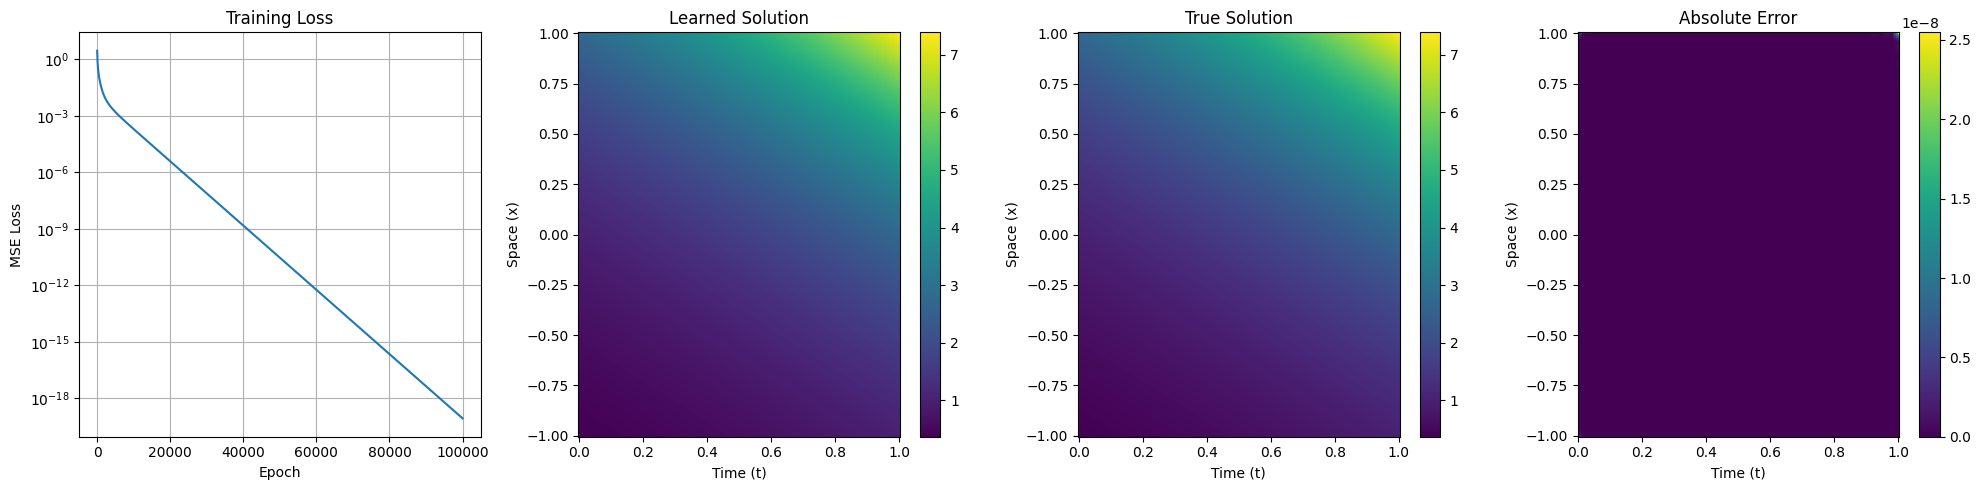

Final training loss: 8.639e-20
Maximum absolute error: 3.570e-03


In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm

def train_spectral_interpolation(n_epochs=10000):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    # Create high-resolution data grid (100x100)
    Nt_data, Nx_data = 100, 100
    t_data = torch.linspace(0, 1, Nt_data)
    x_data = torch.linspace(-1, 1, Nx_data)
    T_data, X_data = torch.meshgrid(t_data, x_data, indexing='ij')
    data_points = torch.stack([T_data.flatten(), X_data.flatten()], dim=-1)
    
    # Create true solution at data points
    u_data = torch.exp(T_data + X_data)
    
    # Create spectral interpolator with lower resolution (17x17)
    interpolator = SpectralInterpolationND(
        Ns=[17, 17],  # 17 nodes in each dimension
        bases=['chebyshev', 'chebyshev'],  # Chebyshev basis for both dimensions
        domains=[(0, 1), (-1, 1)]  # Same domains as data
    )
    
    # Initialize randomly around 1 (since exp(t+x) is always positive)
    interpolator.values.data = torch.randn_like(interpolator.values) * 0.1 + 1.0
    
    # Setup optimizer
    # optimizer = torch.optim.Adam([interpolator.values], lr=1e-3)
    optimizer = torch.optim.SGD([interpolator.values], lr=1)
    
    # Training loop
    losses = []
    
    for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()
        
        # Evaluate interpolant at data points
        u_pred = interpolator(data_points)
        
        # Compute MSE loss
        loss = torch.mean((u_pred - u_data.flatten())**2)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Store loss
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():1.3e}')
    
    # Create evaluation grid for final visualization
    t_eval = torch.linspace(0, 1, 200)
    x_eval = torch.linspace(-1, 1, 200)
    T_eval, X_eval = torch.meshgrid(t_eval, x_eval, indexing='ij')
    eval_points = torch.stack([T_eval.flatten(), X_eval.flatten()], dim=-1)
    
    # Evaluate final interpolant
    with torch.no_grad():
        u_final = interpolator(eval_points).reshape(T_eval.shape).detach()
        u_true = torch.exp(T_eval + X_eval)
        error = torch.abs(u_final - u_true)
    
    # Create visualization
    fig = plt.figure(figsize=(20, 5))
    
    # Plot 1: Training Loss
    ax1 = fig.add_subplot(141)
    ax1.semilogy(losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)
    
    # Plot 2: Learned Solution
    ax2 = fig.add_subplot(142)
    c2 = ax2.pcolormesh(T_eval.numpy(), X_eval.numpy(), u_final.numpy(), 
                        shading='auto', cmap='viridis')
    ax2.set_xlabel('Time (t)')
    ax2.set_ylabel('Space (x)')
    ax2.set_title('Learned Solution')
    plt.colorbar(c2, ax=ax2)
    
    # Plot 3: True Solution
    ax3 = fig.add_subplot(143)
    c3 = ax3.pcolormesh(T_eval.numpy(), X_eval.numpy(), u_true.numpy(), 
                        shading='auto', cmap='viridis')
    ax3.set_xlabel('Time (t)')
    ax3.set_ylabel('Space (x)')
    ax3.set_title('True Solution')
    plt.colorbar(c3, ax=ax3)
    
    # Plot 4: Error
    ax4 = fig.add_subplot(144)
    c4 = ax4.pcolormesh(T_eval.numpy(), X_eval.numpy(), error.numpy(), 
                        shading='auto', cmap='viridis')
    ax4.set_xlabel('Time (t)')
    ax4.set_ylabel('Space (x)')
    ax4.set_title('Absolute Error')
    plt.colorbar(c4, ax=ax4)
    
    plt.tight_layout()
    
    return fig, interpolator, losses, error

# Run the training
if __name__ == "__main__":
    fig, interpolator, losses, error = train_spectral_interpolation(n_epochs=100000)
    plt.show()
    
    # Print final loss
    print(f"Final training loss: {losses[-1]:1.3e}")
    print(f"Maximum absolute error: {torch.max(torch.abs(error)).item():1.3e}")

  0%|          | 112/30000 [00:01<08:25, 59.18it/s]

Epoch [100/30000], Loss: 2.608e+00


  1%|          | 205/30000 [00:03<08:37, 57.58it/s]

Epoch [200/30000], Loss: 2.411e+00


  1%|          | 312/30000 [00:05<08:26, 58.67it/s]

Epoch [300/30000], Loss: 2.233e+00


  1%|▏         | 408/30000 [00:06<07:35, 65.02it/s]

Epoch [400/30000], Loss: 2.070e+00


  2%|▏         | 506/30000 [00:08<08:18, 59.18it/s]

Epoch [500/30000], Loss: 1.920e+00


  2%|▏         | 608/30000 [00:10<08:11, 59.81it/s]

Epoch [600/30000], Loss: 1.782e+00


  2%|▏         | 710/30000 [00:11<08:16, 58.95it/s]

Epoch [700/30000], Loss: 1.655e+00


  3%|▎         | 807/30000 [00:13<07:22, 65.97it/s]

Epoch [800/30000], Loss: 1.538e+00


  3%|▎         | 912/30000 [00:14<07:49, 61.94it/s]

Epoch [900/30000], Loss: 1.428e+00


  3%|▎         | 1010/30000 [00:16<07:53, 61.19it/s]

Epoch [1000/30000], Loss: 1.327e+00


  4%|▎         | 1108/30000 [00:18<07:22, 65.22it/s]

Epoch [1100/30000], Loss: 1.233e+00


  4%|▍         | 1206/30000 [00:19<07:39, 62.61it/s]

Epoch [1200/30000], Loss: 1.145e+00


  4%|▍         | 1309/30000 [00:21<07:52, 60.67it/s]

Epoch [1300/30000], Loss: 1.063e+00


  5%|▍         | 1407/30000 [00:22<08:00, 59.47it/s]

Epoch [1400/30000], Loss: 9.872e-01


  5%|▌         | 1512/30000 [00:24<07:26, 63.78it/s]

Epoch [1500/30000], Loss: 9.163e-01


  5%|▌         | 1610/30000 [00:26<07:36, 62.15it/s]

Epoch [1600/30000], Loss: 8.501e-01


  6%|▌         | 1708/30000 [00:27<07:34, 62.25it/s]

Epoch [1700/30000], Loss: 7.884e-01


  6%|▌         | 1806/30000 [00:29<07:35, 61.89it/s]

Epoch [1800/30000], Loss: 7.309e-01


  6%|▋         | 1911/30000 [00:30<07:04, 66.10it/s]

Epoch [1900/30000], Loss: 6.772e-01


  7%|▋         | 2009/30000 [00:32<07:34, 61.64it/s]

Epoch [2000/30000], Loss: 6.271e-01


  7%|▋         | 2107/30000 [00:34<07:33, 61.45it/s]

Epoch [2100/30000], Loss: 5.805e-01


  7%|▋         | 2212/30000 [00:35<07:08, 64.86it/s]

Epoch [2200/30000], Loss: 5.369e-01


  8%|▊         | 2310/30000 [00:37<07:27, 61.88it/s]

Epoch [2300/30000], Loss: 4.963e-01


  8%|▊         | 2408/30000 [00:38<07:25, 61.90it/s]

Epoch [2400/30000], Loss: 4.585e-01


  8%|▊         | 2506/30000 [00:40<07:28, 61.37it/s]

Epoch [2500/30000], Loss: 4.233e-01


  9%|▊         | 2611/30000 [00:42<07:06, 64.29it/s]

Epoch [2600/30000], Loss: 3.905e-01


  9%|▉         | 2709/30000 [00:43<07:28, 60.86it/s]

Epoch [2700/30000], Loss: 3.599e-01


  9%|▉         | 2807/30000 [00:45<07:26, 60.94it/s]

Epoch [2800/30000], Loss: 3.315e-01


 10%|▉         | 2910/30000 [00:47<07:17, 61.88it/s]

Epoch [2900/30000], Loss: 3.050e-01


 10%|█         | 3008/30000 [00:48<06:56, 64.81it/s]

Epoch [3000/30000], Loss: 2.804e-01


 10%|█         | 3110/30000 [00:50<07:31, 59.55it/s]

Epoch [3100/30000], Loss: 2.576e-01


 11%|█         | 3208/30000 [00:51<07:17, 61.29it/s]

Epoch [3200/30000], Loss: 2.364e-01


 11%|█         | 3312/30000 [00:53<06:59, 63.68it/s]

Epoch [3300/30000], Loss: 2.167e-01


 11%|█▏        | 3410/30000 [00:55<07:22, 60.16it/s]

Epoch [3400/30000], Loss: 1.984e-01


 12%|█▏        | 3510/30000 [00:56<07:26, 59.29it/s]

Epoch [3500/30000], Loss: 1.815e-01


 12%|█▏        | 3611/30000 [00:58<07:23, 59.47it/s]

Epoch [3600/30000], Loss: 1.658e-01


 12%|█▏        | 3711/30000 [01:00<06:53, 63.61it/s]

Epoch [3700/30000], Loss: 1.513e-01


 13%|█▎        | 3809/30000 [01:01<07:07, 61.24it/s]

Epoch [3800/30000], Loss: 1.379e-01


 13%|█▎        | 3908/30000 [01:03<07:27, 58.34it/s]

Epoch [3900/30000], Loss: 1.255e-01


 13%|█▎        | 4007/30000 [01:05<07:08, 60.71it/s]

Epoch [4000/30000], Loss: 1.140e-01


 14%|█▎        | 4112/30000 [01:06<06:54, 62.52it/s]

Epoch [4100/30000], Loss: 1.035e-01


 14%|█▍        | 4210/30000 [01:08<07:10, 59.92it/s]

Epoch [4200/30000], Loss: 9.375e-02


 14%|█▍        | 4306/30000 [01:09<07:04, 60.46it/s]

Epoch [4300/30000], Loss: 8.480e-02


 15%|█▍        | 4406/30000 [01:11<06:30, 65.57it/s]

Epoch [4400/30000], Loss: 7.657e-02


 15%|█▌        | 4511/30000 [01:13<07:00, 60.65it/s]

Epoch [4500/30000], Loss: 6.902e-02


 15%|█▌        | 4609/30000 [01:14<07:03, 60.00it/s]

Epoch [4600/30000], Loss: 6.209e-02


 16%|█▌        | 4706/30000 [01:16<06:57, 60.57it/s]

Epoch [4700/30000], Loss: 5.576e-02


 16%|█▌        | 4811/30000 [01:18<06:26, 65.16it/s]

Epoch [4800/30000], Loss: 4.996e-02


 16%|█▋        | 4909/30000 [01:19<06:46, 61.67it/s]

Epoch [4900/30000], Loss: 4.468e-02


 17%|█▋        | 5007/30000 [01:21<06:41, 62.22it/s]

Epoch [5000/30000], Loss: 3.986e-02


 17%|█▋        | 5112/30000 [01:22<06:19, 65.57it/s]

Epoch [5100/30000], Loss: 3.548e-02


 17%|█▋        | 5210/30000 [01:24<06:44, 61.29it/s]

Epoch [5200/30000], Loss: 3.150e-02


 18%|█▊        | 5308/30000 [01:26<06:42, 61.34it/s]

Epoch [5300/30000], Loss: 2.790e-02


 18%|█▊        | 5406/30000 [01:27<06:40, 61.42it/s]

Epoch [5400/30000], Loss: 2.465e-02


 18%|█▊        | 5511/30000 [01:29<06:22, 64.00it/s]

Epoch [5500/30000], Loss: 2.171e-02


 19%|█▊        | 5609/30000 [01:30<06:36, 61.58it/s]

Epoch [5600/30000], Loss: 1.907e-02


 19%|█▉        | 5707/30000 [01:32<06:40, 60.60it/s]

Epoch [5700/30000], Loss: 1.670e-02


 19%|█▉        | 5809/30000 [01:34<06:47, 59.34it/s]

Epoch [5800/30000], Loss: 1.458e-02


 20%|█▉        | 5906/30000 [01:35<06:23, 62.79it/s]

Epoch [5900/30000], Loss: 1.269e-02


 20%|██        | 6006/30000 [01:37<06:52, 58.12it/s]

Epoch [6000/30000], Loss: 1.101e-02


 20%|██        | 6112/30000 [01:39<06:37, 60.04it/s]

Epoch [6100/30000], Loss: 9.512e-03


 21%|██        | 6213/30000 [01:40<06:03, 65.38it/s]

Epoch [6200/30000], Loss: 8.191e-03


 21%|██        | 6307/30000 [01:42<06:46, 58.24it/s]

Epoch [6300/30000], Loss: 7.026e-03


 21%|██▏       | 6409/30000 [01:44<06:30, 60.36it/s]

Epoch [6400/30000], Loss: 6.004e-03


 22%|██▏       | 6507/30000 [01:45<06:36, 59.18it/s]

Epoch [6500/30000], Loss: 5.109e-03


 22%|██▏       | 6610/30000 [01:47<05:53, 66.10it/s]

Epoch [6600/30000], Loss: 4.330e-03


 22%|██▏       | 6708/30000 [01:49<06:18, 61.53it/s]

Epoch [6700/30000], Loss: 3.653e-03


 23%|██▎       | 6805/30000 [01:50<06:41, 57.76it/s]

Epoch [6800/30000], Loss: 3.067e-03


 23%|██▎       | 6910/30000 [01:52<06:06, 63.05it/s]

Epoch [6900/30000], Loss: 2.564e-03


 23%|██▎       | 7008/30000 [01:53<06:19, 60.65it/s]

Epoch [7000/30000], Loss: 2.132e-03


 24%|██▎       | 7106/30000 [01:55<06:20, 60.14it/s]

Epoch [7100/30000], Loss: 1.763e-03


 24%|██▍       | 7209/30000 [01:57<06:27, 58.86it/s]

Epoch [7200/30000], Loss: 1.451e-03


 24%|██▍       | 7312/30000 [01:58<05:42, 66.18it/s]

Epoch [7300/30000], Loss: 1.187e-03


 25%|██▍       | 7409/30000 [02:00<06:19, 59.53it/s]

Epoch [7400/30000], Loss: 9.650e-04


 25%|██▌       | 7511/30000 [02:02<06:09, 60.89it/s]

Epoch [7500/30000], Loss: 7.797e-04


 25%|██▌       | 7609/30000 [02:03<05:40, 65.66it/s]

Epoch [7600/30000], Loss: 6.259e-04


 26%|██▌       | 7707/30000 [02:05<05:53, 63.04it/s]

Epoch [7700/30000], Loss: 4.989e-04


 26%|██▌       | 7812/30000 [02:06<05:50, 63.22it/s]

Epoch [7800/30000], Loss: 3.948e-04


 26%|██▋       | 7910/30000 [02:08<05:47, 63.57it/s]

Epoch [7900/30000], Loss: 3.101e-04


 27%|██▋       | 8008/30000 [02:09<05:35, 65.50it/s]

Epoch [8000/30000], Loss: 2.416e-04


 27%|██▋       | 8106/30000 [02:11<05:46, 63.26it/s]

Epoch [8100/30000], Loss: 1.866e-04


 27%|██▋       | 8211/30000 [02:13<05:44, 63.32it/s]

Epoch [8200/30000], Loss: 1.428e-04


 28%|██▊       | 8309/30000 [02:14<05:45, 62.83it/s]

Epoch [8300/30000], Loss: 1.083e-04


 28%|██▊       | 8407/30000 [02:16<05:26, 66.15it/s]

Epoch [8400/30000], Loss: 8.135e-05


 28%|██▊       | 8505/30000 [02:17<05:58, 60.03it/s]

Epoch [8500/30000], Loss: 6.046e-05


 29%|██▊       | 8608/30000 [02:19<05:46, 61.73it/s]

Epoch [8600/30000], Loss: 4.443e-05


 29%|██▉       | 8713/30000 [02:21<05:25, 65.36it/s]

Epoch [8700/30000], Loss: 3.227e-05


 29%|██▉       | 8810/30000 [02:22<06:02, 58.45it/s]

Epoch [8800/30000], Loss: 2.315e-05


 30%|██▉       | 8906/30000 [02:24<06:03, 58.09it/s]

Epoch [8900/30000], Loss: 1.639e-05


 30%|███       | 9009/30000 [02:26<06:04, 57.65it/s]

Epoch [9000/30000], Loss: 1.145e-05


 30%|███       | 9110/30000 [02:27<05:24, 64.39it/s]

Epoch [9100/30000], Loss: 7.875e-06


 31%|███       | 9208/30000 [02:29<05:37, 61.52it/s]

Epoch [9200/30000], Loss: 5.334e-06


 31%|███       | 9306/30000 [02:30<05:48, 59.39it/s]

Epoch [9300/30000], Loss: 3.552e-06


 31%|███▏      | 9410/30000 [02:32<05:27, 62.81it/s]

Epoch [9400/30000], Loss: 2.325e-06


 32%|███▏      | 9508/30000 [02:34<05:23, 63.37it/s]

Epoch [9500/30000], Loss: 1.493e-06


 32%|███▏      | 9606/30000 [02:35<05:29, 61.84it/s]

Epoch [9600/30000], Loss: 9.395e-07


 32%|███▏      | 9711/30000 [02:37<05:21, 63.18it/s]

Epoch [9700/30000], Loss: 5.790e-07


 33%|███▎      | 9809/30000 [02:39<05:05, 66.19it/s]

Epoch [9800/30000], Loss: 3.489e-07


 33%|███▎      | 9906/30000 [02:40<05:44, 58.32it/s]

Epoch [9900/30000], Loss: 2.051e-07


 33%|███▎      | 10010/30000 [02:42<05:38, 59.04it/s]

Epoch [10000/30000], Loss: 1.176e-07


 34%|███▎      | 10107/30000 [02:44<05:43, 57.94it/s]

Epoch [10100/30000], Loss: 6.575e-08


 34%|███▍      | 10210/30000 [02:45<05:00, 65.87it/s]

Epoch [10200/30000], Loss: 3.563e-08


 34%|███▍      | 10307/30000 [02:47<05:26, 60.30it/s]

Epoch [10300/30000], Loss: 1.876e-08


 35%|███▍      | 10406/30000 [02:48<05:33, 58.69it/s]

Epoch [10400/30000], Loss: 9.564e-09


 35%|███▌      | 10513/30000 [02:50<04:59, 65.12it/s]

Epoch [10500/30000], Loss: 4.721e-09


 35%|███▌      | 10609/30000 [02:52<05:33, 58.18it/s]

Epoch [10600/30000], Loss: 2.243e-09


 36%|███▌      | 10707/30000 [02:54<05:37, 57.14it/s]

Epoch [10700/30000], Loss: 1.030e-09


 36%|███▌      | 10811/30000 [02:55<05:34, 57.43it/s]

Epoch [10800/30000], Loss: 4.528e-10


 36%|███▋      | 10908/30000 [02:57<04:49, 65.97it/s]

Epoch [10900/30000], Loss: 1.922e-10


 37%|███▋      | 11006/30000 [02:58<05:15, 60.30it/s]

Epoch [11000/30000], Loss: 8.403e-11


 37%|███▋      | 11106/30000 [03:00<05:14, 60.02it/s]

Epoch [11100/30000], Loss: 1.087e-10


 37%|███▋      | 11212/30000 [03:02<04:48, 65.07it/s]

Epoch [11200/30000], Loss: 3.056e-10


 38%|███▊      | 11310/30000 [03:03<05:12, 59.85it/s]

Epoch [11300/30000], Loss: 3.847e-12


 38%|███▊      | 11408/30000 [03:05<05:00, 61.82it/s]

Epoch [11400/30000], Loss: 5.229e-11


 38%|███▊      | 11506/30000 [03:07<05:00, 61.62it/s]

Epoch [11500/30000], Loss: 7.516e-11


 39%|███▊      | 11611/30000 [03:08<04:43, 64.82it/s]

Epoch [11600/30000], Loss: 2.367e-12


 39%|███▉      | 11709/30000 [03:10<05:06, 59.76it/s]

Epoch [11700/30000], Loss: 2.186e-11


 39%|███▉      | 11807/30000 [03:12<05:01, 60.31it/s]

Epoch [11800/30000], Loss: 1.038e-12


 40%|███▉      | 11907/30000 [03:13<04:40, 64.49it/s]

Epoch [11900/30000], Loss: 1.832e-11


 40%|████      | 12012/30000 [03:15<04:50, 61.89it/s]

Epoch [12000/30000], Loss: 7.254e-11


 40%|████      | 12110/30000 [03:16<04:45, 62.62it/s]

Epoch [12100/30000], Loss: 1.140e-10


 41%|████      | 12211/30000 [03:18<05:00, 59.26it/s]

Epoch [12200/30000], Loss: 3.687e-10


 41%|████      | 12313/30000 [03:20<04:29, 65.72it/s]

Epoch [12300/30000], Loss: 9.425e-13


 41%|████▏     | 12411/30000 [03:21<04:38, 63.06it/s]

Epoch [12400/30000], Loss: 2.489e-13


 42%|████▏     | 12509/30000 [03:23<04:39, 62.49it/s]

Epoch [12500/30000], Loss: 9.715e-11


 42%|████▏     | 12607/30000 [03:24<04:38, 62.39it/s]

Epoch [12600/30000], Loss: 1.001e-10


 42%|████▏     | 12712/30000 [03:26<04:30, 63.85it/s]

Epoch [12700/30000], Loss: 7.826e-11


 43%|████▎     | 12810/30000 [03:28<04:33, 62.91it/s]

Epoch [12800/30000], Loss: 2.910e-10


 43%|████▎     | 12908/30000 [03:29<04:31, 62.92it/s]

Epoch [12900/30000], Loss: 8.965e-11


 43%|████▎     | 13013/30000 [03:31<04:19, 65.35it/s]

Epoch [13000/30000], Loss: 8.389e-11


 44%|████▎     | 13111/30000 [03:32<04:27, 63.16it/s]

Epoch [13100/30000], Loss: 3.546e-11


 44%|████▍     | 13209/30000 [03:34<04:28, 62.60it/s]

Epoch [13200/30000], Loss: 1.901e-11


 44%|████▍     | 13307/30000 [03:35<04:34, 60.92it/s]

Epoch [13300/30000], Loss: 3.933e-11


 45%|████▍     | 13412/30000 [03:37<04:13, 65.55it/s]

Epoch [13400/30000], Loss: 1.911e-11


 45%|████▌     | 13510/30000 [03:39<04:32, 60.56it/s]

Epoch [13500/30000], Loss: 3.731e-12


 45%|████▌     | 13607/30000 [03:40<04:29, 60.90it/s]

Epoch [13600/30000], Loss: 8.407e-11


 46%|████▌     | 13712/30000 [03:42<04:10, 64.96it/s]

Epoch [13700/30000], Loss: 4.386e-11


 46%|████▌     | 13810/30000 [03:43<04:20, 62.25it/s]

Epoch [13800/30000], Loss: 3.081e-11


 46%|████▋     | 13908/30000 [03:45<04:19, 61.92it/s]

Epoch [13900/30000], Loss: 6.537e-11


 47%|████▋     | 14006/30000 [03:47<04:17, 62.07it/s]

Epoch [14000/30000], Loss: 2.357e-10


 47%|████▋     | 14111/30000 [03:48<04:05, 64.59it/s]

Epoch [14100/30000], Loss: 3.874e-11


 47%|████▋     | 14209/30000 [03:50<04:13, 62.17it/s]

Epoch [14200/30000], Loss: 7.158e-11


 48%|████▊     | 14307/30000 [03:51<04:13, 61.87it/s]

Epoch [14300/30000], Loss: 1.477e-10


 48%|████▊     | 14412/30000 [03:53<04:13, 61.61it/s]

Epoch [14400/30000], Loss: 1.271e-11


 48%|████▊     | 14510/30000 [03:55<04:03, 63.59it/s]

Epoch [14500/30000], Loss: 7.531e-11


 49%|████▊     | 14608/30000 [03:56<04:06, 62.33it/s]

Epoch [14600/30000], Loss: 2.200e-11


 49%|████▉     | 14706/30000 [03:58<04:04, 62.56it/s]

Epoch [14700/30000], Loss: 3.621e-10


 49%|████▉     | 14811/30000 [03:59<03:51, 65.69it/s]

Epoch [14800/30000], Loss: 2.838e-11


 50%|████▉     | 14909/30000 [04:01<04:12, 59.80it/s]

Epoch [14900/30000], Loss: 9.204e-11


 50%|█████     | 15011/30000 [04:03<04:01, 62.18it/s]

Epoch [15000/30000], Loss: 3.705e-10


 50%|█████     | 15109/30000 [04:04<03:58, 62.57it/s]

Epoch [15100/30000], Loss: 6.766e-10


 51%|█████     | 15207/30000 [04:06<03:45, 65.54it/s]

Epoch [15200/30000], Loss: 1.751e-10


 51%|█████     | 15312/30000 [04:07<03:58, 61.51it/s]

Epoch [15300/30000], Loss: 7.455e-11


 51%|█████▏    | 15410/30000 [04:09<03:57, 61.55it/s]

Epoch [15400/30000], Loss: 1.221e-10


 52%|█████▏    | 15508/30000 [04:11<03:45, 64.20it/s]

Epoch [15500/30000], Loss: 2.772e-10


 52%|█████▏    | 15606/30000 [04:12<03:51, 62.20it/s]

Epoch [15600/30000], Loss: 8.419e-11


 52%|█████▏    | 15711/30000 [04:14<03:53, 61.07it/s]

Epoch [15700/30000], Loss: 5.653e-10


 53%|█████▎    | 15809/30000 [04:15<03:49, 61.89it/s]

Epoch [15800/30000], Loss: 4.200e-11


 53%|█████▎    | 15907/30000 [04:17<03:37, 64.87it/s]

Epoch [15900/30000], Loss: 1.006e-11


 53%|█████▎    | 16012/30000 [04:19<03:44, 62.25it/s]

Epoch [16000/30000], Loss: 1.325e-10


 54%|█████▎    | 16110/30000 [04:20<03:46, 61.26it/s]

Epoch [16100/30000], Loss: 1.611e-09


 54%|█████▍    | 16208/30000 [04:22<03:37, 63.52it/s]

Epoch [16200/30000], Loss: 3.760e-10


 54%|█████▍    | 16306/30000 [04:23<03:34, 63.92it/s]

Epoch [16300/30000], Loss: 8.303e-11


 55%|█████▍    | 16411/30000 [04:25<03:38, 62.33it/s]

Epoch [16400/30000], Loss: 2.011e-11


 55%|█████▌    | 16509/30000 [04:27<03:36, 62.37it/s]

Epoch [16500/30000], Loss: 1.434e-11


 55%|█████▌    | 16607/30000 [04:28<03:30, 63.75it/s]

Epoch [16600/30000], Loss: 1.995e-10


 56%|█████▌    | 16712/30000 [04:30<03:34, 62.07it/s]

Epoch [16700/30000], Loss: 3.986e-11


 56%|█████▌    | 16810/30000 [04:31<03:41, 59.45it/s]

Epoch [16800/30000], Loss: 5.756e-11


 56%|█████▋    | 16907/30000 [04:33<03:35, 60.68it/s]

Epoch [16900/30000], Loss: 5.578e-11


 57%|█████▋    | 17012/30000 [04:35<03:28, 62.34it/s]

Epoch [17000/30000], Loss: 1.485e-10


 57%|█████▋    | 17110/30000 [04:36<03:35, 59.79it/s]

Epoch [17100/30000], Loss: 2.117e-10


 57%|█████▋    | 17206/30000 [04:38<03:31, 60.39it/s]

Epoch [17200/30000], Loss: 1.602e-09


 58%|█████▊    | 17311/30000 [04:39<03:24, 62.18it/s]

Epoch [17300/30000], Loss: 5.794e-11


 58%|█████▊    | 17409/30000 [04:41<03:28, 60.49it/s]

Epoch [17400/30000], Loss: 1.220e-10


 58%|█████▊    | 17507/30000 [04:43<03:25, 60.86it/s]

Epoch [17500/30000], Loss: 1.015e-11


 59%|█████▊    | 17611/30000 [04:44<03:22, 61.10it/s]

Epoch [17600/30000], Loss: 5.491e-11


 59%|█████▉    | 17709/30000 [04:46<03:17, 62.31it/s]

Epoch [17700/30000], Loss: 1.718e-10


 59%|█████▉    | 17807/30000 [04:48<03:15, 62.52it/s]

Epoch [17800/30000], Loss: 2.239e-11


 60%|█████▉    | 17912/30000 [04:49<03:13, 62.53it/s]

Epoch [17900/30000], Loss: 5.335e-12


 60%|██████    | 18010/30000 [04:51<03:02, 65.67it/s]

Epoch [18000/30000], Loss: 2.255e-11


 60%|██████    | 18108/30000 [04:52<03:16, 60.47it/s]

Epoch [18100/30000], Loss: 6.010e-11


 61%|██████    | 18206/30000 [04:54<03:15, 60.33it/s]

Epoch [18200/30000], Loss: 9.319e-12


 61%|██████    | 18306/30000 [04:56<03:18, 58.94it/s]

Epoch [18300/30000], Loss: 2.365e-10


 61%|██████▏   | 18411/30000 [04:57<03:09, 61.18it/s]

Epoch [18400/30000], Loss: 3.746e-11


 62%|██████▏   | 18509/30000 [04:59<03:13, 59.46it/s]

Epoch [18500/30000], Loss: 1.270e-11


 62%|██████▏   | 18611/30000 [05:01<03:03, 61.91it/s]

Epoch [18600/30000], Loss: 3.107e-12


 62%|██████▏   | 18709/30000 [05:02<02:54, 64.88it/s]

Epoch [18700/30000], Loss: 2.362e-11


 63%|██████▎   | 18807/30000 [05:04<02:59, 62.47it/s]

Epoch [18800/30000], Loss: 2.873e-10


 63%|██████▎   | 18912/30000 [05:05<02:58, 61.94it/s]

Epoch [18900/30000], Loss: 6.754e-12


 63%|██████▎   | 19010/30000 [05:07<02:59, 61.06it/s]

Epoch [19000/30000], Loss: 9.751e-13


 64%|██████▎   | 19108/30000 [05:08<02:46, 65.28it/s]

Epoch [19100/30000], Loss: 9.454e-12


 64%|██████▍   | 19207/30000 [05:10<03:05, 58.08it/s]

Epoch [19200/30000], Loss: 5.244e-09


 64%|██████▍   | 19312/30000 [05:12<02:51, 62.46it/s]

Epoch [19300/30000], Loss: 2.769e-12


 65%|██████▍   | 19410/30000 [05:13<02:40, 65.82it/s]

Epoch [19400/30000], Loss: 4.050e-11


 65%|██████▌   | 19508/30000 [05:15<02:55, 59.62it/s]

Epoch [19500/30000], Loss: 1.121e-11


 65%|██████▌   | 19610/30000 [05:17<02:52, 60.31it/s]

Epoch [19600/30000], Loss: 7.575e-10


 66%|██████▌   | 19708/30000 [05:18<02:48, 61.24it/s]

Epoch [19700/30000], Loss: 1.597e-12


 66%|██████▌   | 19813/30000 [05:20<02:36, 65.20it/s]

Epoch [19800/30000], Loss: 2.260e-10


 66%|██████▋   | 19910/30000 [05:22<02:49, 59.69it/s]

Epoch [19900/30000], Loss: 2.184e-09


 67%|██████▋   | 20011/30000 [05:23<02:38, 62.93it/s]

Epoch [20000/30000], Loss: 4.981e-10


 67%|██████▋   | 20109/30000 [05:25<02:33, 64.46it/s]

Epoch [20100/30000], Loss: 4.935e-10


 67%|██████▋   | 20207/30000 [05:26<02:35, 63.07it/s]

Epoch [20200/30000], Loss: 1.143e-09


 68%|██████▊   | 20312/30000 [05:28<02:35, 62.11it/s]

Epoch [20300/30000], Loss: 4.077e-11


 68%|██████▊   | 20410/30000 [05:29<02:32, 62.77it/s]

Epoch [20400/30000], Loss: 5.454e-11


 68%|██████▊   | 20508/30000 [05:31<02:25, 65.43it/s]

Epoch [20500/30000], Loss: 1.269e-11


 69%|██████▊   | 20606/30000 [05:33<02:30, 62.39it/s]

Epoch [20600/30000], Loss: 8.298e-12


 69%|██████▉   | 20711/30000 [05:34<02:28, 62.35it/s]

Epoch [20700/30000], Loss: 3.773e-10


 69%|██████▉   | 20809/30000 [05:36<02:27, 62.43it/s]

Epoch [20800/30000], Loss: 4.134e-14


 70%|██████▉   | 20907/30000 [05:37<02:21, 64.20it/s]

Epoch [20900/30000], Loss: 7.561e-11


 70%|███████   | 21012/30000 [05:39<02:28, 60.47it/s]

Epoch [21000/30000], Loss: 3.331e-11


 70%|███████   | 21110/30000 [05:41<02:27, 60.07it/s]

Epoch [21100/30000], Loss: 1.942e-11


 71%|███████   | 21208/30000 [05:42<02:15, 64.85it/s]

Epoch [21200/30000], Loss: 2.745e-12


 71%|███████   | 21306/30000 [05:44<02:24, 60.23it/s]

Epoch [21300/30000], Loss: 1.083e-11


 71%|███████▏  | 21411/30000 [05:46<02:23, 60.04it/s]

Epoch [21400/30000], Loss: 3.515e-11


 72%|███████▏  | 21510/30000 [05:47<02:26, 57.84it/s]

Epoch [21500/30000], Loss: 8.898e-11


 72%|███████▏  | 21606/30000 [05:49<02:10, 64.50it/s]

Epoch [21600/30000], Loss: 4.402e-10


 72%|███████▏  | 21711/30000 [05:51<02:13, 62.08it/s]

Epoch [21700/30000], Loss: 1.402e-12


 73%|███████▎  | 21809/30000 [05:52<02:12, 62.01it/s]

Epoch [21800/30000], Loss: 1.037e-10


 73%|███████▎  | 21907/30000 [05:54<02:03, 65.29it/s]

Epoch [21900/30000], Loss: 3.049e-12


 73%|███████▎  | 22012/30000 [05:55<02:11, 60.95it/s]

Epoch [22000/30000], Loss: 2.027e-12


 74%|███████▎  | 22109/30000 [05:57<02:09, 60.99it/s]

Epoch [22100/30000], Loss: 1.292e-09


 74%|███████▍  | 22211/30000 [05:59<02:10, 59.69it/s]

Epoch [22200/30000], Loss: 7.133e-10


 74%|███████▍  | 22307/30000 [06:00<01:58, 64.87it/s]

Epoch [22300/30000], Loss: 2.767e-12


 75%|███████▍  | 22411/30000 [06:02<02:10, 58.26it/s]

Epoch [22400/30000], Loss: 7.349e-12


 75%|███████▌  | 22509/30000 [06:04<02:06, 59.26it/s]

Epoch [22500/30000], Loss: 1.778e-10


 75%|███████▌  | 22613/30000 [06:05<01:54, 64.29it/s]

Epoch [22600/30000], Loss: 3.374e-11


 76%|███████▌  | 22710/30000 [06:07<02:01, 59.92it/s]

Epoch [22700/30000], Loss: 5.600e-11


 76%|███████▌  | 22811/30000 [06:09<01:59, 60.40it/s]

Epoch [22800/30000], Loss: 6.278e-13


 76%|███████▋  | 22909/30000 [06:10<01:57, 60.39it/s]

Epoch [22900/30000], Loss: 1.584e-11


 77%|███████▋  | 23007/30000 [06:12<01:48, 64.59it/s]

Epoch [23000/30000], Loss: 1.522e-09


 77%|███████▋  | 23112/30000 [06:13<01:54, 60.28it/s]

Epoch [23100/30000], Loss: 9.795e-13


 77%|███████▋  | 23210/30000 [06:15<01:52, 60.37it/s]

Epoch [23200/30000], Loss: 2.564e-11


 78%|███████▊  | 23308/30000 [06:17<01:42, 65.41it/s]

Epoch [23300/30000], Loss: 2.119e-10


 78%|███████▊  | 23406/30000 [06:18<01:49, 60.29it/s]

Epoch [23400/30000], Loss: 4.211e-10


 78%|███████▊  | 23511/30000 [06:20<01:44, 62.14it/s]

Epoch [23500/30000], Loss: 1.522e-11


 79%|███████▊  | 23609/30000 [06:21<01:42, 62.18it/s]

Epoch [23600/30000], Loss: 4.805e-10


 79%|███████▉  | 23707/30000 [06:23<01:35, 66.14it/s]

Epoch [23700/30000], Loss: 1.296e-11


 79%|███████▉  | 23812/30000 [06:25<01:38, 62.77it/s]

Epoch [23800/30000], Loss: 7.923e-12


 80%|███████▉  | 23910/30000 [06:26<01:36, 62.79it/s]

Epoch [23900/30000], Loss: 2.095e-09


 80%|████████  | 24008/30000 [06:28<01:31, 65.45it/s]

Epoch [24000/30000], Loss: 2.601e-14


 80%|████████  | 24106/30000 [06:29<01:37, 60.61it/s]

Epoch [24100/30000], Loss: 5.040e-14


 81%|████████  | 24211/30000 [06:31<01:33, 61.90it/s]

Epoch [24200/30000], Loss: 1.000e-11


 81%|████████  | 24309/30000 [06:33<01:31, 62.41it/s]

Epoch [24300/30000], Loss: 3.830e-16


 81%|████████▏ | 24407/30000 [06:34<01:25, 65.10it/s]

Epoch [24400/30000], Loss: 1.843e-11


 82%|████████▏ | 24512/30000 [06:36<01:29, 61.36it/s]

Epoch [24500/30000], Loss: 4.073e-10


 82%|████████▏ | 24610/30000 [06:37<01:26, 62.28it/s]

Epoch [24600/30000], Loss: 9.205e-15


 82%|████████▏ | 24708/30000 [06:39<01:21, 64.64it/s]

Epoch [24700/30000], Loss: 1.136e-10


 83%|████████▎ | 24806/30000 [06:40<01:22, 62.76it/s]

Epoch [24800/30000], Loss: 6.341e-10


 83%|████████▎ | 24911/30000 [06:42<01:21, 62.40it/s]

Epoch [24900/30000], Loss: 3.589e-13


 83%|████████▎ | 25009/30000 [06:44<01:18, 63.45it/s]

Epoch [25000/30000], Loss: 9.519e-11


 84%|████████▎ | 25107/30000 [06:45<01:16, 64.23it/s]

Epoch [25100/30000], Loss: 6.995e-11


 84%|████████▍ | 25212/30000 [06:47<01:17, 62.07it/s]

Epoch [25200/30000], Loss: 1.132e-10


 84%|████████▍ | 25310/30000 [06:48<01:15, 62.36it/s]

Epoch [25300/30000], Loss: 3.980e-11


 85%|████████▍ | 25408/30000 [06:50<01:12, 63.35it/s]

Epoch [25400/30000], Loss: 2.060e-11


 85%|████████▌ | 25506/30000 [06:52<01:13, 61.01it/s]

Epoch [25500/30000], Loss: 6.834e-11


 85%|████████▌ | 25611/30000 [06:53<01:12, 60.63it/s]

Epoch [25600/30000], Loss: 6.588e-10


 86%|████████▌ | 25709/30000 [06:55<01:11, 59.73it/s]

Epoch [25700/30000], Loss: 7.025e-14


 86%|████████▌ | 25807/30000 [06:56<01:05, 64.27it/s]

Epoch [25800/30000], Loss: 3.872e-11


 86%|████████▋ | 25912/30000 [06:58<01:07, 60.85it/s]

Epoch [25900/30000], Loss: 4.664e-16


 87%|████████▋ | 26010/30000 [07:00<01:05, 60.91it/s]

Epoch [26000/30000], Loss: 3.635e-10


 87%|████████▋ | 26108/30000 [07:01<01:03, 61.19it/s]

Epoch [26100/30000], Loss: 2.039e-09


 87%|████████▋ | 26206/30000 [07:03<01:02, 60.48it/s]

Epoch [26200/30000], Loss: 9.188e-11


 88%|████████▊ | 26306/30000 [07:05<01:02, 59.06it/s]

Epoch [26300/30000], Loss: 4.355e-11


 88%|████████▊ | 26411/30000 [07:06<01:00, 59.59it/s]

Epoch [26400/30000], Loss: 1.885e-10


 88%|████████▊ | 26509/30000 [07:08<00:54, 63.59it/s]

Epoch [26500/30000], Loss: 4.579e-10


 89%|████████▊ | 26607/30000 [07:10<00:55, 61.48it/s]

Epoch [26600/30000], Loss: 1.135e-09


 89%|████████▉ | 26712/30000 [07:11<00:53, 61.69it/s]

Epoch [26700/30000], Loss: 3.723e-10


 89%|████████▉ | 26810/30000 [07:13<00:50, 63.25it/s]

Epoch [26800/30000], Loss: 2.106e-10


 90%|████████▉ | 26908/30000 [07:14<00:49, 62.98it/s]

Epoch [26900/30000], Loss: 1.043e-09


 90%|█████████ | 27006/30000 [07:16<00:48, 61.22it/s]

Epoch [27000/30000], Loss: 1.075e-11


 90%|█████████ | 27107/30000 [07:18<00:48, 59.11it/s]

Epoch [27100/30000], Loss: 3.154e-11


 91%|█████████ | 27207/30000 [07:19<00:44, 63.34it/s]

Epoch [27200/30000], Loss: 8.659e-10


 91%|█████████ | 27310/30000 [07:21<00:45, 58.50it/s]

Epoch [27300/30000], Loss: 3.264e-11


 91%|█████████▏| 27409/30000 [07:23<00:43, 60.06it/s]

Epoch [27400/30000], Loss: 1.942e-08


 92%|█████████▏| 27507/30000 [07:24<00:39, 63.50it/s]

Epoch [27500/30000], Loss: 6.191e-12


 92%|█████████▏| 27612/30000 [07:26<00:38, 62.03it/s]

Epoch [27600/30000], Loss: 2.562e-09


 92%|█████████▏| 27710/30000 [07:28<00:37, 61.74it/s]

Epoch [27700/30000], Loss: 3.388e-11


 93%|█████████▎| 27811/30000 [07:29<00:36, 59.71it/s]

Epoch [27800/30000], Loss: 1.116e-08


 93%|█████████▎| 27908/30000 [07:31<00:32, 64.11it/s]

Epoch [27900/30000], Loss: 1.426e-10


 93%|█████████▎| 28010/30000 [07:32<00:33, 59.74it/s]

Epoch [28000/30000], Loss: 1.455e-11


 94%|█████████▎| 28108/30000 [07:34<00:31, 60.04it/s]

Epoch [28100/30000], Loss: 1.813e-11


 94%|█████████▍| 28210/30000 [07:36<00:27, 64.38it/s]

Epoch [28200/30000], Loss: 1.438e-09


 94%|█████████▍| 28308/30000 [07:37<00:26, 62.89it/s]

Epoch [28300/30000], Loss: 2.466e-09


 95%|█████████▍| 28406/30000 [07:39<00:25, 61.97it/s]

Epoch [28400/30000], Loss: 1.404e-10


 95%|█████████▌| 28511/30000 [07:41<00:24, 61.83it/s]

Epoch [28500/30000], Loss: 3.826e-10


 95%|█████████▌| 28609/30000 [07:42<00:21, 64.90it/s]

Epoch [28600/30000], Loss: 7.135e-09


 96%|█████████▌| 28711/30000 [07:44<00:21, 59.71it/s]

Epoch [28700/30000], Loss: 1.272e-10


 96%|█████████▌| 28810/30000 [07:45<00:20, 59.37it/s]

Epoch [28800/30000], Loss: 1.508e-10


 96%|█████████▋| 28908/30000 [07:47<00:16, 64.35it/s]

Epoch [28900/30000], Loss: 9.842e-11


 97%|█████████▋| 29006/30000 [07:49<00:16, 61.03it/s]

Epoch [29000/30000], Loss: 1.190e-09


 97%|█████████▋| 29110/30000 [07:50<00:15, 58.53it/s]

Epoch [29100/30000], Loss: 4.625e-10


 97%|█████████▋| 29207/30000 [07:52<00:13, 57.22it/s]

Epoch [29200/30000], Loss: 3.309e-10


 98%|█████████▊| 29310/30000 [07:54<00:10, 63.77it/s]

Epoch [29300/30000], Loss: 8.154e-12


 98%|█████████▊| 29408/30000 [07:55<00:09, 61.93it/s]

Epoch [29400/30000], Loss: 6.021e-09


 98%|█████████▊| 29506/30000 [07:57<00:08, 61.70it/s]

Epoch [29500/30000], Loss: 1.826e-11


 99%|█████████▊| 29611/30000 [07:59<00:05, 66.23it/s]

Epoch [29600/30000], Loss: 1.075e-10


 99%|█████████▉| 29709/30000 [08:00<00:04, 61.01it/s]

Epoch [29700/30000], Loss: 8.820e-10


 99%|█████████▉| 29807/30000 [08:02<00:03, 61.57it/s]

Epoch [29800/30000], Loss: 3.247e-12


100%|█████████▉| 29912/30000 [08:03<00:01, 61.94it/s]

Epoch [29900/30000], Loss: 1.022e-09


100%|██████████| 30000/30000 [08:05<00:00, 61.82it/s]


Epoch [30000/30000], Loss: 3.346e-11


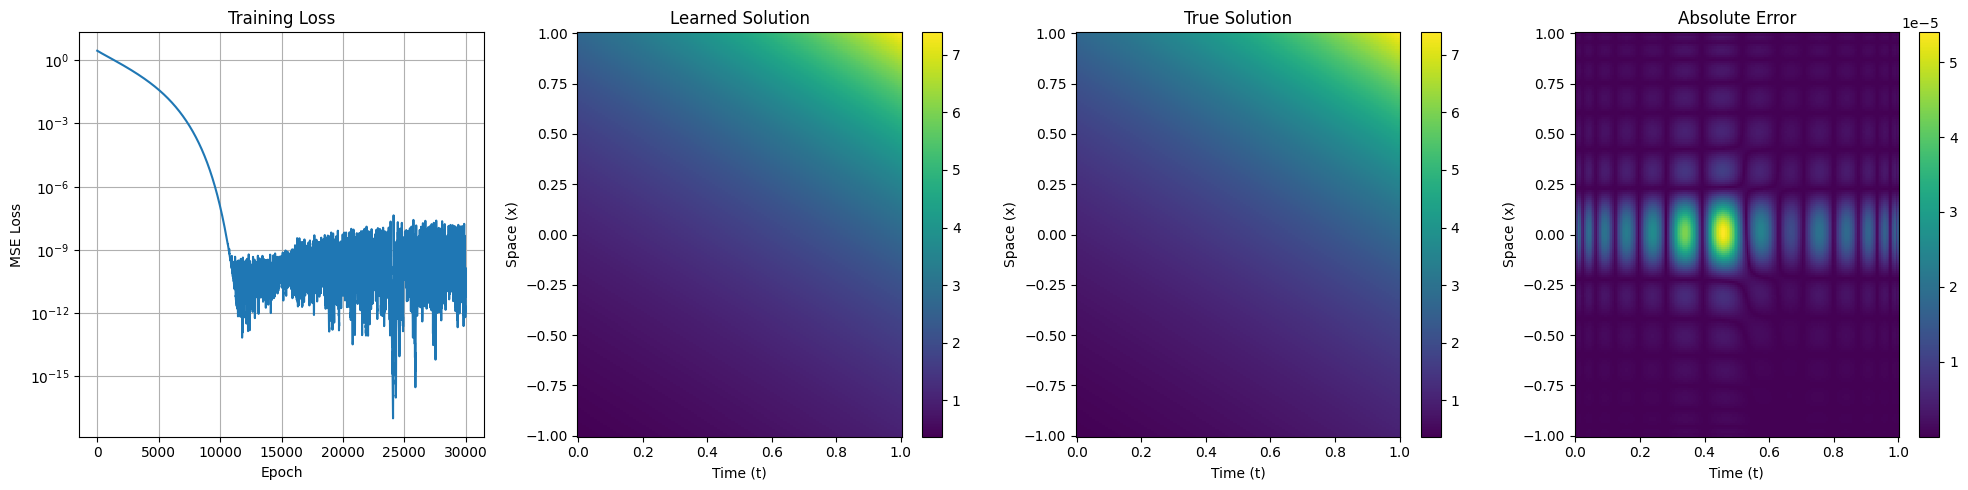

Final training loss: 3.346e-11
Maximum absolute error: 5.398e-05


In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm

def train_spectral_interpolation(n_epochs=10000):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    # Create high-resolution data grid (100x100)
    Nt_data, Nx_data = 100, 100
    t_data = torch.linspace(0, 1, Nt_data)
    x_data = torch.linspace(-1, 1, Nx_data)
    T_data, X_data = torch.meshgrid(t_data, x_data, indexing='ij')
    data_points = torch.stack([T_data.flatten(), X_data.flatten()], dim=-1)
    
    # Create true solution at data points
    u_data = torch.exp(T_data + X_data)
    
    # Create spectral interpolator with lower resolution (17x17)
    interpolator = SpectralInterpolationND(
        Ns=[17, 17],  # 17 nodes in each dimension
        bases=['chebyshev', 'chebyshev'],  # Chebyshev basis for both dimensions
        domains=[(0, 1), (-1, 1)]  # Same domains as data
    )
    
    # Initialize randomly around 1 (since exp(t+x) is always positive)
    interpolator.values.data = torch.randn_like(interpolator.values) * 0.1 + 1.0
    
    # Setup optimizer
    optimizer = torch.optim.Adam([interpolator.values], lr=1e-3)
    # optimizer = torch.optim.SGD([interpolator.values], lr=1)
    
    # Training loop
    losses = []
    
    for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()
        
        # Evaluate interpolant at data points
        u_pred = interpolator(data_points)
        
        # Compute MSE loss
        loss = torch.mean((u_pred - u_data.flatten())**2)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Store loss
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():1.3e}')
    
    # Create evaluation grid for final visualization
    t_eval = torch.linspace(0, 1, 200)
    x_eval = torch.linspace(-1, 1, 200)
    T_eval, X_eval = torch.meshgrid(t_eval, x_eval, indexing='ij')
    eval_points = torch.stack([T_eval.flatten(), X_eval.flatten()], dim=-1)
    
    # Evaluate final interpolant
    with torch.no_grad():
        u_final = interpolator(eval_points).reshape(T_eval.shape).detach()
        u_true = torch.exp(T_eval + X_eval)
        error = torch.abs(u_final - u_true)
    
    # Create visualization
    fig = plt.figure(figsize=(20, 5))
    
    # Plot 1: Training Loss
    ax1 = fig.add_subplot(141)
    ax1.semilogy(losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)
    
    # Plot 2: Learned Solution
    ax2 = fig.add_subplot(142)
    c2 = ax2.pcolormesh(T_eval.numpy(), X_eval.numpy(), u_final.numpy(), 
                        shading='auto', cmap='viridis')
    ax2.set_xlabel('Time (t)')
    ax2.set_ylabel('Space (x)')
    ax2.set_title('Learned Solution')
    plt.colorbar(c2, ax=ax2)
    
    # Plot 3: True Solution
    ax3 = fig.add_subplot(143)
    c3 = ax3.pcolormesh(T_eval.numpy(), X_eval.numpy(), u_true.numpy(), 
                        shading='auto', cmap='viridis')
    ax3.set_xlabel('Time (t)')
    ax3.set_ylabel('Space (x)')
    ax3.set_title('True Solution')
    plt.colorbar(c3, ax=ax3)
    
    # Plot 4: Error
    ax4 = fig.add_subplot(144)
    c4 = ax4.pcolormesh(T_eval.numpy(), X_eval.numpy(), error.numpy(), 
                        shading='auto', cmap='viridis')
    ax4.set_xlabel('Time (t)')
    ax4.set_ylabel('Space (x)')
    ax4.set_title('Absolute Error')
    plt.colorbar(c4, ax=ax4)
    
    plt.tight_layout()
    
    return fig, interpolator, losses, error

# Run the training
if __name__ == "__main__":
    fig, interpolator, losses, error = train_spectral_interpolation(n_epochs=30000)
    plt.show()
    
    # Print final loss
    print(f"Final training loss: {losses[-1]:1.3e}")
    print(f"Maximum absolute error: {torch.max(torch.abs(error)).item():1.3e}")

Compare to accuracy of an MLP.

  1%|          | 106/10000 [00:02<03:29, 47.23it/s]

Epoch [100/10000], Loss: 3.373e-01


  2%|▏         | 207/10000 [00:04<03:11, 51.18it/s]

Epoch [200/10000], Loss: 1.709e-01


  3%|▎         | 306/10000 [00:06<03:04, 52.47it/s]

Epoch [300/10000], Loss: 5.722e-02


  4%|▍         | 405/10000 [00:08<03:28, 46.11it/s]

Epoch [400/10000], Loss: 2.269e-02


  5%|▌         | 508/10000 [00:10<03:07, 50.58it/s]

Epoch [500/10000], Loss: 1.209e-02


  6%|▌         | 609/10000 [00:12<03:19, 47.09it/s]

Epoch [600/10000], Loss: 7.416e-03


  7%|▋         | 705/10000 [00:14<03:18, 46.80it/s]

Epoch [700/10000], Loss: 5.040e-03


  8%|▊         | 806/10000 [00:16<02:58, 51.38it/s]

Epoch [800/10000], Loss: 3.685e-03


  9%|▉         | 906/10000 [00:18<03:10, 47.84it/s]

Epoch [900/10000], Loss: 2.780e-03


 10%|█         | 1005/10000 [00:20<02:56, 50.96it/s]

Epoch [1000/10000], Loss: 2.083e-03


 11%|█         | 1107/10000 [00:22<02:56, 50.47it/s]

Epoch [1100/10000], Loss: 1.510e-03


 12%|█▏        | 1208/10000 [00:24<03:02, 48.17it/s]

Epoch [1200/10000], Loss: 1.092e-03


 13%|█▎        | 1305/10000 [00:26<02:51, 50.57it/s]

Epoch [1300/10000], Loss: 8.434e-04


 14%|█▍        | 1409/10000 [00:28<03:01, 47.25it/s]

Epoch [1400/10000], Loss: 6.768e-04


 15%|█▌        | 1508/10000 [00:30<02:50, 49.79it/s]

Epoch [1500/10000], Loss: 5.506e-04


 16%|█▌        | 1606/10000 [00:32<02:44, 51.15it/s]

Epoch [1600/10000], Loss: 4.507e-04


 17%|█▋        | 1705/10000 [00:34<02:52, 48.07it/s]

Epoch [1700/10000], Loss: 3.698e-04


 18%|█▊        | 1807/10000 [00:36<02:39, 51.33it/s]

Epoch [1800/10000], Loss: 3.044e-04


 19%|█▉        | 1907/10000 [00:38<02:39, 50.80it/s]

Epoch [1900/10000], Loss: 2.524e-04


 20%|██        | 2008/10000 [00:40<02:38, 50.38it/s]

Epoch [2000/10000], Loss: 2.119e-04


 21%|██        | 2107/10000 [00:42<02:30, 52.36it/s]

Epoch [2100/10000], Loss: 1.805e-04


 22%|██▏       | 2207/10000 [00:44<02:36, 49.87it/s]

Epoch [2200/10000], Loss: 1.558e-04


 23%|██▎       | 2309/10000 [00:46<02:34, 49.72it/s]

Epoch [2300/10000], Loss: 1.362e-04


 24%|██▍       | 2404/10000 [00:48<02:31, 50.22it/s]

Epoch [2400/10000], Loss: 1.201e-04


 25%|██▌       | 2507/10000 [00:50<02:37, 47.49it/s]

Epoch [2500/10000], Loss: 1.068e-04


 26%|██▌       | 2606/10000 [00:52<02:27, 49.97it/s]

Epoch [2600/10000], Loss: 9.555e-05


 27%|██▋       | 2706/10000 [00:54<02:31, 48.25it/s]

Epoch [2700/10000], Loss: 8.587e-05


 28%|██▊       | 2807/10000 [00:57<02:32, 47.02it/s]

Epoch [2800/10000], Loss: 7.743e-05


 29%|██▉       | 2904/10000 [00:59<02:18, 51.32it/s]

Epoch [2900/10000], Loss: 6.997e-05


 30%|███       | 3009/10000 [01:01<02:25, 47.91it/s]

Epoch [3000/10000], Loss: 6.333e-05


 31%|███       | 3107/10000 [01:03<02:19, 49.34it/s]

Epoch [3100/10000], Loss: 5.735e-05


 32%|███▏      | 3206/10000 [01:05<02:26, 46.40it/s]

Epoch [3200/10000], Loss: 5.195e-05


 33%|███▎      | 3308/10000 [01:07<02:12, 50.65it/s]

Epoch [3300/10000], Loss: 4.706e-05


 34%|███▍      | 3404/10000 [01:09<02:10, 50.60it/s]

Epoch [3400/10000], Loss: 4.261e-05


 35%|███▌      | 3509/10000 [01:11<02:12, 49.06it/s]

Epoch [3500/10000], Loss: 3.857e-05


 36%|███▌      | 3608/10000 [01:13<02:07, 50.25it/s]

Epoch [3600/10000], Loss: 3.492e-05


 37%|███▋      | 3708/10000 [01:15<02:09, 48.51it/s]

Epoch [3700/10000], Loss: 3.162e-05


 38%|███▊      | 3809/10000 [01:17<02:12, 46.71it/s]

Epoch [3800/10000], Loss: 2.865e-05


 39%|███▉      | 3906/10000 [01:19<02:00, 50.72it/s]

Epoch [3900/10000], Loss: 2.598e-05


 40%|████      | 4008/10000 [01:21<02:00, 49.68it/s]

Epoch [4000/10000], Loss: 2.360e-05


 41%|████      | 4106/10000 [01:23<01:52, 52.49it/s]

Epoch [4100/10000], Loss: 2.147e-05


 42%|████▏     | 4204/10000 [01:25<01:55, 50.07it/s]

Epoch [4200/10000], Loss: 1.957e-05


 43%|████▎     | 4305/10000 [01:27<01:58, 48.17it/s]

Epoch [4300/10000], Loss: 1.787e-05


 44%|████▍     | 4408/10000 [01:29<01:48, 51.37it/s]

Epoch [4400/10000], Loss: 1.636e-05


 45%|████▌     | 4506/10000 [01:32<01:59, 45.79it/s]

Epoch [4500/10000], Loss: 1.500e-05


 46%|████▌     | 4609/10000 [01:34<01:47, 49.98it/s]

Epoch [4600/10000], Loss: 1.380e-05


 47%|████▋     | 4708/10000 [01:36<01:57, 44.97it/s]

Epoch [4700/10000], Loss: 1.272e-05


 48%|████▊     | 4809/10000 [01:38<01:47, 48.46it/s]

Epoch [4800/10000], Loss: 1.175e-05


 49%|████▉     | 4909/10000 [01:40<01:39, 51.14it/s]

Epoch [4900/10000], Loss: 1.089e-05


 50%|█████     | 5005/10000 [01:42<01:39, 50.43it/s]

Epoch [5000/10000], Loss: 1.011e-05


 51%|█████     | 5110/10000 [01:44<01:36, 50.57it/s]

Epoch [5100/10000], Loss: 9.414e-06


 52%|█████▏    | 5209/10000 [01:46<01:40, 47.91it/s]

Epoch [5200/10000], Loss: 8.788e-06


 53%|█████▎    | 5305/10000 [01:48<01:39, 47.24it/s]

Epoch [5300/10000], Loss: 8.224e-06


 54%|█████▍    | 5406/10000 [01:50<01:31, 50.27it/s]

Epoch [5400/10000], Loss: 7.715e-06


 55%|█████▌    | 5505/10000 [01:52<01:37, 46.06it/s]

Epoch [5500/10000], Loss: 8.305e-06


 56%|█████▌    | 5606/10000 [01:54<01:35, 46.09it/s]

Epoch [5600/10000], Loss: 6.951e-06


 57%|█████▋    | 5708/10000 [01:56<01:26, 49.83it/s]

Epoch [5700/10000], Loss: 6.601e-06


 58%|█████▊    | 5807/10000 [01:58<01:24, 49.39it/s]

Epoch [5800/10000], Loss: 6.280e-06


 59%|█████▉    | 5905/10000 [02:00<01:18, 52.18it/s]

Epoch [5900/10000], Loss: 8.645e-05


 60%|██████    | 6007/10000 [02:02<01:19, 50.54it/s]

Epoch [6000/10000], Loss: 5.799e-06


 61%|██████    | 6110/10000 [02:04<01:15, 51.37it/s]

Epoch [6100/10000], Loss: 5.565e-06


 62%|██████▏   | 6205/10000 [02:06<01:14, 50.86it/s]

Epoch [6200/10000], Loss: 5.348e-06


 63%|██████▎   | 6310/10000 [02:08<01:12, 51.12it/s]

Epoch [6300/10000], Loss: 3.700e-05


 64%|██████▍   | 6405/10000 [02:10<01:12, 49.78it/s]

Epoch [6400/10000], Loss: 5.028e-06


 65%|██████▌   | 6505/10000 [02:12<01:10, 49.53it/s]

Epoch [6500/10000], Loss: 4.864e-06


 66%|██████▌   | 6605/10000 [02:14<01:07, 50.17it/s]

Epoch [6600/10000], Loss: 4.709e-06


 67%|██████▋   | 6705/10000 [02:16<01:02, 53.13it/s]

Epoch [6700/10000], Loss: 1.185e-05


 68%|██████▊   | 6806/10000 [02:18<01:04, 49.56it/s]

Epoch [6800/10000], Loss: 4.484e-06


 69%|██████▉   | 6905/10000 [02:20<01:03, 48.65it/s]

Epoch [6900/10000], Loss: 4.360e-06


 70%|███████   | 7009/10000 [02:22<00:57, 51.71it/s]

Epoch [7000/10000], Loss: 4.242e-06


 71%|███████   | 7105/10000 [02:24<01:00, 48.22it/s]

Epoch [7100/10000], Loss: 6.004e-06


 72%|███████▏  | 7207/10000 [02:27<01:00, 46.40it/s]

Epoch [7200/10000], Loss: 4.075e-06


 73%|███████▎  | 7309/10000 [02:29<00:56, 47.56it/s]

Epoch [7300/10000], Loss: 3.977e-06


 74%|███████▍  | 7406/10000 [02:31<00:54, 47.26it/s]

Epoch [7400/10000], Loss: 3.882e-06


 75%|███████▌  | 7509/10000 [02:33<00:49, 50.25it/s]

Epoch [7500/10000], Loss: 2.732e-05


 76%|███████▌  | 7609/10000 [02:35<00:47, 50.47it/s]

Epoch [7600/10000], Loss: 3.750e-06


 77%|███████▋  | 7710/10000 [02:37<00:46, 49.72it/s]

Epoch [7700/10000], Loss: 3.669e-06


 78%|███████▊  | 7805/10000 [02:39<00:44, 49.87it/s]

Epoch [7800/10000], Loss: 3.590e-06


 79%|███████▉  | 7910/10000 [02:41<00:42, 49.73it/s]

Epoch [7900/10000], Loss: 4.499e-04


 80%|████████  | 8008/10000 [02:43<00:38, 51.37it/s]

Epoch [8000/10000], Loss: 3.482e-06


 81%|████████  | 8107/10000 [02:45<00:46, 40.62it/s]

Epoch [8100/10000], Loss: 3.413e-06


 82%|████████▏ | 8208/10000 [02:47<00:38, 46.34it/s]

Epoch [8200/10000], Loss: 3.345e-06


 83%|████████▎ | 8305/10000 [02:49<00:32, 52.02it/s]

Epoch [8300/10000], Loss: 3.278e-06


 84%|████████▍ | 8409/10000 [02:51<00:31, 50.21it/s]

Epoch [8400/10000], Loss: 4.060e-06


 85%|████████▌ | 8508/10000 [02:53<00:28, 51.73it/s]

Epoch [8500/10000], Loss: 3.190e-06


 86%|████████▌ | 8609/10000 [02:55<00:27, 50.14it/s]

Epoch [8600/10000], Loss: 3.130e-06


 87%|████████▋ | 8706/10000 [02:57<00:26, 49.48it/s]

Epoch [8700/10000], Loss: 3.071e-06


 88%|████████▊ | 8810/10000 [02:59<00:23, 51.60it/s]

Epoch [8800/10000], Loss: 3.328e-04


 89%|████████▉ | 8905/10000 [03:01<00:22, 48.42it/s]

Epoch [8900/10000], Loss: 3.018e-06


 90%|█████████ | 9010/10000 [03:03<00:19, 50.40it/s]

Epoch [9000/10000], Loss: 2.939e-06


 91%|█████████ | 9108/10000 [03:05<00:18, 48.03it/s]

Epoch [9100/10000], Loss: 2.886e-06


 92%|█████████▏| 9207/10000 [03:07<00:16, 47.43it/s]

Epoch [9200/10000], Loss: 2.832e-06


 93%|█████████▎| 9309/10000 [03:09<00:13, 49.98it/s]

Epoch [9300/10000], Loss: 5.786e-05


 94%|█████████▍| 9407/10000 [03:11<00:12, 46.38it/s]

Epoch [9400/10000], Loss: 2.768e-06


 95%|█████████▌| 9505/10000 [03:13<00:10, 48.40it/s]

Epoch [9500/10000], Loss: 2.718e-06


 96%|█████████▌| 9610/10000 [03:15<00:07, 50.67it/s]

Epoch [9600/10000], Loss: 2.669e-06


 97%|█████████▋| 9708/10000 [03:18<00:06, 45.75it/s]

Epoch [9700/10000], Loss: 2.620e-06


 98%|█████████▊| 9805/10000 [03:20<00:03, 51.05it/s]

Epoch [9800/10000], Loss: 3.555e-06


 99%|█████████▉| 9908/10000 [03:22<00:01, 48.30it/s]

Epoch [9900/10000], Loss: 2.566e-06


100%|██████████| 10000/10000 [03:24<00:00, 48.97it/s]


Epoch [10000/10000], Loss: 2.520e-06


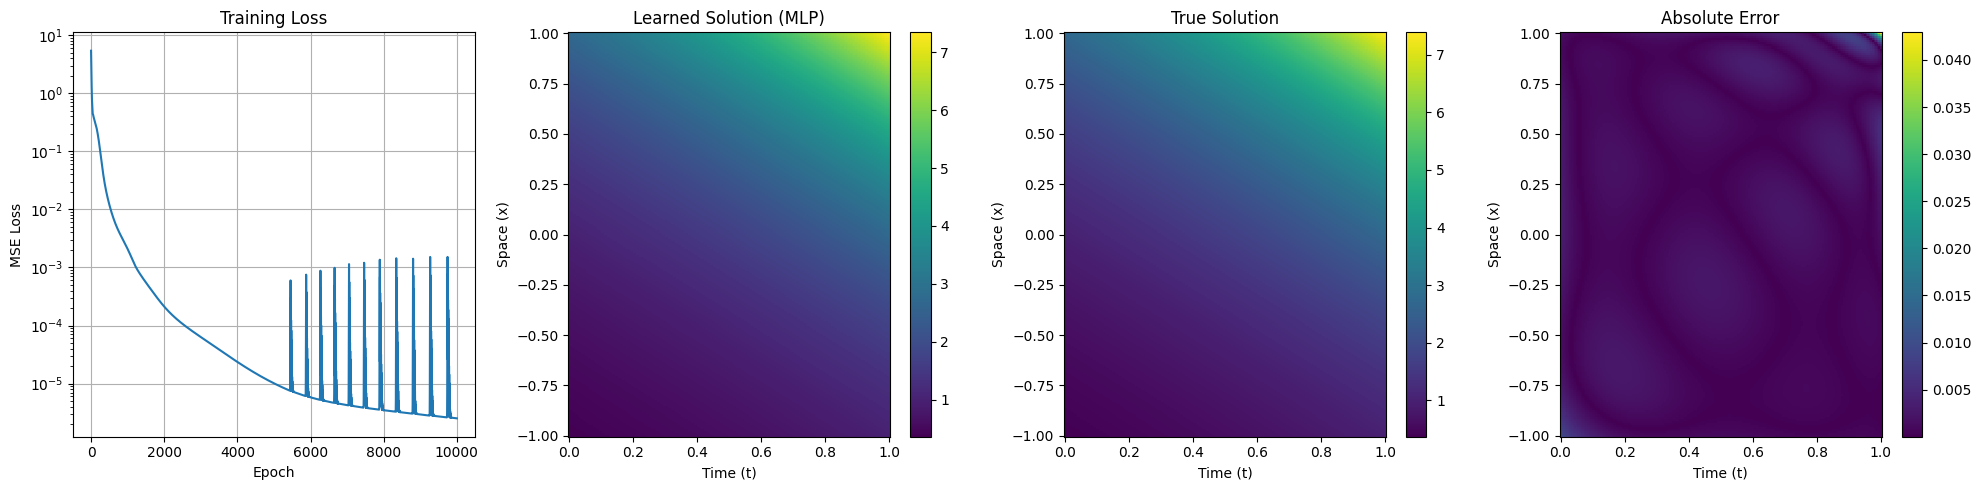

Final training loss: 2.520e-06
Maximum absolute error: 3.570e-03


In [46]:
def train_mlp_interpolation(n_epochs=10000):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    # Create high-resolution data grid (100x100)
    Nt_data, Nx_data = 100, 100
    t_data = torch.linspace(0, 1, Nt_data)
    x_data = torch.linspace(-1, 1, Nx_data)
    T_data, X_data = torch.meshgrid(t_data, x_data, indexing='ij')
    data_points = torch.stack([T_data.flatten(), X_data.flatten()], dim=-1)
    
    # Create true solution at data points
    u_data = torch.exp(T_data + X_data).flatten()
    
    # Create MLP
    model = SimpleMLP(hidden_size=64)
    
    # Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Training loop
    losses = []
    
    for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()
        
        # Forward pass
        u_pred = model(data_points)
        
        # Compute MSE loss
        loss = torch.mean((u_pred - u_data)**2)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Store loss
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():1.3e}')
    
    # Create evaluation grid for final visualization
    t_eval = torch.linspace(0, 1, 200)
    x_eval = torch.linspace(-1, 1, 200)
    T_eval, X_eval = torch.meshgrid(t_eval, x_eval, indexing='ij')
    eval_points = torch.stack([T_eval.flatten(), X_eval.flatten()], dim=-1)
    
    # Evaluate final model
    model.eval()
    with torch.no_grad():
        u_final = model(eval_points).reshape(T_eval.shape)
        u_true = torch.exp(T_eval + X_eval)
        error = torch.abs(u_final - u_true)
    
    # Create visualization
    fig = plt.figure(figsize=(20, 5))
    
    # Plot 1: Training Loss
    ax1 = fig.add_subplot(141)
    ax1.semilogy(losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)
    
    # Plot 2: Learned Solution
    ax2 = fig.add_subplot(142)
    c2 = ax2.pcolormesh(T_eval.numpy(), X_eval.numpy(), u_final.numpy(), 
                        shading='auto', cmap='viridis')
    ax2.set_xlabel('Time (t)')
    ax2.set_ylabel('Space (x)')
    ax2.set_title('Learned Solution (MLP)')
    plt.colorbar(c2, ax=ax2)
    
    # Plot 3: True Solution
    ax3 = fig.add_subplot(143)
    c3 = ax3.pcolormesh(T_eval.numpy(), X_eval.numpy(), u_true.numpy(), 
                        shading='auto', cmap='viridis')
    ax3.set_xlabel('Time (t)')
    ax3.set_ylabel('Space (x)')
    ax3.set_title('True Solution')
    plt.colorbar(c3, ax=ax3)
    
    # Plot 4: Error
    ax4 = fig.add_subplot(144)
    c4 = ax4.pcolormesh(T_eval.numpy(), X_eval.numpy(), error.numpy(), 
                        shading='auto', cmap='viridis')
    ax4.set_xlabel('Time (t)')
    ax4.set_ylabel('Space (x)')
    ax4.set_title('Absolute Error')
    plt.colorbar(c4, ax=ax4)
    
    plt.tight_layout()
    
    return fig, model, losses

# Run the training
if __name__ == "__main__":
    fig, model, losses = train_mlp_interpolation(n_epochs=10000)
    plt.show()
    
    # Print final loss and error
    print(f"Final training loss: {losses[-1]:1.3e}")
    print(f"Maximum absolute error: {torch.max(torch.abs(error)).item():1.3e}")

# Sanity check: interpolation on Allen-Cahn

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_interpolant(Nt=21, Nx=100, num_epochs=1000, lr=1e-3):
    # Create the interpolant
    interp = SpectralInterpolationND(
        Ns=[Nt, Nx],
        bases=['chebyshev', 'fourier'],
        domains=[(0, 1), (-1, 1)]
    )
    # interp = SpectralInterpolationND(
    #     Ns=[Nx, Nt],
    #     bases=['fourier', 'chebyshev'],
    #     domains=[(-1, 1), (0, 1)]
    # )
    
    # Get reference solution
    u_ref, t_star, x_star = get_allen_cahn_soln()
    
    # Create evaluation points tensor
    TT, XX = np.meshgrid(t_star, x_star, indexing='ij')
    points = torch.tensor(np.stack([TT.flatten(), XX.flatten()], axis=1), dtype=torch.float32)
    
    # Convert reference solution to tensor
    u_ref_tensor = torch.tensor(u_ref.flatten(), dtype=torch.float32)
    
    # Setup optimizer
    optimizer = optim.Adam([interp.values], lr=lr)
    
    # Training loop
    losses = []
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        
        # Forward pass
        u_pred = interp(points)
        
        # Compute loss
        loss = torch.mean((u_pred - u_ref_tensor)**2)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Store loss
        losses.append(loss.item())
        
        # Print progress
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
    
    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot loss history
    ax1.plot(losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_yscale('log')
    ax1.set_title('Training Loss')
    ax1.grid(True)
    
    # Plot final solution
    u_pred_final = interp(points).detach().numpy().reshape(TT.shape)
    
    im2 = ax2.pcolormesh(TT, XX, u_pred_final, cmap='jet', vmin=-1, vmax=1)
    ax2.set_xlabel('Time (t)')
    ax2.set_ylabel('Space (x)')
    ax2.set_title('Interpolated Solution')
    plt.colorbar(im2, ax=ax2)
    
    # Plot error
    error = np.abs(u_ref - u_pred_final)
    im3 = ax3.pcolormesh(TT, XX, error, cmap='jet')
    ax3.set_xlabel('Time (t)')
    ax3.set_ylabel('Space (x)')
    ax3.set_title('Absolute Error')
    plt.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    
    # Print final metrics
    mean_abs_error = np.mean(np.abs(u_ref - u_pred_final))
    max_abs_error = np.max(np.abs(u_ref - u_pred_final))
    print(f"\nFinal Metrics:")
    print(f"Mean Absolute Error: {mean_abs_error:.6f}")
    print(f"Max Absolute Error: {max_abs_error:.6f}")
    
    return interp, losses, u_pred_final

## Sanity check: interpolation
We look at the Allen-Cahn equation (1 space + 1 time variable, both of which we treat spectrally):

\begin{align*}
&u_t - 0.0001u_{xx} + 5u^3 - 5u = 0, \quad t \in [0,1], x \in [-1,1], \\
&u(0,x) = x^2\cos(\pi x), \\
&u(t,-1) = u(t,1), \\
&u_x(t,-1) = u_x(t,1)
\end{align*}

Solution is computed with Exponential Time Differencing.

We use trigonometric polynomials in x to enforce the boundary conditions.

We start by seeing how well a polynomial can interpolate the true solution.

In [3]:
import scipy.io
import os

data_dir = "/pscratch/sd/j/jwl50/interpolants-torch/notebooks/data"
save_dir = "/pscratch/sd/j/jwl50/interpolants-torch/notebooks/figures"

def get_allen_cahn_soln(d="1e-4"):
    data = scipy.io.loadmat(os.path.join(data_dir, f"allen_cahn_d={d}.mat"))
    u_ref = data["usol"]
    t_star = data["t"].flatten()
    x_star = data["x"].flatten()

    return u_ref, t_star, x_star

Solution shape: (201, 512)
Time points: 201 (from 0.00 to 1.00)
Spatial points: 512 (from -1.00 to 1.00)


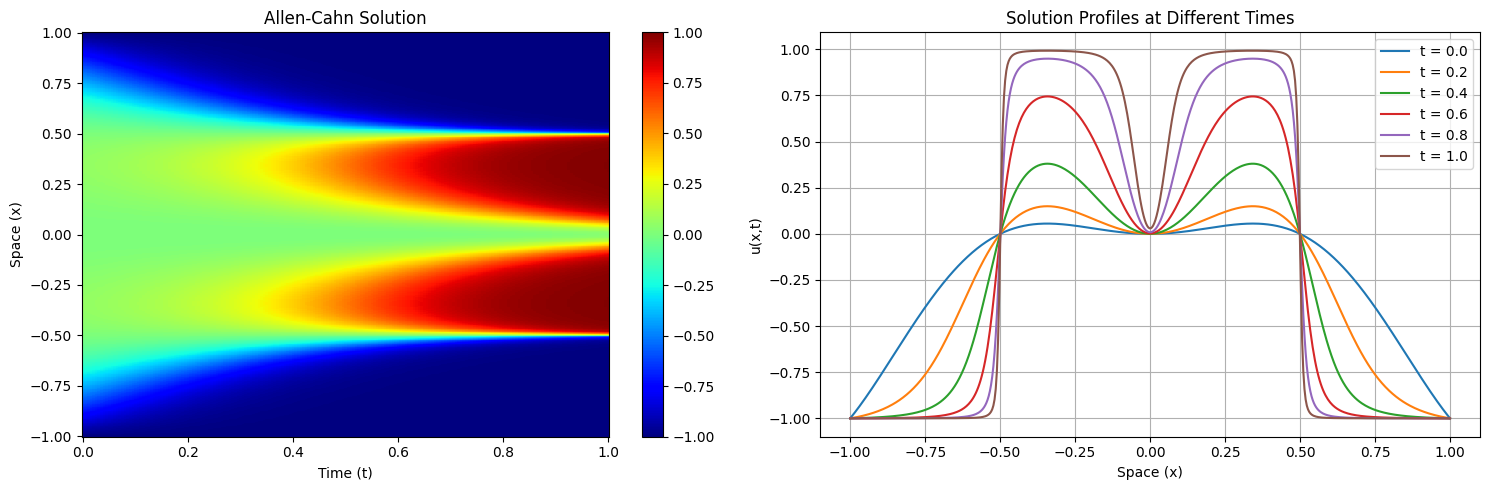

In [4]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

def plot_allen_cahn_solution(d="1e-4"):
    # Load the solution
    u_ref, t_star, x_star = get_allen_cahn_soln(d=d)
    
    # Create meshgrid for plotting
    T, X = np.meshgrid(t_star, x_star, indexing="ij")
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 2D color plot
    c1 = ax1.pcolormesh(T, X, u_ref, cmap='jet', vmin=-1, vmax=1)
    ax1.set_xlabel('Time (t)')
    ax1.set_ylabel('Space (x)')
    ax1.set_title('Allen-Cahn Solution')
    fig.colorbar(c1, ax=ax1)
    
    # Plot solution at different time points
    times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    for t in times:
        t_idx = np.abs(t_star - t).argmin()
        ax2.plot(x_star, u_ref[t_idx, :], label=f't = {t:.1f}')
    
    ax2.set_xlabel('Space (x)')
    ax2.set_ylabel('u(x,t)')
    ax2.set_title('Solution Profiles at Different Times')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    
    # Print solution information
    print(f"Solution shape: {u_ref.shape}")
    print(f"Time points: {len(t_star)} (from {t_star.min():.2f} to {t_star.max():.2f})")
    print(f"Spatial points: {len(x_star)} (from {x_star.min():.2f} to {x_star.max():.2f})")
    
    return fig

# Create and display the plot
fig = plot_allen_cahn_solution()
plt.show()

## Fit an interpolant using gradient descent

In [14]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_interpolant(Nt=21, Nx=100, num_epochs=1000, lr=1e-3):
    # Create the interpolant
    interp = SpectralInterpolationND(
        Ns=[Nt, Nx],
        bases=['chebyshev', 'fourier'],
        domains=[(0, 1), (-1, 1)]
    )
    # interp = SpectralInterpolationND(
    #     Ns=[Nx, Nt],
    #     bases=['fourier', 'chebyshev'],
    #     domains=[(-1, 1), (0, 1)]
    # )
    
    # Get reference solution
    u_ref, t_star, x_star = get_allen_cahn_soln()
    
    # Create evaluation points tensor
    TT, XX = np.meshgrid(t_star, x_star, indexing='ij')
    points = torch.tensor(np.stack([TT.flatten(), XX.flatten()], axis=1), dtype=torch.float32)
    
    # Convert reference solution to tensor
    u_ref_tensor = torch.tensor(u_ref.flatten(), dtype=torch.float32)
    
    # Setup optimizer
    optimizer = optim.Adam([interp.values], lr=lr)
    
    # Training loop
    losses = []
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        
        # Forward pass
        u_pred = interp(points)
        
        # Compute loss
        loss = torch.mean((u_pred - u_ref_tensor)**2)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Store loss
        losses.append(loss.item())
        
        # Print progress
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
    
    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot loss history
    ax1.plot(losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_yscale('log')
    ax1.set_title('Training Loss')
    ax1.grid(True)
    
    # Plot final solution
    u_pred_final = interp(points).detach().numpy().reshape(TT.shape)
    
    im2 = ax2.pcolormesh(TT, XX, u_pred_final, cmap='jet', vmin=-1, vmax=1)
    ax2.set_xlabel('Time (t)')
    ax2.set_ylabel('Space (x)')
    ax2.set_title('Interpolated Solution')
    plt.colorbar(im2, ax=ax2)
    
    # Plot error
    error = np.abs(u_ref - u_pred_final)
    im3 = ax3.pcolormesh(TT, XX, error, cmap='jet')
    ax3.set_xlabel('Time (t)')
    ax3.set_ylabel('Space (x)')
    ax3.set_title('Absolute Error')
    plt.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    
    # Print final metrics
    mean_abs_error = np.mean(np.abs(u_ref - u_pred_final))
    max_abs_error = np.max(np.abs(u_ref - u_pred_final))
    print(f"\nFinal Metrics:")
    print(f"Mean Absolute Error: {mean_abs_error:.6f}")
    print(f"Max Absolute Error: {max_abs_error:.6f}")
    
    return interp, losses, u_pred_final

In [15]:
interp, losses, u_pred = train_interpolant(Nt=21, Nx=100)
plt.show()

 10%|█         | 100/1000 [04:40<41:55,  2.80s/it]

Epoch [100/1000], Loss: 474031392006508224.000000


 20%|██        | 200/1000 [09:14<34:54,  2.62s/it]

Epoch [200/1000], Loss: 23935487436882.089844


 23%|██▎       | 227/1000 [10:29<35:42,  2.77s/it]


KeyboardInterrupt: 

## The naive interpolation, where we 1-D interpolate $N^D$ times, was way too slow.
Let's try with N-D FFT/DCT approaches for Fourier and Chebyshev.

## Fourier

Mean absolute error (old method): 1.796e-16
Mean absolute error (new method): 1.814e-08


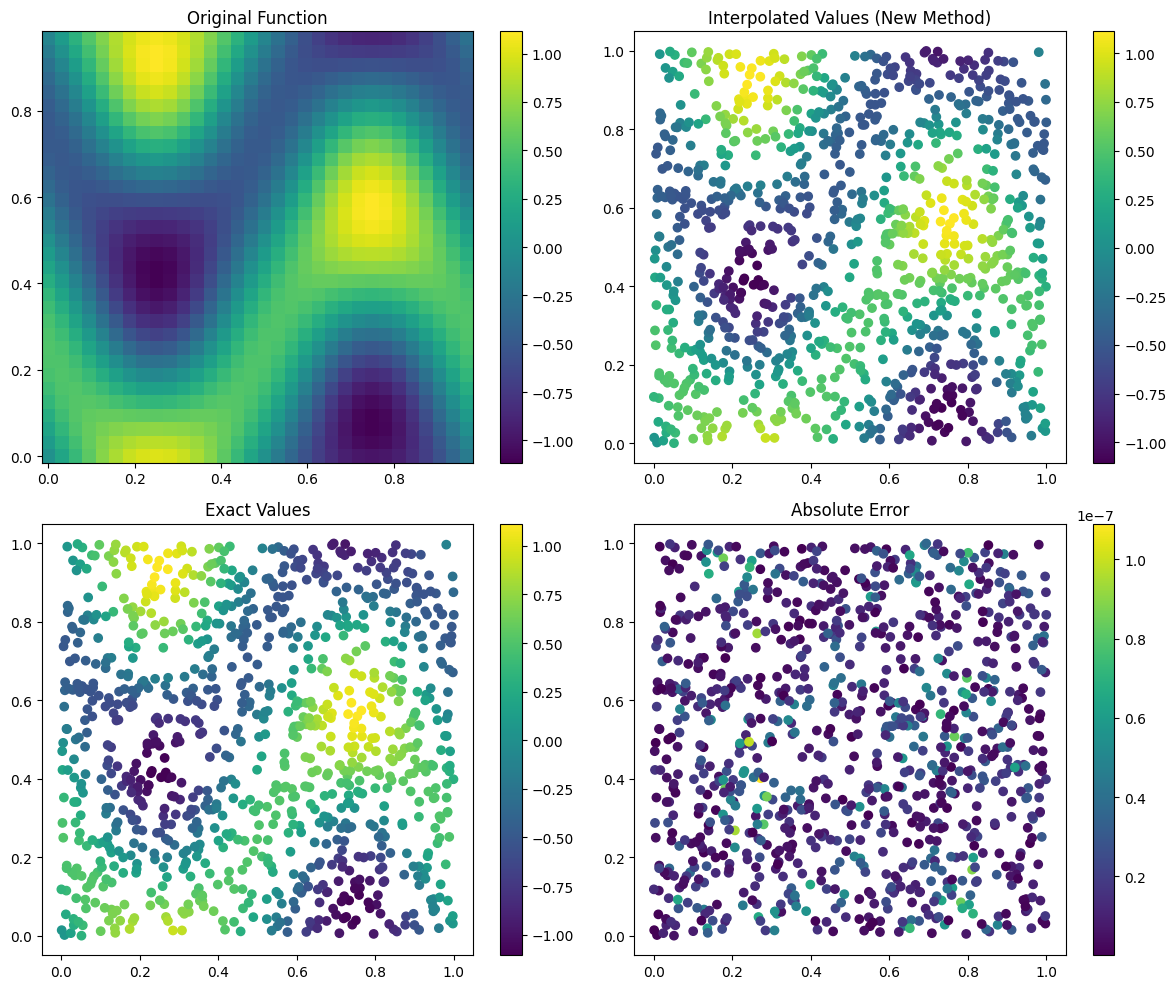

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def test_2d_fft_interpolation():
    # Create a smooth periodic test function
    def test_function(x, y):
        return torch.sin(2*np.pi*x) * torch.cos(2*np.pi*y) + 0.5*torch.cos(4*np.pi*x) * torch.sin(2*np.pi*y)

    # Add efficient 2D Fourier interpolation method to SpectralInterpolationND
    def _fourier_interpolate_2d(self, x_eval, values):
        """
        Efficient 2D Fourier interpolation using direct 2D FFT
        
        Args:
            x_eval: Points to evaluate at, shape (N, 2)
            values: Values at grid points, shape (N1, N2)
            
        Returns:
            Interpolated values at x_eval points
        """
        assert len(self.Ns) == 2 and all(b == 'fourier' for b in self.bases), "Only for 2D Fourier"
        
        # Compute 2D FFT of values
        coeffs = torch.fft.fftn(values)
        
        # Get frequencies for both dimensions
        k1 = self.k[0]  # frequencies for first dimension
        k2 = self.k[1]  # frequencies for second dimension
        
        # Map evaluation points to standard domain [0, 2π]
        x_std = self._to_standard[0](x_eval[:, 0])
        y_std = self._to_standard[1](x_eval[:, 1])
        
        # Initialize result
        result = torch.zeros(len(x_eval), dtype=torch.complex64)
        
        # Direct evaluation of 2D Fourier series
        for i, (kx, coeff_row) in enumerate(zip(k1, coeffs)):
            for j, (ky, coeff) in enumerate(zip(k2, coeff_row)):
                phase = kx * x_std[:, None] + ky * y_std[:, None]
                result += coeff * torch.exp(1j * phase).squeeze()
                
        return torch.real(result) / (self.Ns[0] * self.Ns[1])
    
    # Add method to SpectralInterpolationND class
    SpectralInterpolationND._fourier_interpolate_2d = _fourier_interpolate_2d
    
    # Test the implementation
    Nx = Ny = 32
    interp = SpectralInterpolationND(
        Ns=[Nx, Ny],
        bases=['fourier', 'fourier'],
        domains=[(0, 1), (0, 1)]
    )
    
    # Create grid points and evaluate test function
    x = interp.nodes[0]
    y = interp.nodes[1]
    X, Y = torch.meshgrid(x, y, indexing='ij')
    values = test_function(X, Y)
    interp.values.data = values
    
    # Create evaluation points
    x_eval = torch.rand(1000, 2)  # Random points in [0,1] × [0,1]
    
    # Compute exact and interpolated values
    exact = test_function(x_eval[:, 0], x_eval[:, 1])
    interp_old = interp.interpolate(x_eval, values)
    
    # Override interpolate method temporarily for testing
    original_interpolate = interp.interpolate
    interp.interpolate = lambda x, v: interp._fourier_interpolate_2d(x, v)
    interp_new = interp.interpolate(x_eval, values)
    
    # Reset interpolate method
    interp.interpolate = original_interpolate
    
    # Compute errors
    error_old = torch.abs(exact - interp_old).mean()
    error_new = torch.abs(exact - interp_new).mean()
    
    print(f"Mean absolute error (old method): {error_old:.3e}")
    print(f"Mean absolute error (new method): {error_new:.3e}")
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot original function
    im1 = axes[0,0].pcolormesh(X.numpy(), Y.numpy(), values.numpy(), shading='auto')
    axes[0,0].set_title("Original Function")
    plt.colorbar(im1, ax=axes[0,0])
    
    # Plot interpolated values (new method)
    scatter1 = axes[0,1].scatter(x_eval[:, 0], x_eval[:, 1], c=interp_new, cmap='viridis')
    axes[0,1].set_title("Interpolated Values (New Method)")
    plt.colorbar(scatter1, ax=axes[0,1])
    
    # Plot exact values at evaluation points
    scatter2 = axes[1,0].scatter(x_eval[:, 0], x_eval[:, 1], c=exact, cmap='viridis')
    axes[1,0].set_title("Exact Values")
    plt.colorbar(scatter2, ax=axes[1,0])
    
    # Plot absolute error
    scatter3 = axes[1,1].scatter(x_eval[:, 0], x_eval[:, 1], c=torch.abs(exact - interp_new), cmap='viridis')
    axes[1,1].set_title("Absolute Error")
    plt.colorbar(scatter3, ax=axes[1,1])
    
    plt.tight_layout()
    return fig

# Run the test
fig = test_2d_fft_interpolation()
plt.show()


Training with resolution Nx=8, Ny=8
Epoch [100/1000], Loss: 8.348e-03
Epoch [200/1000], Loss: 1.009e-04
Epoch [300/1000], Loss: 2.225e-07
Epoch [400/1000], Loss: 3.841e-11
Epoch [500/1000], Loss: 3.316e-16
Epoch [600/1000], Loss: 7.054e-21
Epoch [700/1000], Loss: 4.558e-08
Epoch [800/1000], Loss: 7.632e-10
Epoch [900/1000], Loss: 1.407e-11
Epoch [1000/1000], Loss: 5.651e-11

Final Metrics:
MSE Loss: 5.651e-11
Max Absolute Error: 3.728e-05
Mean Absolute Error: 4.397e-06


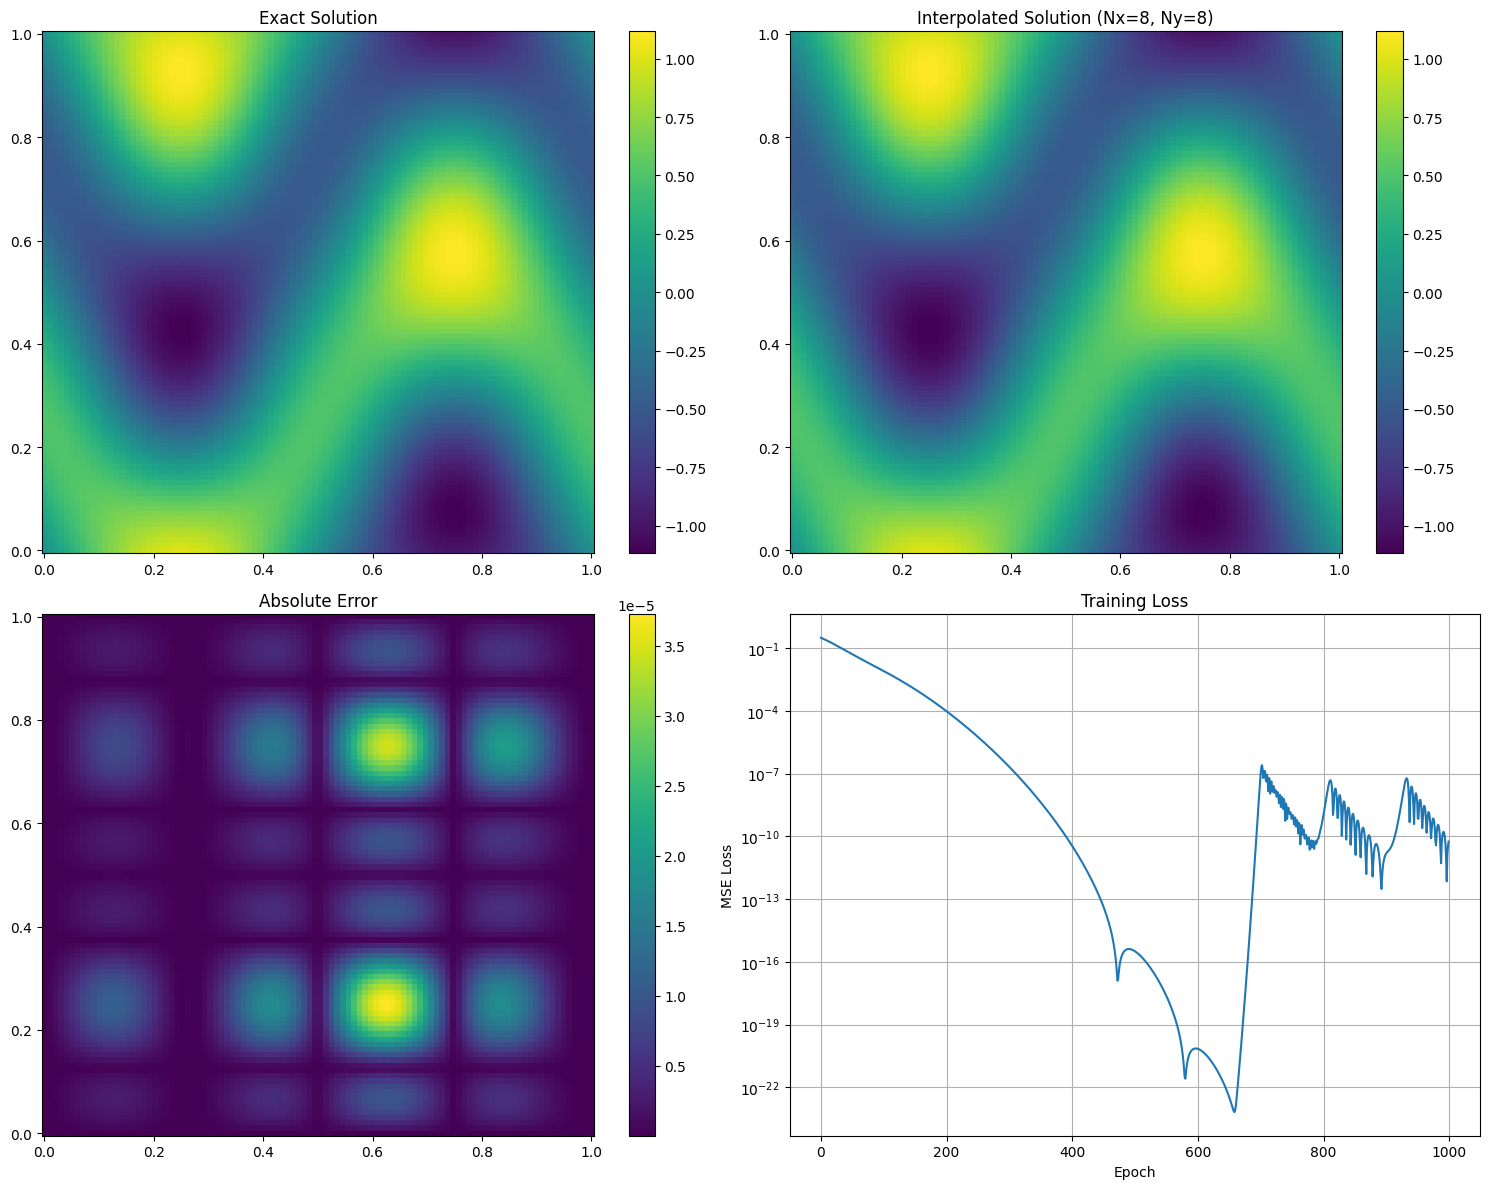


Training with resolution Nx=16, Ny=16
Epoch [100/1000], Loss: 7.445e-03
Epoch [200/1000], Loss: 4.572e-05
Epoch [300/1000], Loss: 5.484e-08
Epoch [400/1000], Loss: 2.845e-11
Epoch [500/1000], Loss: 1.746e-15
Epoch [600/1000], Loss: 3.364e-20
Epoch [700/1000], Loss: 2.369e-22
Epoch [800/1000], Loss: 3.457e-11
Epoch [900/1000], Loss: 4.052e-15
Epoch [1000/1000], Loss: 1.567e-19

Final Metrics:
MSE Loss: 1.567e-19
Max Absolute Error: 3.570e-09
Mean Absolute Error: 1.510e-10


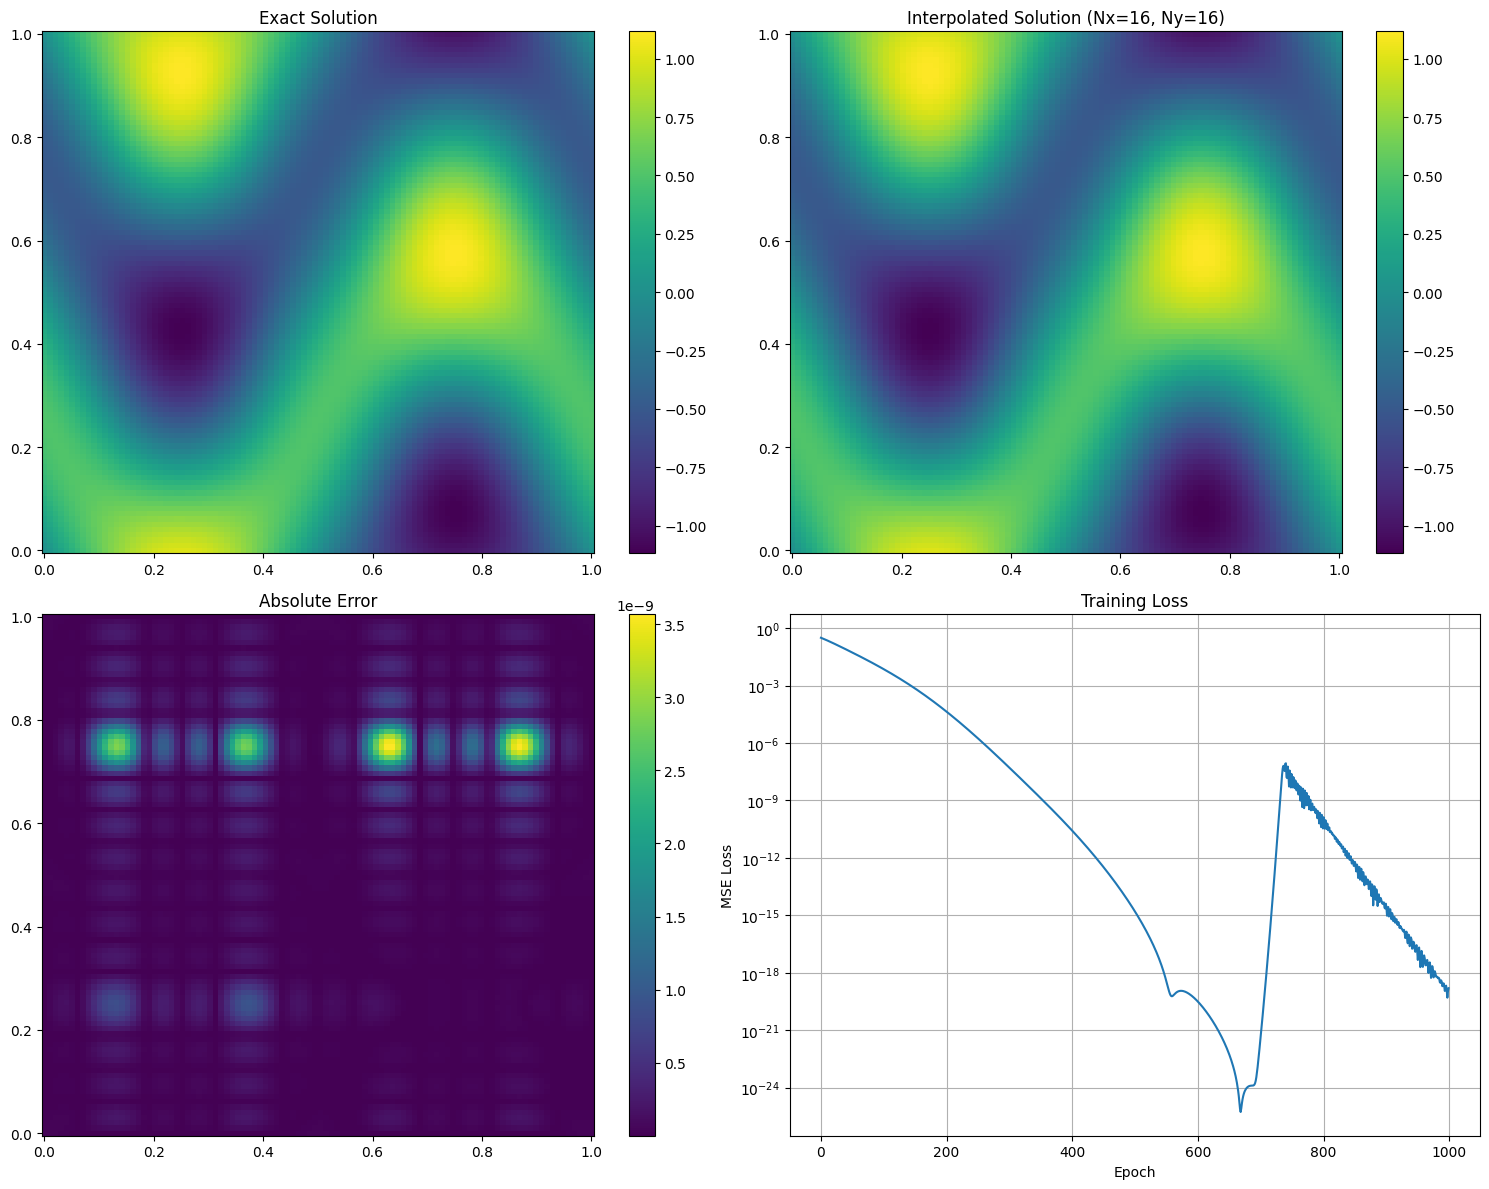


Training with resolution Nx=32, Ny=32
Epoch [100/1000], Loss: 7.445e-03
Epoch [200/1000], Loss: 4.662e-05
Epoch [300/1000], Loss: 4.026e-08
Epoch [400/1000], Loss: 1.171e-12
Epoch [500/1000], Loss: 4.021e-17
Epoch [600/1000], Loss: 8.202e-22
Epoch [700/1000], Loss: 8.054e-27
Epoch [800/1000], Loss: 7.395e-31
Epoch [900/1000], Loss: 1.365e-31
Epoch [1000/1000], Loss: 2.019e-19

Final Metrics:
MSE Loss: 2.019e-19
Max Absolute Error: 1.320e-08
Mean Absolute Error: 8.138e-11


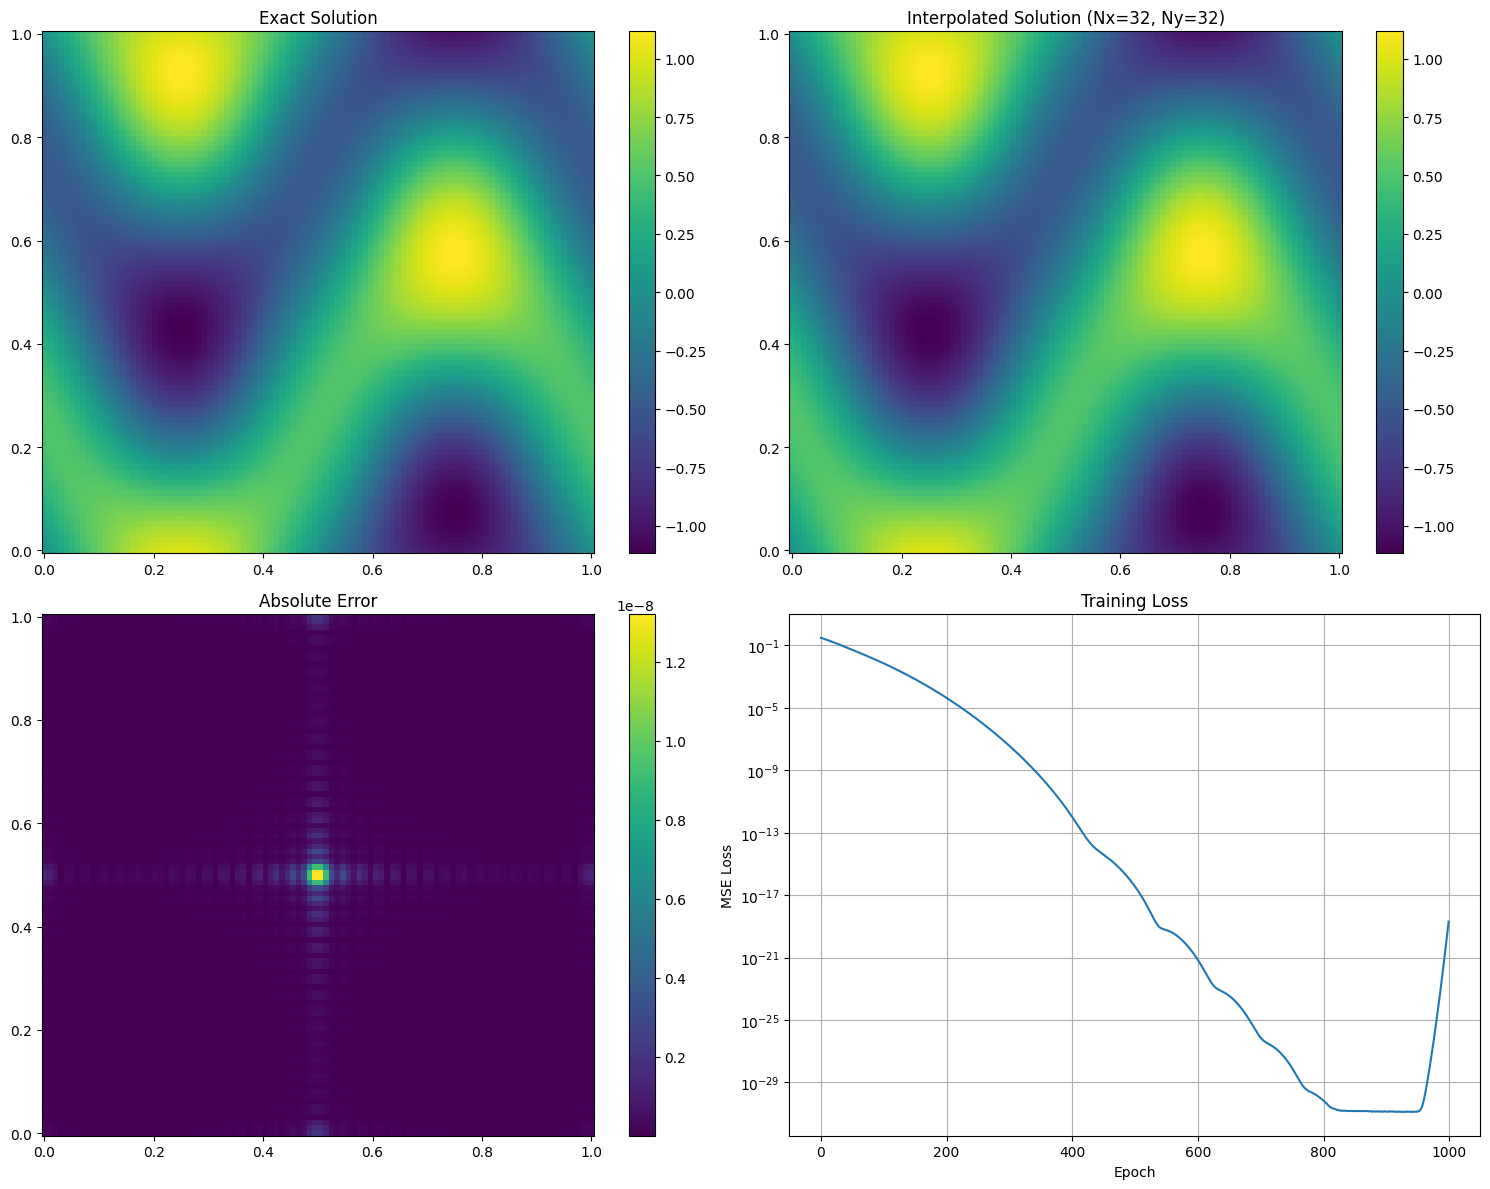


Training with resolution Nx=64, Ny=64
Epoch [100/1000], Loss: 7.445e-03
Epoch [200/1000], Loss: 4.664e-05
Epoch [300/1000], Loss: 4.026e-08
Epoch [400/1000], Loss: 1.119e-12
Epoch [500/1000], Loss: 3.576e-17
Epoch [600/1000], Loss: 1.258e-14
Epoch [700/1000], Loss: 3.545e-13
Epoch [800/1000], Loss: 9.906e-10
Epoch [900/1000], Loss: 2.714e-10
Epoch [1000/1000], Loss: 7.784e-10

Final Metrics:
MSE Loss: 7.784e-10
Max Absolute Error: 1.128e-03
Mean Absolute Error: 5.317e-06


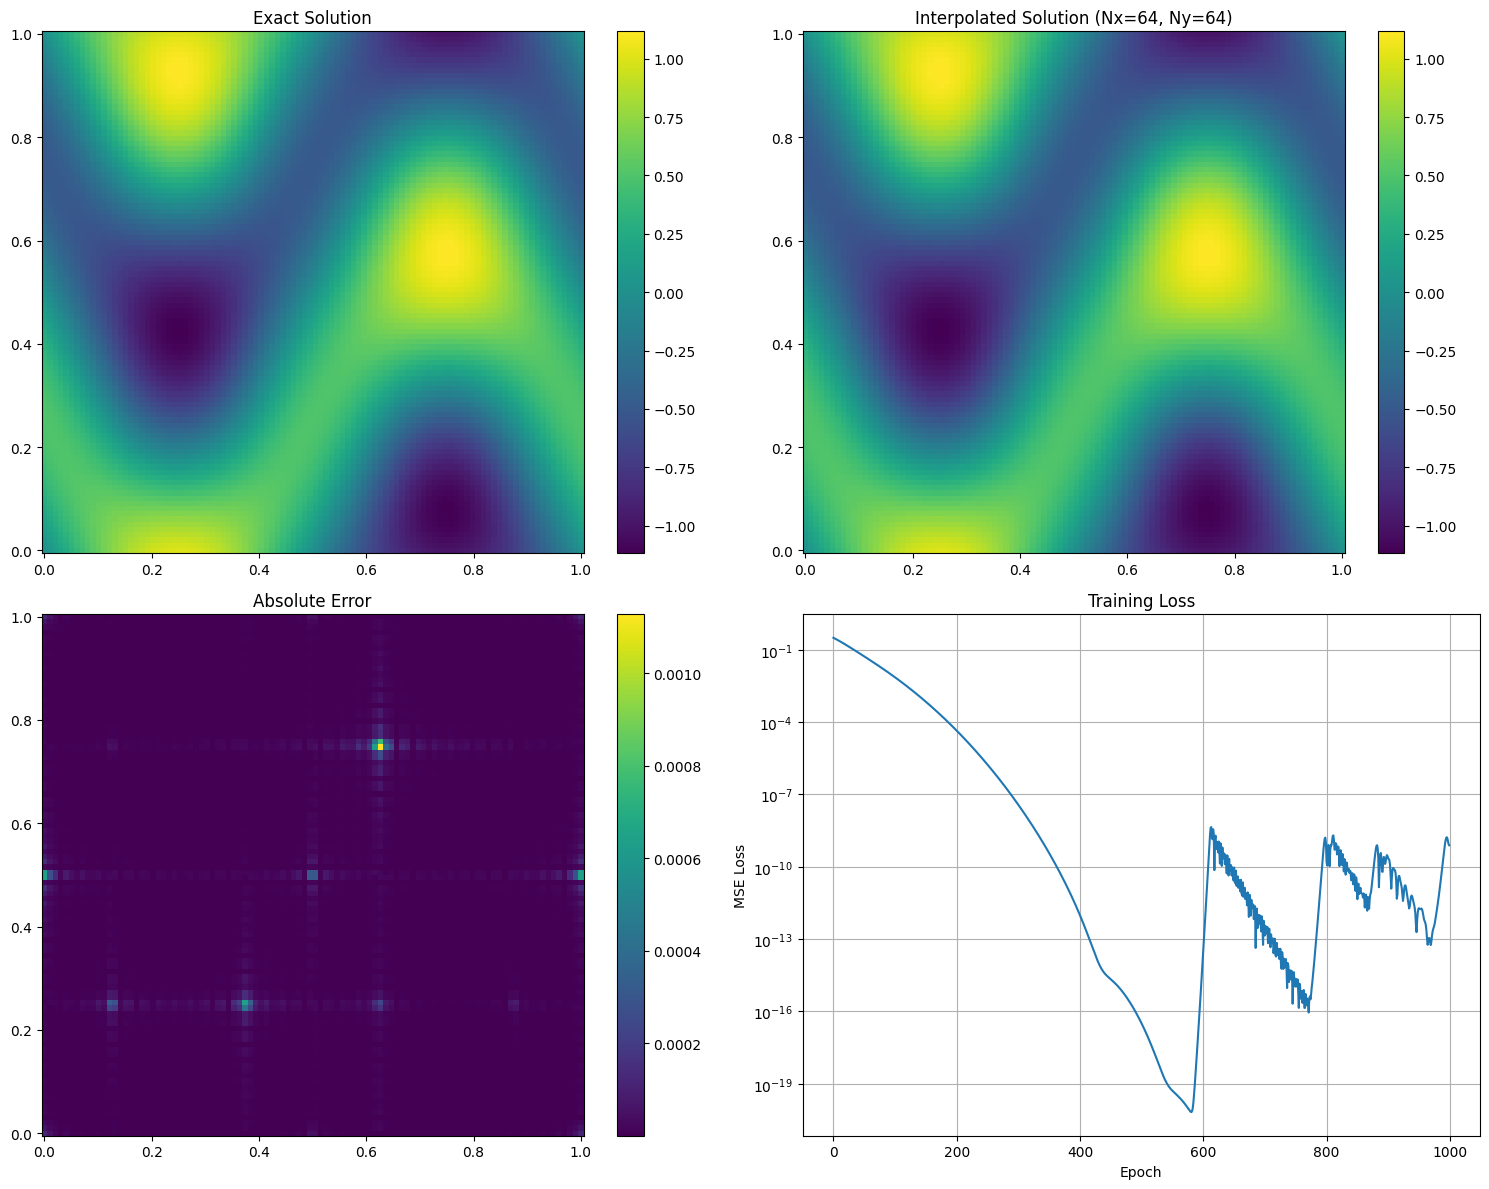


Training with resolution Nx=128, Ny=128


KeyboardInterrupt: 

In [22]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def train_periodic_interpolant(Nx=32, Ny=32, num_epochs=1000, lr=1e-2):
    # Define test function
    def test_function(x, y):
        return torch.sin(2*np.pi*x) * torch.cos(2*np.pi*y) + 0.5*torch.cos(4*np.pi*x) * torch.sin(2*np.pi*y)
    
    # Create the interpolant
    interp = SpectralInterpolationND(
        Ns=[Nx, Ny],
        bases=['fourier', 'fourier'],
        domains=[(0, 1), (0, 1)]
    )
    
    # Create reference grid for exact solution
    t = torch.linspace(0, 1, 100)
    x = torch.linspace(0, 1, 100)
    TT, XX = torch.meshgrid(t, x, indexing='ij')
    points_ref = torch.stack([
        TT.flatten(),
        XX.flatten()
    ], dim=1)
    
    # Get exact solution on reference grid
    u_exact = test_function(points_ref[:, 0], points_ref[:, 1])
    
    # Setup optimizer
    optimizer = optim.Adam([interp.values], lr=lr)
    
    # Training loop
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        u_pred = interp(points_ref)
        
        # Compute loss
        loss = torch.mean((u_pred - u_exact)**2)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Store loss
        losses.append(loss.item())
        
        # Print progress
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():1.3e}')
    
    # Plot results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot exact solution
    u_exact_grid = u_exact.reshape(100, 100)
    im1 = ax1.pcolormesh(TT.numpy(), XX.numpy(), u_exact_grid, cmap='viridis')
    ax1.set_title('Exact Solution')
    plt.colorbar(im1, ax=ax1)
    
    # Plot interpolated solution
    u_pred_grid = u_pred.detach().reshape(100, 100)
    im2 = ax2.pcolormesh(TT.numpy(), XX.numpy(), u_pred_grid, cmap='viridis')
    ax2.set_title(f'Interpolated Solution (Nx={Nx}, Ny={Ny})')
    plt.colorbar(im2, ax=ax2)
    
    # Plot absolute error
    error = torch.abs(u_exact_grid - u_pred_grid.detach())
    im3 = ax3.pcolormesh(TT.numpy(), XX.numpy(), error, cmap='viridis')
    ax3.set_title('Absolute Error')
    plt.colorbar(im3, ax=ax3)
    
    # Plot loss history
    ax4.plot(losses)
    ax4.set_yscale('log')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('MSE Loss')
    ax4.set_title('Training Loss')
    ax4.grid(True)
    
    plt.tight_layout()
    
    # Print final metrics
    final_loss = losses[-1]
    max_error = error.max()
    mean_error = error.mean()
    print(f"\nFinal Metrics:")
    print(f"MSE Loss: {final_loss:1.3e}")
    print(f"Max Absolute Error: {max_error:1.3e}")
    print(f"Mean Absolute Error: {mean_error:1.3e}")
    
    return interp, losses, error

# Run training with different resolutions
resolutions = [(8, 8), (16, 16), (32, 32), (64, 64), (128, 128)]
for Nx, Ny in resolutions:
    print(f"\nTraining with resolution Nx={Nx}, Ny={Ny}")
    interp, losses, error = train_periodic_interpolant(Nx=Nx, Ny=Ny)
    plt.show()

## Chebyshev

Mean absolute error (old method): 2.344e-16
Mean absolute error (new method): 4.808e-01


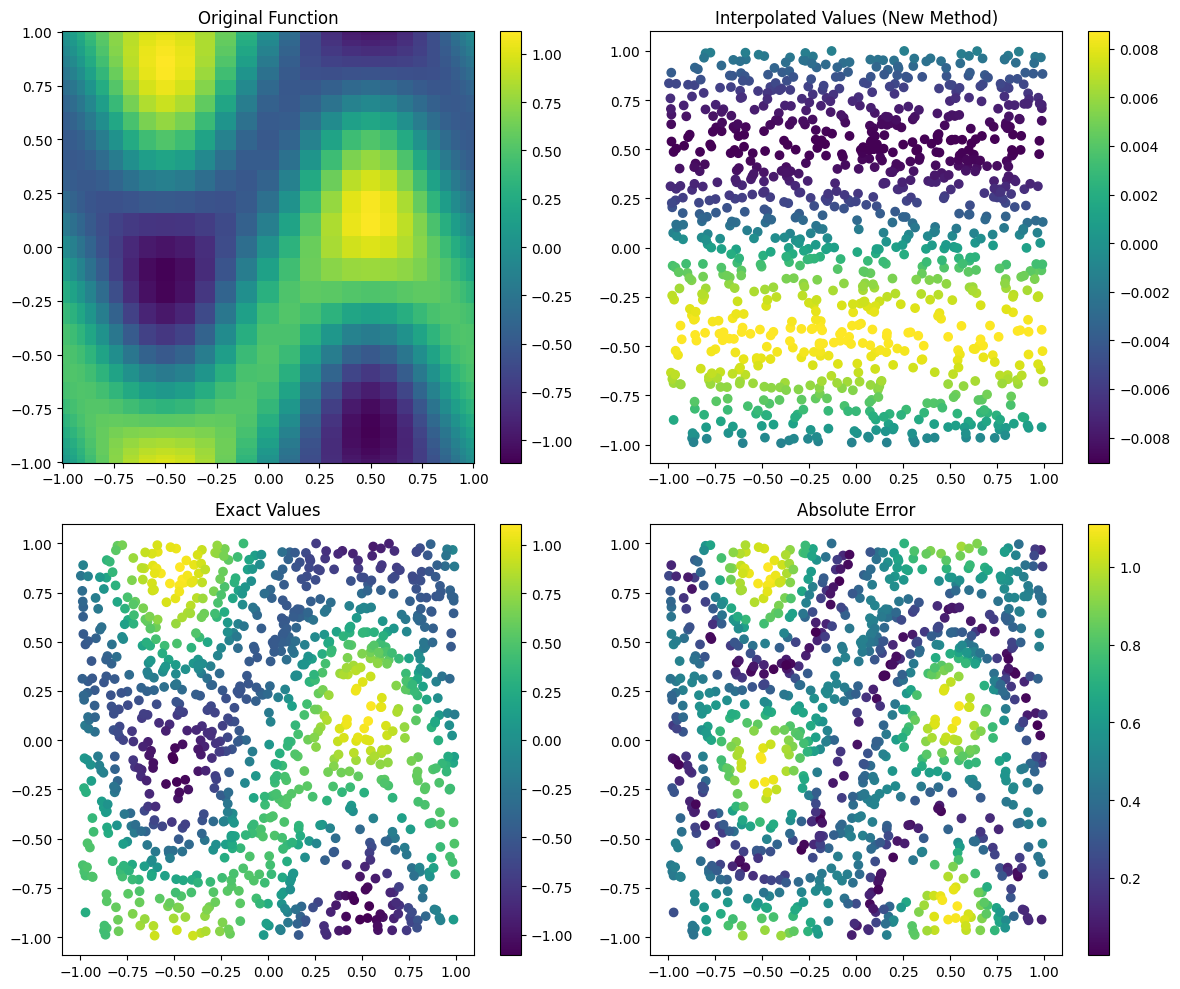

In [28]:
import torch
import numpy as np
from scipy.fft import dct
import matplotlib.pyplot as plt

def test_2d_chebyshev_interpolation():
    # Create a smooth (non-periodic) test function
    def test_function(x, y):
        # Map from [-1,1] to [0,1] for comparison with Fourier case
        x_mapped = (x + 1)/2
        y_mapped = (y + 1)/2
        return torch.sin(2*np.pi*x_mapped) * torch.cos(2*np.pi*y_mapped) + \
               0.5*torch.cos(4*np.pi*x_mapped) * torch.sin(2*np.pi*y_mapped)

    def _chebyshev_interpolate_2d(self, x_eval, values):
        """
        Efficient 2D Chebyshev interpolation using DCT and Clenshaw algorithm
        
        Args:
            x_eval: Points to evaluate at, shape (N, 2)
            values: Values at grid points, shape (N1, N2)
        """
        assert len(self.Ns) == 2 and all(b == 'chebyshev' for b in self.bases), \
               "Only for 2D Chebyshev"
        
        # Map evaluation points to standard domain [-1,1]
        x_std = self._to_standard[0](x_eval[:, 0])
        y_std = self._to_standard[1](x_eval[:, 1])
        
        # Get DCT of values using scipy and convert back to torch
        values_np = values.detach().numpy()
        coeffs_np = dct(dct(values_np, axis=0, type=2, norm='ortho'), axis=1, type=2, norm='ortho')
        coeffs = torch.from_numpy(coeffs_np).float()
        
        # Implement 2D Clenshaw algorithm
        def clenshaw_evaluate_2d(x, y, coeffs):
            N, M = coeffs.shape
            
            # Ensure points are in [-1,1]
            x = torch.clamp(x, -1, 1)
            y = torch.clamp(y, -1, 1)
            
            def clenshaw_1d(t, coeffs):
                """
                1D Clenshaw algorithm for vector input t and coefficients
                t: (...) tensor of points
                coeffs: (N,) or (N, ...) tensor of coefficients
                """
                if coeffs.dim() == 1:
                    coeffs = coeffs.view(-1, 1)
                n = coeffs.shape[0]
                
                b_current = torch.zeros_like(t)
                b_prev = torch.zeros_like(t)
                b_prev2 = torch.zeros_like(t)
                
                for k in range(n-1, 0, -1):
                    b_prev2 = b_prev
                    b_prev = b_current
                    b_current = 2 * t * b_prev - b_prev2 + coeffs[k]
                
                return coeffs[0] + t * b_current - b_prev
            
            # Apply Clenshaw along first dimension for each y value
            result = torch.zeros((len(x), M), dtype=coeffs.dtype, device=coeffs.device)
            for j in range(M):
                result[:, j] = clenshaw_1d(x, coeffs[:, j])
            
            # Apply Clenshaw along second dimension for each result
            final_result = torch.zeros(len(y), dtype=coeffs.dtype, device=coeffs.device)
            for i in range(len(x)):
                final_result = clenshaw_1d(y, result[i, :])
            
            return final_result
        
        # Evaluate using Clenshaw
        result = clenshaw_evaluate_2d(x_std, y_std, coeffs)
        return result / (self.Ns[0] * self.Ns[1])
    
    # Add method to SpectralInterpolationND class
    SpectralInterpolationND._chebyshev_interpolate_2d = _chebyshev_interpolate_2d
    
    # Test the implementation
    Nx = Ny = 31
    interp = SpectralInterpolationND(
        Ns=[Nx, Ny],
        bases=['chebyshev', 'chebyshev'],
        domains=[(-1, 1), (-1, 1)]
    )
    
    # Create grid points and evaluate test function
    x = interp.nodes[0]
    y = interp.nodes[1]
    X, Y = torch.meshgrid(x, y, indexing='ij')
    values = test_function(X, Y)
    interp.values.data = values
    
    # Create evaluation points
    x_eval = torch.rand(1000, 2) * 2 - 1  # Random points in [-1,1] × [-1,1]
    
    # Compute exact and interpolated values
    exact = test_function(x_eval[:, 0], x_eval[:, 1])
    interp_old = interp.interpolate(x_eval, values)
    
    # Override interpolate method temporarily for testing
    original_interpolate = interp.interpolate
    interp.interpolate = lambda x, v: interp._chebyshev_interpolate_2d(x, v)
    interp_new = interp.interpolate(x_eval, values)
    
    # Reset interpolate method
    interp.interpolate = original_interpolate
    
    # Compute errors
    error_old = torch.abs(exact - interp_old).mean()
    error_new = torch.abs(exact - interp_new).mean()
    
    print(f"Mean absolute error (old method): {error_old:1.3e}")
    print(f"Mean absolute error (new method): {error_new:1.3e}")
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot original function
    im1 = axes[0,0].pcolormesh(X.numpy(), Y.numpy(), values.numpy(), shading='auto')
    axes[0,0].set_title("Original Function")
    plt.colorbar(im1, ax=axes[0,0])
    
    # Plot interpolated values (new method)
    scatter1 = axes[0,1].scatter(x_eval[:, 0], x_eval[:, 1], c=interp_new, cmap='viridis')
    axes[0,1].set_title("Interpolated Values (New Method)")
    plt.colorbar(scatter1, ax=axes[0,1])
    
    # Plot exact values at evaluation points
    scatter2 = axes[1,0].scatter(x_eval[:, 0], x_eval[:, 1], c=exact, cmap='viridis')
    axes[1,0].set_title("Exact Values")
    plt.colorbar(scatter2, ax=axes[1,0])
    
    # Plot absolute error
    scatter3 = axes[1,1].scatter(x_eval[:, 0], x_eval[:, 1], 
                                c=torch.abs(exact - interp_new), cmap='viridis')
    axes[1,1].set_title("Absolute Error")
    plt.colorbar(scatter3, ax=axes[1,1])
    
    plt.tight_layout()
    return fig

# Run the test
fig = test_2d_chebyshev_interpolation()
plt.show()

Mean absolute error: 7.891e-16
Maximum absolute error: 4.441e-15


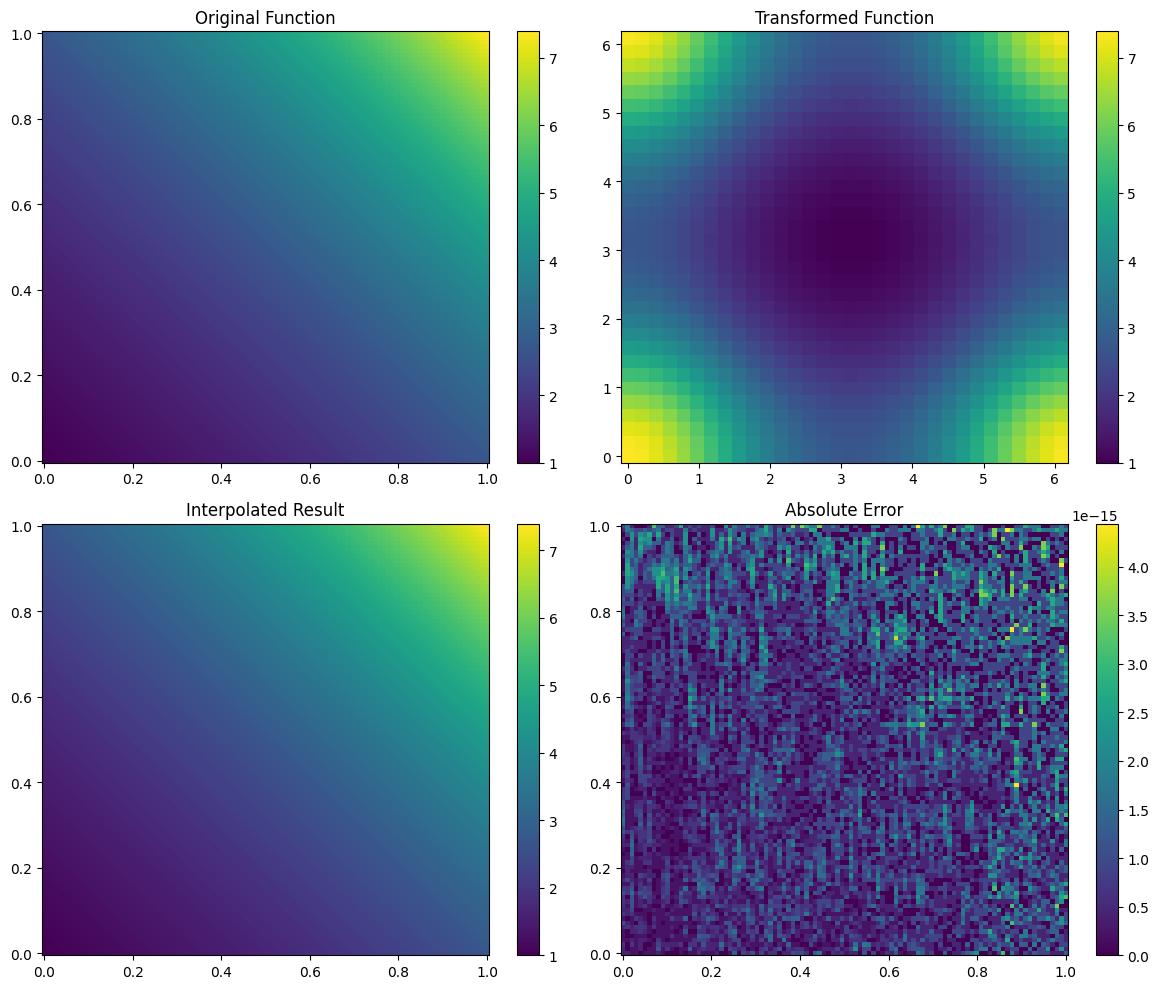

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def test_chebyshev_via_fourier():
    # Create a non-periodic test function on [0,1]×[0,1]
    def test_function(x, y):
        return torch.exp(x+y)
    
    # Transform function to periodic domain
    def transformed_function(theta, phi):
        # Map back to [0,1]×[0,1]
        x = torch.cos(theta)/2 + 0.5
        y = torch.cos(phi)/2 + 0.5
        return test_function(x, y)
    
    # Create interpolant for transformed function
    Nx = Ny = 32
    interp = SpectralInterpolationND(
        Ns=[Nx, Ny],
        bases=['fourier', 'fourier'],
        domains=[(0, 2*np.pi), (0, 2*np.pi)]
    )
    
    # Sample transformed function at grid points
    theta = interp.nodes[0]
    phi = interp.nodes[1]
    THETA, PHI = torch.meshgrid(theta, phi, indexing='ij')
    values = transformed_function(THETA, PHI)
    interp.values.data = values
    
    # Create evaluation points in original domain
    x_eval = torch.linspace(0, 1, 100)
    y_eval = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_eval, y_eval, indexing='ij')
    
    # Transform evaluation points
    theta_eval = torch.arccos(2*X.flatten() - 1)
    phi_eval = torch.arccos(2*Y.flatten() - 1)
    points_eval = torch.stack([theta_eval, phi_eval], dim=1)
    
    # Interpolate
    interp_values = interp(points_eval)
    
    # Compute exact values for comparison
    exact_values = test_function(X.flatten(), Y.flatten())
    
    # Reshape results
    interp_grid = interp_values.reshape(100, 100)
    exact_grid = exact_values.reshape(100, 100)
    error = torch.abs(interp_grid - exact_grid)
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original function
    im1 = axes[0,0].pcolormesh(X.numpy(), Y.numpy(), exact_grid.detach().numpy(), 
                              shading='auto')
    axes[0,0].set_title("Original Function")
    plt.colorbar(im1, ax=axes[0,0])
    
    # Transformed function
    im2 = axes[0,1].pcolormesh(THETA.numpy(), PHI.numpy(), values.detach().numpy(), 
                              shading='auto')
    axes[0,1].set_title("Transformed Function")
    plt.colorbar(im2, ax=axes[0,1])
    
    # Interpolated result
    im3 = axes[1,0].pcolormesh(X.numpy(), Y.numpy(), interp_grid.detach().numpy(), 
                              shading='auto')
    axes[1,0].set_title("Interpolated Result")
    plt.colorbar(im3, ax=axes[1,0])
    
    # Error
    im4 = axes[1,1].pcolormesh(X.numpy(), Y.numpy(), error.detach().numpy(), 
                              shading='auto')
    axes[1,1].set_title("Absolute Error")
    plt.colorbar(im4, ax=axes[1,1])
    
    plt.tight_layout()
    
    # Print error metrics
    mean_error = error.mean().item()
    max_error = error.max().item()
    print(f"Mean absolute error: {mean_error:1.3e}")
    print(f"Maximum absolute error: {max_error:1.3e}")
    
    return fig

# Run the test
fig = test_chebyshev_via_fourier()
plt.show()


Training with resolution N=16x16
Epoch [100/10000], Loss: 5.614e+00
Epoch [200/10000], Loss: 2.983e+00
Epoch [300/10000], Loss: 1.571e+00
Epoch [400/10000], Loss: 8.198e-01
Epoch [500/10000], Loss: 4.227e-01
Epoch [600/10000], Loss: 2.144e-01
Epoch [700/10000], Loss: 1.066e-01
Epoch [800/10000], Loss: 5.190e-02
Epoch [900/10000], Loss: 2.484e-02
Epoch [1000/10000], Loss: 1.185e-02
Epoch [1100/10000], Loss: 5.811e-03
Epoch [1200/10000], Loss: 3.096e-03
Epoch [1300/10000], Loss: 1.907e-03
Epoch [1400/10000], Loss: 1.388e-03
Epoch [1500/10000], Loss: 1.150e-03
Epoch [1600/10000], Loss: 1.026e-03
Epoch [1700/10000], Loss: 9.442e-04
Epoch [1800/10000], Loss: 8.791e-04
Epoch [1900/10000], Loss: 8.206e-04
Epoch [2000/10000], Loss: 7.654e-04
Epoch [2100/10000], Loss: 7.124e-04
Epoch [2200/10000], Loss: 6.616e-04
Epoch [2300/10000], Loss: 6.127e-04
Epoch [2400/10000], Loss: 5.660e-04
Epoch [2500/10000], Loss: 5.214e-04
Epoch [2600/10000], Loss: 4.789e-04
Epoch [2700/10000], Loss: 4.387e-04
Epo

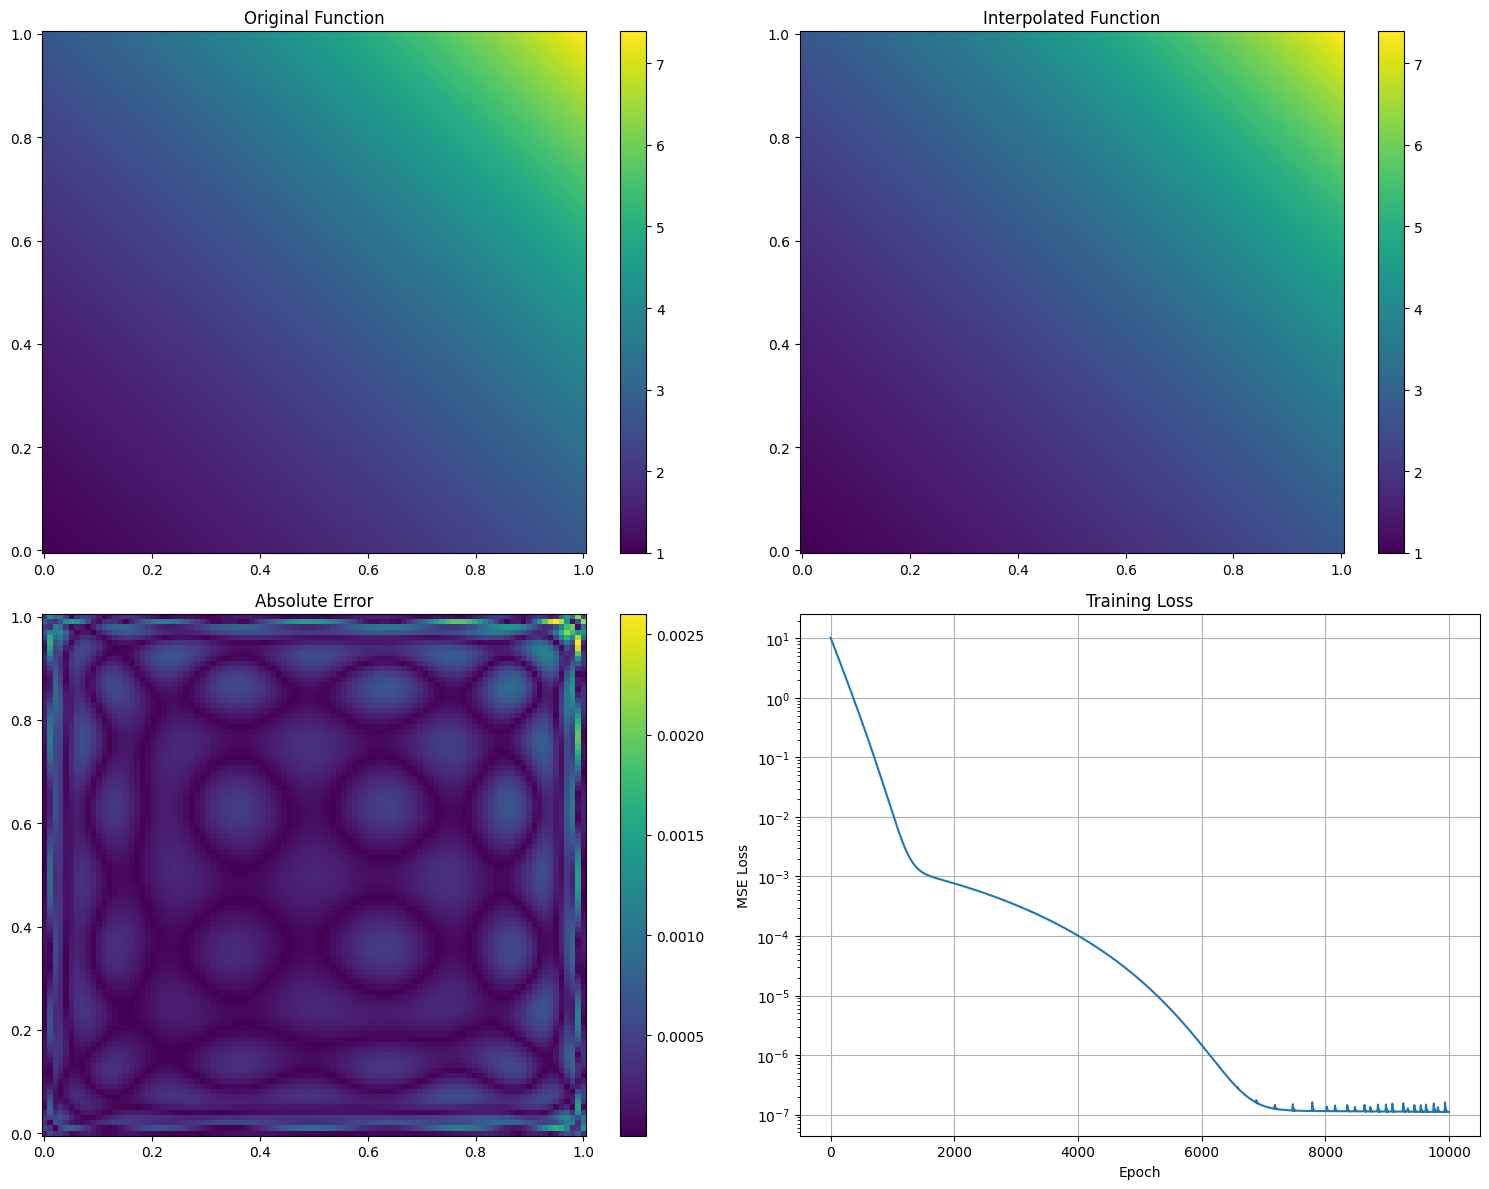


Training with resolution N=32x32
Epoch [100/10000], Loss: 5.605e+00
Epoch [200/10000], Loss: 2.983e+00
Epoch [300/10000], Loss: 1.575e+00
Epoch [400/10000], Loss: 8.251e-01
Epoch [500/10000], Loss: 4.274e-01
Epoch [600/10000], Loss: 2.179e-01
Epoch [700/10000], Loss: 1.089e-01
Epoch [800/10000], Loss: 5.311e-02
Epoch [900/10000], Loss: 2.522e-02
Epoch [1000/10000], Loss: 1.163e-02
Epoch [1100/10000], Loss: 5.205e-03
Epoch [1200/10000], Loss: 2.259e-03
Epoch [1300/10000], Loss: 9.519e-04
Epoch [1400/10000], Loss: 3.911e-04
Epoch [1500/10000], Loss: 1.579e-04
Epoch [1600/10000], Loss: 6.361e-05
Epoch [1700/10000], Loss: 2.624e-05
Epoch [1800/10000], Loss: 1.157e-05
Epoch [1900/10000], Loss: 5.776e-06
Epoch [2000/10000], Loss: 3.428e-06
Epoch [2100/10000], Loss: 2.432e-06
Epoch [2200/10000], Loss: 1.981e-06
Epoch [2300/10000], Loss: 1.756e-06
Epoch [2400/10000], Loss: 1.629e-06
Epoch [2500/10000], Loss: 1.543e-06
Epoch [2600/10000], Loss: 1.476e-06
Epoch [2700/10000], Loss: 1.416e-06
Epo

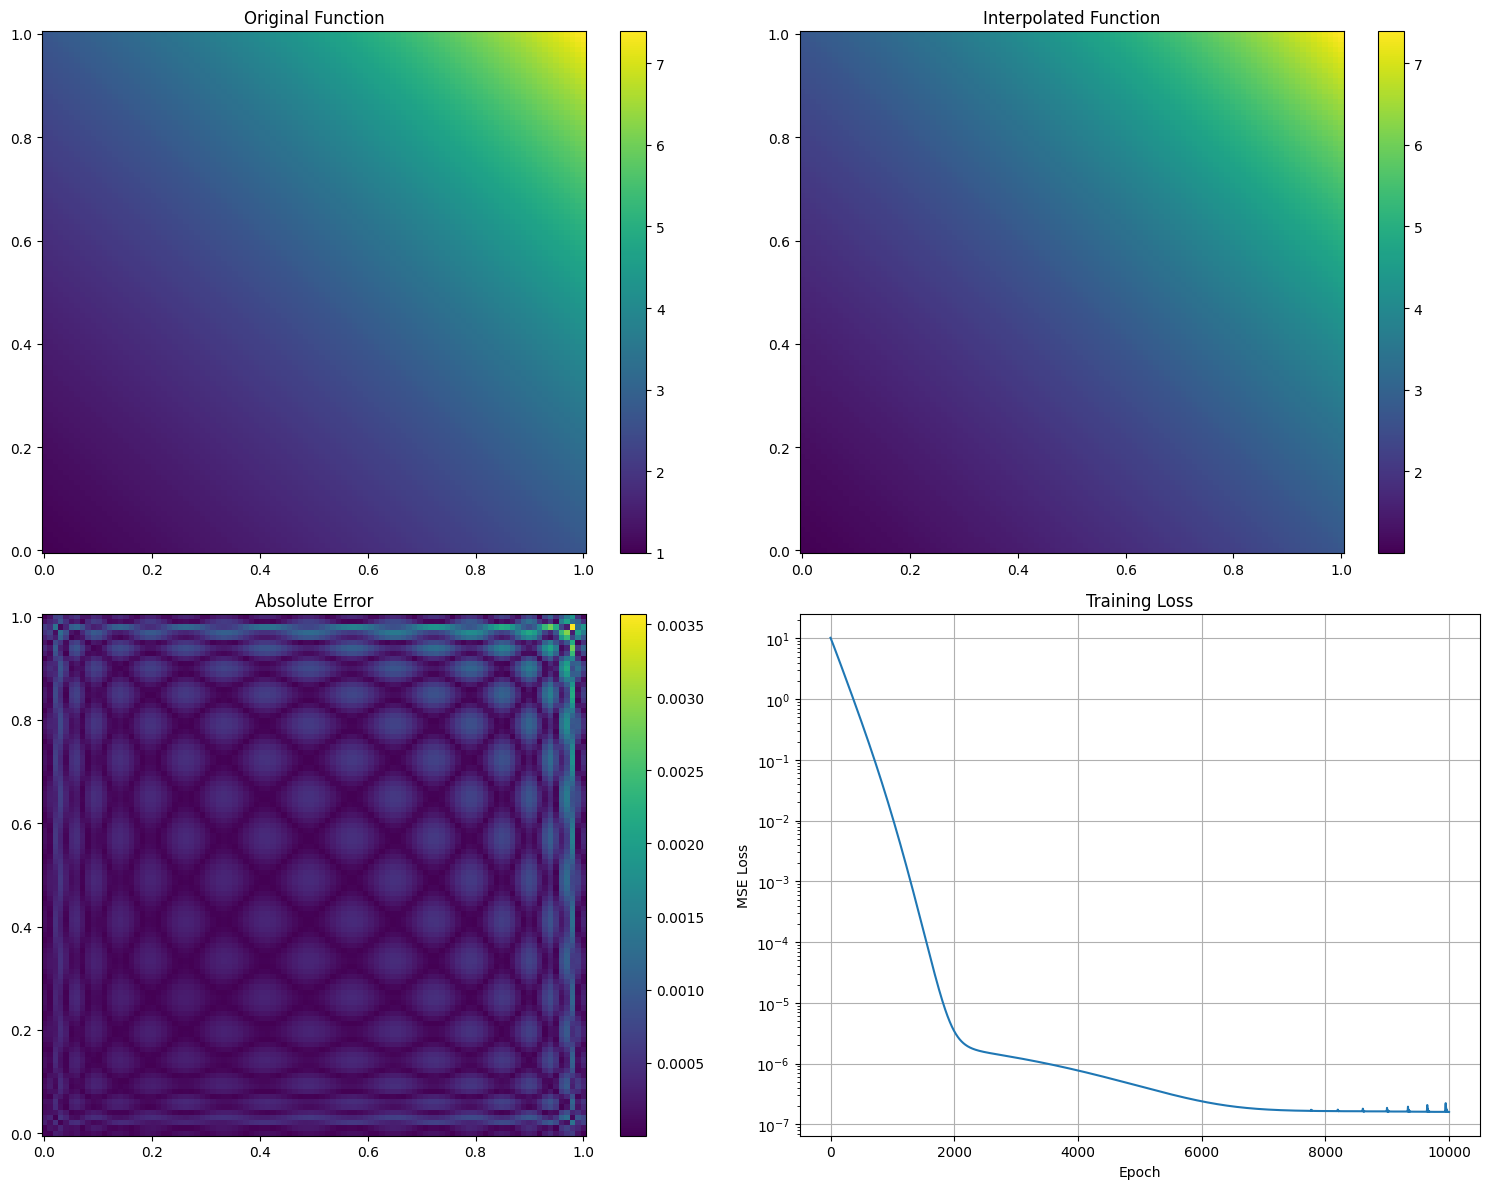


Training with resolution N=64x64
Epoch [100/10000], Loss: 5.613e+00
Epoch [200/10000], Loss: 2.984e+00
Epoch [300/10000], Loss: 1.573e+00
Epoch [400/10000], Loss: 8.224e-01
Epoch [500/10000], Loss: 4.255e-01
Epoch [600/10000], Loss: 2.171e-01
Epoch [700/10000], Loss: 1.090e-01
Epoch [800/10000], Loss: 5.392e-02
Epoch [900/10000], Loss: 2.640e-02
Epoch [1000/10000], Loss: 1.298e-02
Epoch [1100/10000], Loss: 6.569e-03
Epoch [1200/10000], Loss: 3.554e-03
Epoch [1300/10000], Loss: 2.130e-03
Epoch [1400/10000], Loss: 1.433e-03
Epoch [1500/10000], Loss: 1.061e-03
Epoch [1600/10000], Loss: 8.341e-04
Epoch [1700/10000], Loss: 6.760e-04
Epoch [1800/10000], Loss: 5.542e-04
Epoch [1900/10000], Loss: 4.551e-04
Epoch [2000/10000], Loss: 3.726e-04
Epoch [2100/10000], Loss: 3.037e-04
Epoch [2200/10000], Loss: 2.464e-04
Epoch [2300/10000], Loss: 1.989e-04
Epoch [2400/10000], Loss: 1.599e-04
Epoch [2500/10000], Loss: 1.283e-04
Epoch [2600/10000], Loss: 1.028e-04
Epoch [2700/10000], Loss: 8.251e-05
Epo

KeyboardInterrupt: 

In [32]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def train_transformed_interpolant(Nx=32, Ny=32, num_epochs=1000, lr=1e-2):
    # Define original and transformed test functions
    def test_function(x, y):
        return torch.exp(x + y)
    
    def transformed_function(theta, phi):
        x = torch.cos(theta)/2 + 0.5
        y = torch.cos(phi)/2 + 0.5
        return test_function(x, y)
    
    # Create the interpolant
    interp = SpectralInterpolationND(
        Ns=[Nx, Ny],
        bases=['fourier', 'fourier'],
        domains=[(0, 2*np.pi), (0, 2*np.pi)]
    )
    
    # Create reference grid for training
    x = torch.linspace(0, 1, 100)
    y = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    
    # Transform training points to θ-φ space
    theta_train = torch.arccos(2*X.flatten() - 1)
    phi_train = torch.arccos(2*Y.flatten() - 1)
    points_train = torch.stack([theta_train, phi_train], dim=1)
    
    # Get exact values at training points
    exact_values = test_function(X.flatten(), Y.flatten())
    
    # Setup optimizer
    optimizer = optim.Adam([interp.values], lr=lr)
    
    # Training loop
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        pred_values = interp(points_train)
        
        # Compute loss
        loss = torch.mean((pred_values - exact_values)**2)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Store loss
        losses.append(loss.item())
        
        # Print progress
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():1.3e}')
    
    # Final evaluation
    pred_final = interp(points_train)
    error = torch.abs(pred_final - exact_values)
    
    # Plotting
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Original function
    exact_grid = exact_values.reshape(100, 100)
    im1 = ax1.pcolormesh(X.numpy(), Y.numpy(), exact_grid.detach().numpy(), shading='auto')
    ax1.set_title('Original Function')
    plt.colorbar(im1, ax=ax1)
    
    # Interpolated result
    pred_grid = pred_final.reshape(100, 100)
    im2 = ax2.pcolormesh(X.numpy(), Y.numpy(), pred_grid.detach().numpy(), shading='auto')
    ax2.set_title('Interpolated Function')
    plt.colorbar(im2, ax=ax2)
    
    # Error
    error_grid = error.reshape(100, 100)
    im3 = ax3.pcolormesh(X.numpy(), Y.numpy(), error_grid.detach().numpy(), shading='auto')
    ax3.set_title('Absolute Error')
    plt.colorbar(im3, ax=ax3)
    
    # Loss history
    ax4.plot(losses)
    ax4.set_yscale('log')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('MSE Loss')
    ax4.set_title('Training Loss')
    ax4.grid(True)
    
    plt.tight_layout()
    
    # Print final metrics
    final_loss = losses[-1]
    max_error = error.max().item()
    mean_error = error.mean().item()
    print(f"\nFinal Metrics:")
    print(f"MSE Loss: {final_loss:1.3e}")
    print(f"Max Absolute Error: {max_error:1.3e}")
    print(f"Mean Absolute Error: {mean_error:1.3e}")
    
    return interp, losses, error

# Try different resolutions
for N in [16, 32, 64]:
    print(f"\nTraining with resolution N={N}x{N}")
    interp, losses, error = train_transformed_interpolant(Nx=N, Ny=N, num_epochs=10000)
    plt.show()